In [16]:
!pip install -qU uproot ace_tools awkward_pandas

## Data Acquisition

In [44]:
import uproot, pandas as pd, pprint, re, pathlib

root_path = pathlib.Path("~/Desktop/CERN/LHC-aging-analysis/data/laserROOT/o2_ft0digits.root").expanduser()
file = uproot.open(root_path)

# 1️⃣ peek into the o2sim directory
o2sim_dir = file["o2sim"]
print("Keys under o2sim:")
pprint.pp(o2sim_dir.keys())            # should list TTrees like 'FT0Digit', 'CTPHeader', …

# 2️⃣ find a tree that contains the FT0 digits
tree_name = next(k for k in o2sim_dir.keys() if re.search(r"FT0.*Digit", k, re.I))
tree = o2sim_dir[tree_name]
print("Using tree:", tree_name)

# 3️⃣ load branches -> DataFrame
#df = tree.arrays(library="pd")         # or specify columns=["chanId","adc","tfTime"]
#print(df.head())

Keys under o2sim:
['FT0DIGITSBC',
 'FT0DIGITSBC/FT0DIGITSBC.ref.mFirstEntry',
 'FT0DIGITSBC/FT0DIGITSBC.ref.mEntries',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.triggersignals',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.nChanA',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.nChanC',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.amplA',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.amplC',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.timeA',
 'FT0DIGITSBC/FT0DIGITSBC.mTriggers.timeC',
 'FT0DIGITSBC/FT0DIGITSBC.mEventStatus',
 'FT0DIGITSBC/FT0DIGITSBC.mIntRecord.bc',
 'FT0DIGITSBC/FT0DIGITSBC.mIntRecord.orbit',
 'FT0DIGITSBC/FT0DIGITSBC.mEventID',
 'FT0DIGITSCH',
 'FT0DIGITSCH/FT0DIGITSCH.ChId',
 'FT0DIGITSCH/FT0DIGITSCH.ChainQTC',
 'FT0DIGITSCH/FT0DIGITSCH.CFDTime',
 'FT0DIGITSCH/FT0DIGITSCH.QTCAmpl']
Using tree: FT0DIGITSBC


In [3]:
import json, pathlib, re, math
import numpy as np
import pandas as pd
import uproot, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
import awkward as ak

# Paths
DIGIT_DIR = pathlib.Path("../data/laserROOT/work/250714-123016/digits")
RUN_JSON  = pathlib.Path("../data/laserROOT/laser_runs.json")

assert DIGIT_DIR.is_dir(), "Digits directory not found"
assert RUN_JSON.is_file(), "runs.json not found"

# Helper: Gaussian model
def gauss(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

In [4]:
with RUN_JSON.open() as f:
    run_meta = {item["run"]: item["start_ms"] for item in json.load(f)}

print(f"runs.json contains {len(run_meta)} entries")

runs.json contains 228 entries


In [5]:
results     = []
file_re     = re.compile(r"run_(\d+)_ft0digits\.root")
digit_files = sorted(DIGIT_DIR.glob("run_*_ft0digits.root"))
failures = 0

print(f"Found {len(digit_files)} ROOT files")

for root_path in tqdm(digit_files, desc="processing runs"):
    run = int(file_re.match(root_path.name).group(1))

    # 1) read QTC amplitudes (flatten jagged array)
    with uproot.open(root_path) as f:
        qtc_awk = f["o2sim/FT0DIGITSCH"]["FT0DIGITSCH.QTCAmpl"].array(library="ak")
    qtc = ak.to_numpy(ak.flatten(qtc_awk))
    if qtc.size == 0:
        continue

    # 2) histogram + peak
    hist, edges  = np.histogram(qtc, bins="auto")
    bins         = 0.5 * (edges[:-1] + edges[1:])
    x_peak       = bins[np.argmax(hist)]        # ADC value at mode

    # 3) adaptive fit window
    for scale in (0.25, 0.35, 0.45, 0.60):
        mask = (bins >= (1 - scale) * x_peak) & (bins <= (1 + scale) * x_peak)
        if (hist[mask] > 0).sum() >= 5:
            x_fit, y_fit = bins[mask], hist[mask]
            break
    else:
        results.append(dict(run=run, start_ms=run_meta.get(run),
                            adc_mip=np.nan, err=np.nan))
        continue

    # 4) Gaussian fit  →  μ̂, σ̂  (may fail)
    try:
        p0 = (y_fit.max(), x_peak, np.std(qtc))
        popt, _ = curve_fit(gauss, x_fit, y_fit, p0=p0, maxfev=8000)
        _, mu, sigma = popt
    except RuntimeError:
        mu, sigma = np.nan, np.nan
        failures = failures + 1

    # 5) **normalise by peak position**
    mu_norm = mu / x_peak if np.isfinite(mu) and x_peak else np.nan
    sigma_norm = sigma / x_peak if np.isfinite(sigma) and x_peak else np.nan

    results.append(dict(run=run,
                        start_ms=run_meta.get(run),
                        adc_mip=mu_norm,
                        err=sigma_norm))

# build DataFrame, discard failed fits
df = (pd.DataFrame(results)
        .dropna(subset=["adc_mip"])
        .sort_values("start_ms"))

print("Result table shape:", df.shape)
print("Failures:", failures)
df.head()

Found 198 ROOT files


processing runs:   0%|          | 0/198 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [53]:
print(df[["adc_mip", "err"]].describe())
print("\nEarliest run :", pd.to_datetime(df['start_ms'], unit='ms').min())
print("Latest run   :", pd.to_datetime(df['start_ms'], unit='ms').max())

          adc_mip         err
count  189.000000  189.000000
mean     1.009128    0.056322
std      0.041902    0.124420
min      0.937589   -0.159639
25%      0.974770   -0.130070
50%      1.001279    0.126968
75%      1.039188    0.137269
max      1.114365    0.160137

Earliest run : 2024-04-07 17:13:04
Latest run   : 2025-07-14 02:54:44.829000


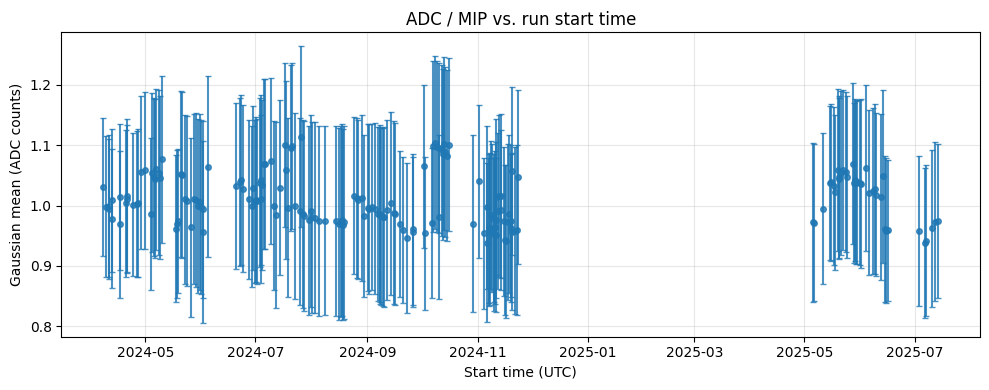

In [62]:
plt.figure(figsize=(10, 4))

# 1) keep only rows with a finite, positive σ
plot_df = df[np.isfinite(df["err"])].copy()
plot_df["err"] = plot_df["err"].abs()         # force positivity

# 2) convert ms → pandas datetime, then to matplotlib
plot_df["time"] = pd.to_datetime(plot_df["start_ms"], unit="ms")

plt.errorbar(
    plot_df["time"],
    plot_df["adc_mip"],
    yerr=plot_df["err"],
    fmt="o",
    ms=4,
    capsize=2,
    alpha=0.8,
)

plt.title("ADC / MIP vs. run start time")
plt.ylabel("Gaussian mean (ADC counts)")
plt.xlabel("Start time (UTC)")
plt.grid(True, alpha=0.3)
plt.tight_layout()

## Pre-processing & EDA

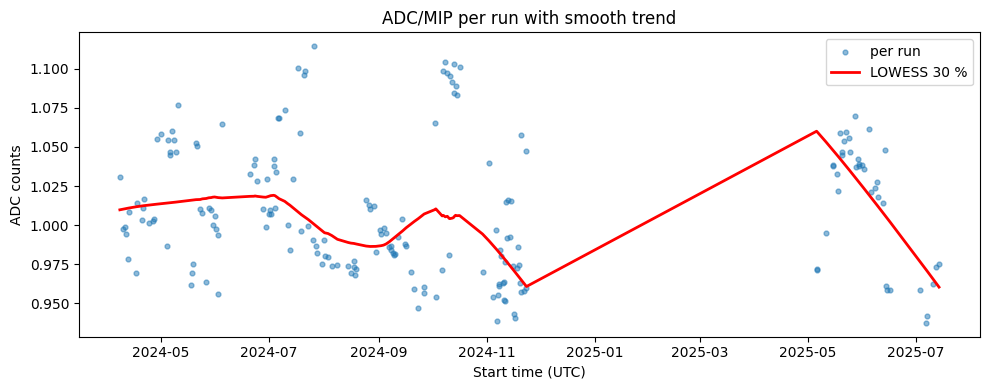

In [55]:
from statsmodels.nonparametric.smoothers_lowess import lowess

x = pd.to_datetime(df['start_ms'], unit='ms')
y = df['adc_mip'].values
# LOWESS with 30 % span
low = lowess(y, x.astype(int), frac=0.3, return_sorted=False)

plt.figure(figsize=(10,4))
plt.scatter(x, y, s=12, alpha=0.5, label='per run')
plt.plot(x, low, color='red', lw=2, label='LOWESS 30 %')
plt.title("ADC/MIP per run with smooth trend")
plt.ylabel("ADC counts")
plt.xlabel("Start time (UTC)")
plt.legend(); plt.tight_layout()

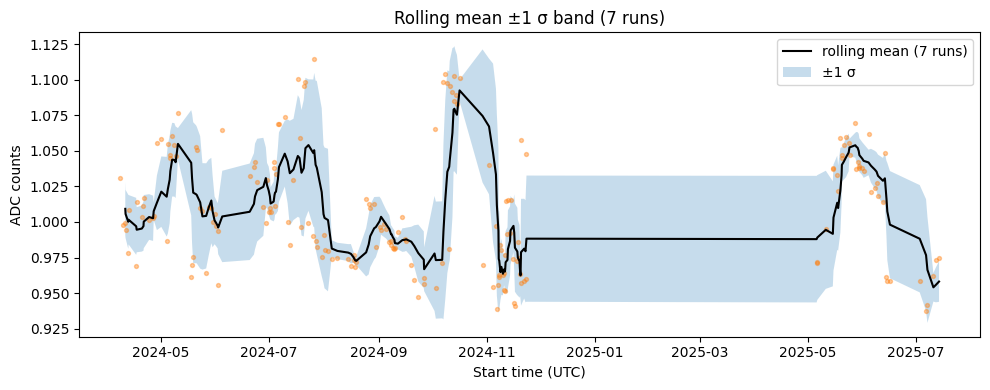

In [56]:
# 7-run rolling statistics
roll_mean  = df['adc_mip'].rolling(7, min_periods=3).mean()
roll_sigma = df['adc_mip'].rolling(7, min_periods=3).std()

plt.figure(figsize=(10,4))
plt.plot(x, roll_mean, color='k', lw=1.5, label='rolling mean (7 runs)')
plt.fill_between(x,
                 roll_mean-roll_sigma,
                 roll_mean+roll_sigma,
                 alpha=0.25, label='±1 σ')
plt.scatter(x, y, s=8, alpha=0.4)
plt.title("Rolling mean ±1 σ band (7 runs)")
plt.ylabel("ADC counts"); plt.xlabel("Start time (UTC)")
plt.legend(); plt.tight_layout()

In [57]:
base = df["adc_mip"].iloc[0]
df["rel_mip"]  = df["adc_mip"] / base
df["rel_err"]  = df["err"]     / base

print("processed runs:", len(df))
df.head()

processed runs: 189


run       start_ms   adc_mip       err   rel_mip   rel_err
0  549661  1712509984000  1.030860  0.113678  1.000000  0.110275
1  549749  1712639399000  0.997766  0.116775  0.967897  0.113279
2  549824  1712774571000  0.999055 -0.118018  0.969147 -0.114485
3  549853  1712788504000  0.994662  0.116039  0.964885  0.112565
4  549958  1712919188000  0.978508  0.114535  0.949215  0.111106

In [64]:
cut_date = pd.Timestamp("2024-05-01")
mask_time = pd.to_datetime(df["start_ms"], unit="ms") >= cut_date
df = df.loc[mask_time].reset_index(drop=True)

print(f"After cut-off {cut_date.date()}: {len(df)} runs remain "
      f"({df['run'].min()} → {df['run'].max()})")

After cut-off 2024-05-01: 174 runs remain (550897 → 564587)


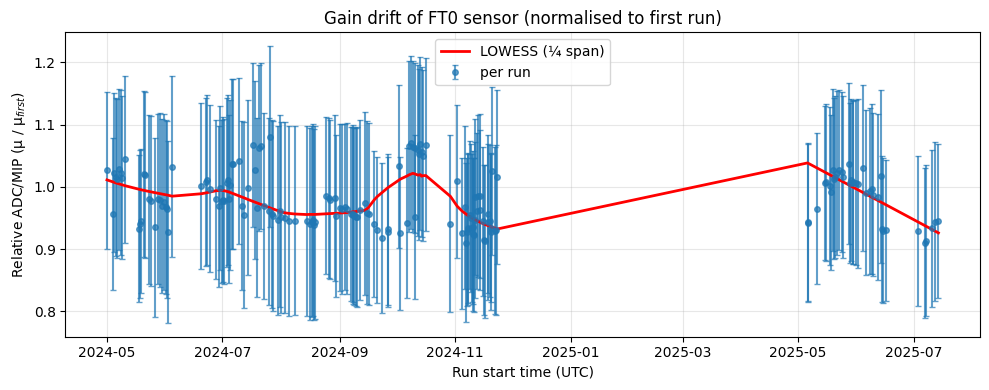

In [65]:
times     = pd.to_datetime(df["start_ms"], unit="ms")

mask      = np.isfinite(df["rel_err"])
plot_x    = times[mask]
plot_y    = df.loc[mask, "rel_mip"]
plot_err  = df.loc[mask, "rel_err"].abs()

plt.figure(figsize=(10, 4))
plt.errorbar(plot_x, plot_y, yerr=plot_err,
             fmt="o", ms=4, capsize=2, alpha=0.7, label="per run")

low = lowess(plot_y, df.loc[mask, "start_ms"], frac=0.25, return_sorted=False)
plt.plot(plot_x, low, color="red", lw=2, label="LOWESS (¼ span)")

plt.ylabel("Relative ADC/MIP (μ / μ$_{first}$)")
plt.xlabel("Run start time (UTC)")
plt.title("Gain drift of FT0 sensor (normalised to first run)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()

In [66]:
# ---------------------------------------------------------------------------
# NEW experiment:  peak / peak@t0   (no Gaussian fit)
# ---------------------------------------------------------------------------
peak_rows, failures = [], 0
digit_files = sorted(DIGIT_DIR.glob("run_*_ft0digits.root"))
file_re     = re.compile(r"run_(\d+)_ft0digits\.root")

print(f"Found {len(digit_files)} ROOT files")

for root_path in tqdm(digit_files, desc="peak-only runs"):
    run = int(file_re.match(root_path.name).group(1))

    # read & flatten amplitudes
    qtc = ak.to_numpy(
        ak.flatten(
            uproot.open(root_path)
                  ["o2sim/FT0DIGITSCH"]["FT0DIGITSCH.QTCAmpl"]
                  .array(library="ak")
        )
    )
    if qtc.size == 0:
        failures += 1
        continue

    # histogram + peak position
    hist, edges = np.histogram(qtc, bins="auto")
    bins        = 0.5 * (edges[:-1] + edges[1:])
    x_peak      = bins[np.argmax(hist)]

    peak_rows.append({
        "run": run,
        "start_ms": run_meta.get(run),
        "peak_adc": x_peak,
    })

# build tidy table
df_peak = (pd.DataFrame(peak_rows)
             .dropna(subset=["peak_adc"])
             .sort_values("start_ms")
             .reset_index(drop=True))

print(f"Successfully processed {len(df_peak)} runs  |  failures: {failures}")

# normalise to first run’s peak
peak_0 = df_peak.loc[0, "peak_adc"]
df_peak["rel_peak"] = df_peak["peak_adc"] / peak_0

df_peak.head()

Found 198 ROOT files


peak-only runs:   0%|          | 0/198 [00:00<?, ?it/s]

Successfully processed 191 runs  |  failures: 7


run       start_ms  peak_adc  rel_peak
0  549661  1712509984000     134.5  1.000000
1  549749  1712639399000     152.5  1.133829
2  549824  1712774571000     158.5  1.178439
3  549853  1712788504000     158.5  1.178439
4  549958  1712919188000     152.5  1.133829

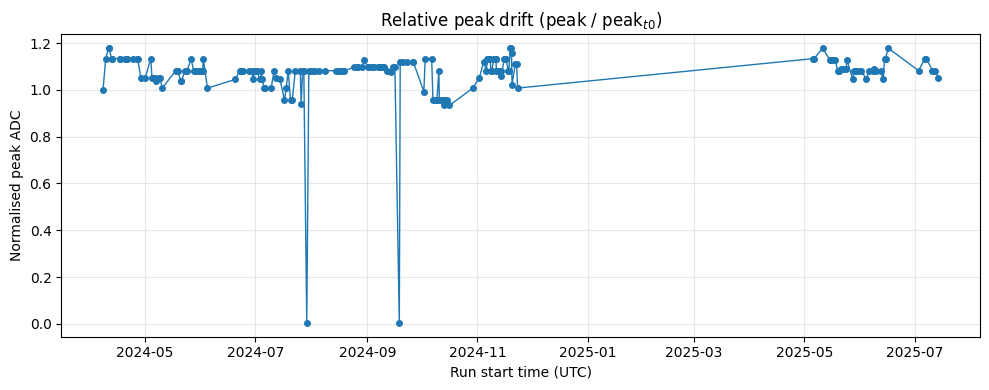

In [67]:
# simple scatter of relative peak drift
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(df_peak["start_ms"], unit="ms"),
         df_peak["rel_peak"], marker="o", ms=4, lw=1)
plt.title("Relative peak drift (peak / peak$_{t0}$)")
plt.ylabel("Normalised peak ADC")
plt.xlabel("Run start time (UTC)")
plt.grid(alpha=0.3)
plt.tight_layout()

In [68]:
# ---------------------------------------------------------------------------
#  loop: ADC/MIP (μ) normalised ONLY by the first run’s peak
# ---------------------------------------------------------------------------
results, failures = [], 0
first_peak = None                       # x_max at t = 0
file_re    = re.compile(r"run_(\d+)_ft0digits\.root")
digit_files = sorted(DIGIT_DIR.glob("run_*_ft0digits.root"))

print(f"Found {len(digit_files)} ROOT files")

for root_path in tqdm(digit_files, desc="processing runs"):
    run = int(file_re.match(root_path.name).group(1))

    # 1) amplitudes → flat NumPy
    qtc = ak.to_numpy(
        ak.flatten(
            uproot.open(root_path)
                  ["o2sim/FT0DIGITSCH"]["FT0DIGITSCH.QTCAmpl"]
                  .array(library="ak")
        )
    )
    if qtc.size == 0:
        failures += 1
        continue

    # 2) histogram → peak
    hist, edges = np.histogram(qtc, bins="auto")
    bins        = 0.5 * (edges[:-1] + edges[1:])
    x_peak      = bins[np.argmax(hist)]

    if first_peak is None:
        first_peak = x_peak               # set reference once

    # 3) adaptive window (≥5 populated bins)
    for scale in (0.25, 0.35, 0.45, 0.60):
        mask = (bins >= (1-scale)*x_peak) & (bins <= (1+scale)*x_peak)
        if (hist[mask] > 0).sum() >= 5:
            x_fit, y_fit = bins[mask], hist[mask]
            break
    else:
        failures += 1
        continue

    # 4) Gaussian fit
    try:
        (_, mu, sigma), _ = curve_fit(
            gauss, x_fit, y_fit,
            p0=(y_fit.max(), x_peak, np.std(qtc)),
            maxfev=8000
        )
    except RuntimeError:
        mu, sigma = np.nan, np.nan
        failures += 1

    # 5) final normalisation: divide by first_peak ONLY
    mu_norm    = mu / first_peak if np.isfinite(mu) else np.nan
    sigma_norm = abs(sigma) / first_peak if np.isfinite(sigma) else np.nan
    peak_rel   = x_peak / first_peak

    results.append(dict(run=run,
                        start_ms=run_meta.get(run),
                        rel_adc_mip=mu_norm,
                        rel_err=sigma_norm,
                        peak_rel=peak_rel))

# tidy DataFrame
df_peaknorm = (pd.DataFrame(results)
                 .dropna(subset=["rel_adc_mip"])
                 .sort_values("start_ms")
                 .reset_index(drop=True))

print("Processed runs:", len(df_peaknorm), "| failures:", failures)
df_peaknorm.head()

Found 198 ROOT files


processing runs:   0%|          | 0/198 [00:00<?, ?it/s]

Processed runs: 189 | failures: 9


run       start_ms  rel_adc_mip   rel_err  peak_rel
0  549661  1712509984000     1.030860  0.113678  1.000000
1  549749  1712639399000     1.131296  0.132403  1.133829
2  549824  1712774571000     1.177326  0.139077  1.178439
3  549853  1712788504000     1.172148  0.136745  1.178439
4  549958  1712919188000     1.109461  0.129863  1.133829

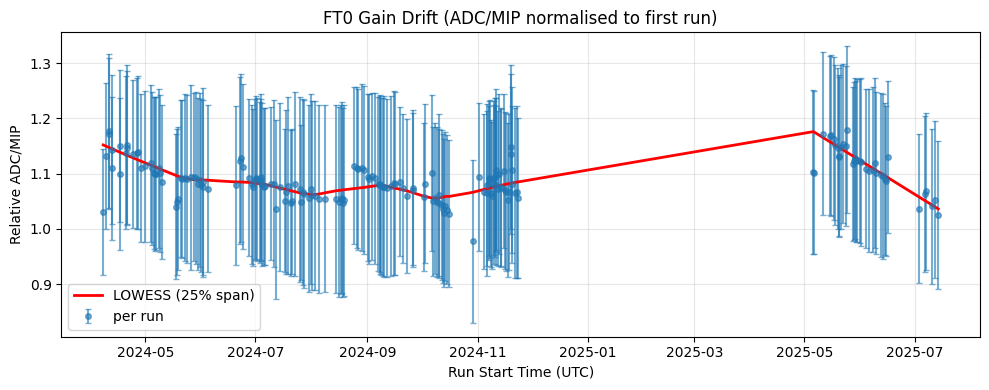

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# If df_peaknorm doesn't exist (e.g. fresh kernel), try loading from CSV produced earlier
try:
    df_plot = df_peaknorm.copy()
except NameError:
    df_plot = pd.read_csv("ft0_laser_gain_timeseries.csv")  # fallback
    # this file would have rel_mip/rel_err; rename for consistency
    if "rel_adc_mip" not in df_plot.columns and "rel_mip" in df_plot.columns:
        df_plot = df_plot.rename(columns={"rel_mip": "rel_adc_mip", "rel_err": "rel_err"})

# Convert start_ms to datetime
df_plot["time"] = pd.to_datetime(df_plot["start_ms"], unit="ms")

# LOWESS smooth of the relative gain
low = lowess(df_plot["rel_adc_mip"], df_plot["start_ms"], frac=0.25, return_sorted=False)

# Plot
plt.figure(figsize=(10, 4))
plt.errorbar(df_plot["time"], df_plot["rel_adc_mip"], yerr=df_plot["rel_err"],
             fmt="o", ms=4, capsize=2, alpha=0.6, label="per run")
plt.plot(df_plot["time"], low, color="red", lw=2, label="LOWESS (25% span)")

plt.title("FT0 Gain Drift (ADC/MIP normalised to first run)")
plt.ylabel("Relative ADC/MIP")
plt.xlabel("Run Start Time (UTC)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [71]:
# ---------------------------------------------------------------------------
#  new experiment: weighted-mean of slice (no Gaussian fit)
#  * rel_adc_w  = ⟨ADC⟩_weighted   /  first-run peak
#  * rel_err_w  = weighted σ       /  first-run peak
# ---------------------------------------------------------------------------
w_rows, failures = [], 0
first_peak = None                                  # reference x_max @ t0
file_re    = re.compile(r"run_(\d+)_ft0digits\.root")
digit_files = sorted(DIGIT_DIR.glob("run_*_ft0digits.root"))

print(f"Found {len(digit_files)} ROOT files")

for root_path in tqdm(digit_files, desc="weighted-mean runs"):
    run = int(file_re.match(root_path.name).group(1))

    # flat QTC amplitude vector
    qtc = ak.to_numpy(
        ak.flatten(
            uproot.open(root_path)
                  ["o2sim/FT0DIGITSCH"]["FT0DIGITSCH.QTCAmpl"]
                  .array(library="ak")
        )
    )
    if qtc.size == 0:
        failures += 1
        continue

    # histogram & peak
    hist, edges = np.histogram(qtc, bins="auto")
    bins        = 0.5 * (edges[:-1] + edges[1:])
    x_peak      = bins[np.argmax(hist)]

    # set reference once
    if first_peak is None:
        first_peak = x_peak

    # adaptive slice window (≥5 populated bins)
    for scale in (0.25, 0.35, 0.45, 0.60):
        m = (bins >= (1-scale)*x_peak) & (bins <= (1+scale)*x_peak)
        if (hist[m] > 0).sum() >= 5:
            xs, ws = bins[m], hist[m]
            break
    else:
        failures += 1
        continue

    # ---------- weighted mean & σ ------------------------------------------
    w_sum   = ws.sum()
    w_mean  = np.dot(xs, ws) / w_sum
    w_var   = np.dot(ws, (xs - w_mean) ** 2) / w_sum
    w_sigma = math.sqrt(w_var)

    # ---------- normalise by first-run peak only ---------------------------
    rel_adc_w = w_mean  / first_peak
    rel_err_w = w_sigma / first_peak
    peak_rel  = x_peak  / first_peak

    w_rows.append(dict(run=run,
                       start_ms=run_meta.get(run),
                       rel_adc_w=rel_adc_w,
                       rel_err_w=rel_err_w,
                       peak_rel=peak_rel))

# tidy DataFrame
df_weighted = (pd.DataFrame(w_rows)
                 .dropna(subset=["rel_adc_w"])
                 .sort_values("start_ms")
                 .reset_index(drop=True))

print("Processed:", len(df_weighted), "runs | failures:", failures)
df_weighted.head()

Found 198 ROOT files


weighted-mean runs:   0%|          | 0/198 [00:00<?, ?it/s]

Processed: 189 runs | failures: 9


run       start_ms  rel_adc_w  rel_err_w  peak_rel
0  549661  1712509984000   1.026852   0.104284  1.000000
1  549749  1712639399000   1.132793   0.121112  1.133829
2  549824  1712774571000   1.179265   0.125868  1.178439
3  549853  1712788504000   1.175475   0.124516  1.178439
4  549958  1712919188000   1.117627   0.120599  1.133829

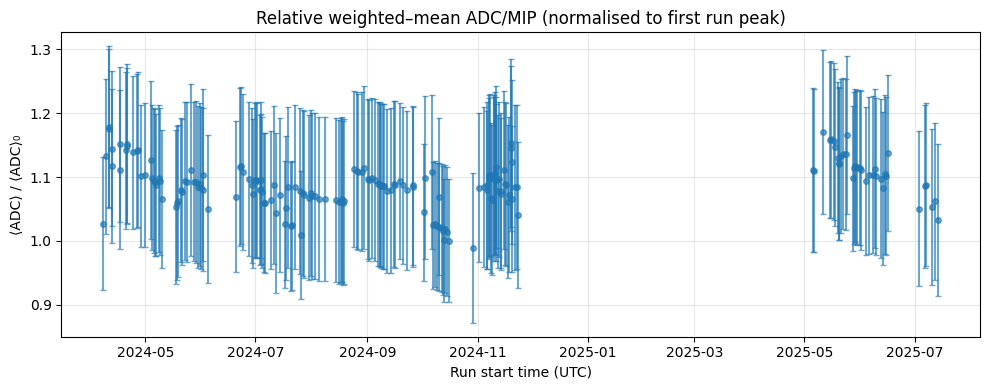

In [72]:
times = pd.to_datetime(df_weighted["start_ms"], unit="ms")

plt.figure(figsize=(10,4))
plt.errorbar(times, df_weighted["rel_adc_w"], yerr=df_weighted["rel_err_w"],
             fmt="o", ms=4, capsize=2, alpha=0.65, label="weighted μ")
plt.title("Relative weighted–mean ADC/MIP (normalised to first run peak)")
plt.ylabel("⟨ADC⟩ / ⟨ADC⟩₀")
plt.xlabel("Run start time (UTC)")
plt.grid(alpha=0.3); plt.tight_layout()

In [1]:
import pathlib, re, gc
import numpy as np, matplotlib.pyplot as plt, uproot
from tqdm.notebook import tqdm

# ---------------- configuration ------------------------------------------
DIG_DIR = pathlib.Path("../data/laserROOT/work/250714-123016/digits")
file_re = re.compile(r"run_(\d+)_ft0digits\.root")

bins   = np.arange(0, 4096, 8, dtype=np.float32)   # 512 bins of width 8 ADC
n_bins = len(bins) - 1
step   = "50 MB"                                   # chunk size for uproot

# ---------------- pre-allocate -------------------------------------------
digit_files = sorted(DIG_DIR.glob("run_*_ft0digits.root"))
runs = np.empty(len(digit_files), dtype=np.int32)
H    = np.zeros((len(digit_files), n_bins), dtype=np.uint32)

print(f"Building histograms for {len(digit_files)} ROOT files …")

for i, path in enumerate(tqdm(digit_files, desc="histograms")):
    runs[i] = int(file_re.match(path.name).group(1))

    with uproot.open(path) as f:
        tree = f["o2sim/FT0DIGITSCH"]
        # iterate over *one numeric branch*; each chunk is a NumPy object array
        for chunk in tree.iterate(["FT0DIGITSCH.QTCAmpl"],
                                  library="np", step_size=step):
            qtc_obj = chunk["FT0DIGITSCH.QTCAmpl"]    # dtype=object, ragged
            if qtc_obj.size:
                flat = np.concatenate(qtc_obj)        # 1-D numeric view
                if flat.size:
                    H[i] += np.histogram(flat, bins=bins)[0].astype(np.uint32)
    gc.collect()                                      # keep RSS low

print("Finished matrix H:", H.shape, "| dtype:", H.dtype)

Building histograms for 198 ROOT files …


histograms:   0%|          | 0/198 [00:00<?, ?it/s]

Finished matrix H: (198, 511) | dtype: uint32


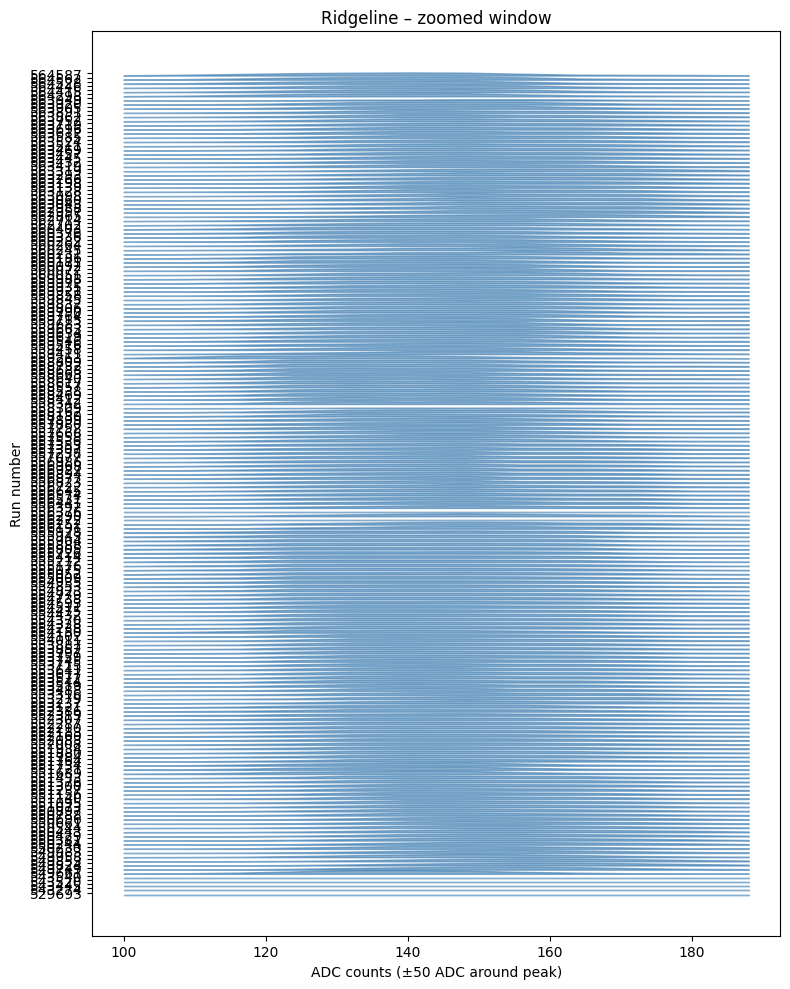

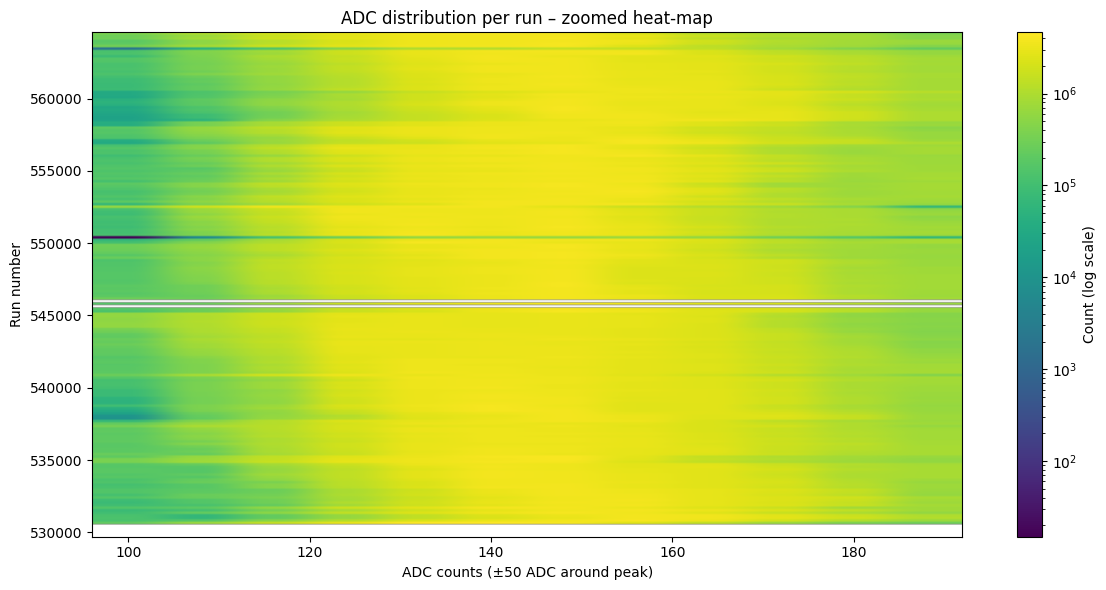

In [3]:
# -------------------------------------------------------------------------
# 1. determine global peak bin
# -------------------------------------------------------------------------
sum_hist   = H.sum(axis=0)                     # collapse all runs
peak_idx   = np.argmax(sum_hist)               # index of modal bin
window_adc = 50                                # ±50 ADC around the peak

# convert "ADC width" into bin indices (bins are 8 ADC wide)
bins_per_side = int(window_adc / (bins[1] - bins[0]))   # here: 50 / 8 = 6
lo, hi = max(0, peak_idx - bins_per_side), min(len(bins) - 1, peak_idx + bins_per_side)

slice_bins   = bins[lo:hi+1]                   # bin edges for plotting
slice_centres = 0.5 * (slice_bins[:-1] + slice_bins[1:])
H_slice      = H[:, lo:hi]                     # same window for counts

# -------------------------------------------------------------------------
# 2. ridgeline within the ±50 ADC window
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 10))
offset, scale = 0.0, 0.90 / H_slice.max()      # rescale for new range

for row in H_slice:
    ax.fill_between(slice_centres,
                    offset,
                    offset + row * scale,
                    color="steelblue", alpha=0.65)
    offset += 1

ax.set_yticks(np.arange(len(runs)) + 0.5)
ax.set_yticklabels(runs)
ax.set_xlabel("ADC counts (±50 ADC around peak)")
ax.set_ylabel("Run number")
ax.set_title("Ridgeline – zoomed window")
plt.tight_layout(); plt.show()

# -------------------------------------------------------------------------
# 3. heat-map in the same window
# -------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.imshow(H_slice, aspect='auto', origin='lower',
           extent=[slice_bins[0], slice_bins[-1], runs[0], runs[-1]],
           cmap='viridis', norm='log')
plt.colorbar(label='Count (log scale)')
plt.xlabel("ADC counts (±50 ADC around peak)")
plt.ylabel("Run number")
plt.title("ADC distribution per run – zoomed heat-map")
plt.tight_layout(); plt.show()

In [4]:
import pathlib, re, gc
import numpy as np, uproot, awkward as ak
from tqdm.notebook import tqdm

DIG_DIR = pathlib.Path("../data/laserROOT/work/250714-123016/digits")
file_re = re.compile(r"run_(\d+)_ft0digits\.root")

bins_adc    = np.arange(0, 4096, 8, dtype=np.float32)        # 512 ADC bins
n_bins      = len(bins_adc) - 1
n_channels  = 256                                             # FT0 pad indexes
step_size   = "50 MB"

digit_files = sorted(DIG_DIR.glob("run_*_ft0digits.root"))
runs = np.empty(len(digit_files), dtype=np.int32)

# final tensor:  run × channel × bin
Hch = np.zeros((len(digit_files), n_channels, n_bins), dtype=np.uint32)

for i, p in enumerate(tqdm(digit_files, desc="per-channel hists")):
    runs[i] = int(file_re.match(p.name).group(1))

    with uproot.open(p) as f:
        tree = f["o2sim/FT0DIGITSCH"]

        for chunk in tree.iterate(
                ["FT0DIGITSCH.QTCAmpl", "FT0DIGITSCH.ChId"],
                library="ak", step_size=step_size):

            adc_flat  = ak.to_numpy(ak.flatten(chunk["FT0DIGITSCH.QTCAmpl"]))
            chid_flat = ak.to_numpy(ak.flatten(chunk["FT0DIGITSCH.ChId"]))

            # histogram each channel locally → add into global tensor
            for ch in np.unique(chid_flat):
                mask = chid_flat == ch
                if mask.any():
                    Hch[i, ch] += np.histogram(adc_flat[mask], bins=bins_adc)[0].astype(np.uint32)

    gc.collect()
print("Tensor Hch shape:", Hch.shape)   # (nRuns, 256, 512)

per-channel hists:   0%|          | 0/198 [00:00<?, ?it/s]

Tensor Hch shape: (198, 256, 511)


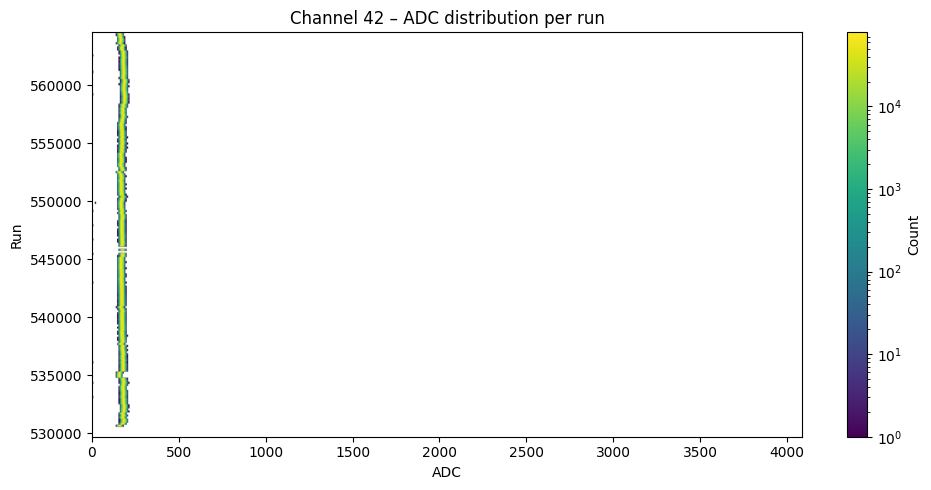

In [5]:
import matplotlib.pyplot as plt

ch = 42                                    # pick a channel
plt.figure(figsize=(10, 5))
plt.imshow(Hch[:, ch], aspect='auto', origin='lower',
           extent=[bins_adc[0], bins_adc[-1], runs[0], runs[-1]],
           cmap='viridis', norm='log')
plt.colorbar(label='Count')
plt.title(f"Channel {ch} – ADC distribution per run")
plt.xlabel("ADC"); plt.ylabel("Run")
plt.tight_layout(); plt.show()

Channels with data: 212 / 256


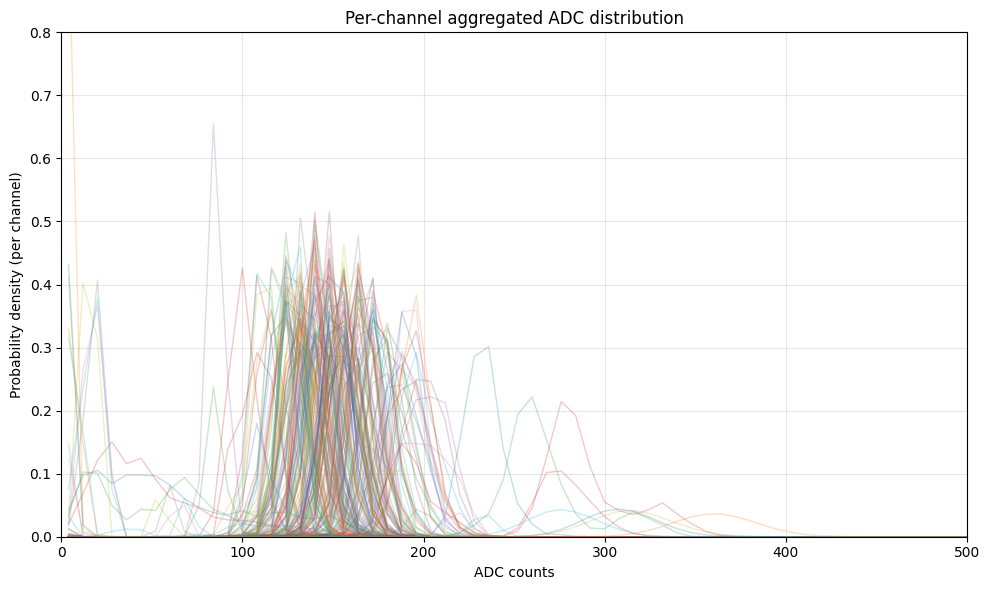

In [8]:
# ----------------------------------------------------------------------
# Quick EDA – how many populated channels? + over-plotted histograms
#  requires tensor Hch [nRuns × 256 × nBins] and `bins_adc` from earlier
# ----------------------------------------------------------------------
import numpy as np, matplotlib.pyplot as plt

# 1) how many channels have at least one non-zero bin across all runs
populated = (Hch.sum(axis=(0, 2)) > 0)
n_pop     = populated.sum()
print(f"Channels with data: {n_pop} / {Hch.shape[1]}")

# 2) over-plot one histogram per populated channel (aggregate over runs)
bin_centres = 0.5 * (bins_adc[:-1] + bins_adc[1:])

plt.figure(figsize=(10, 6))
for ch in np.where(populated)[0]:
    counts = Hch[:, ch].sum(axis=0)                  # aggregate over runs
    if counts.sum() == 0:
        continue
    # density=True for better comparability across channels
    plt.plot(bin_centres,
             counts / counts.sum(),
             lw=1,
             alpha=0.25,                             # fade overlap
             label=f"Ch {ch}" if ch < 8 else None)   # avoid huge legend

plt.xlim(0, 500)   # <-- X-axis 0 … 500 ADC
plt.ylim(0, 0.8)   # <-- Y-axis 0 … 0.8

plt.title("Per-channel aggregated ADC distribution")
plt.xlabel("ADC counts")
plt.ylabel("Probability density (per channel)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Ageing trends for one channel (PMA3/CH02 : 24 linear)

In [29]:
import pandas as pd, gc
from tqdm.auto import tqdm

# ---- constants -----------------------------------------------------------
TARGET_CH   = 24                     # PMA3/CH02  (0-based)
REF_CHS     = [208, 210, 211]        # PMC9/CH05,07,08

In [30]:
# Cell 2 – robust Gaussian fit -------------------------------------------
import numpy as np
from scipy.optimize import curve_fit

MIN_ENTRIES = 300          # skip fits if fewer digits than this

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def try_gaussian(data, frac=0.25):
    """
    Safe wrapper around curve_fit.
    Returns (mu, sigma) or (np.nan, np.nan) on any problem.
    """
    if data.size < MIN_ENTRIES:
        return np.nan, np.nan

    hist, edges = np.histogram(data, bins="auto")
    bins        = 0.5*(edges[:-1] + edges[1:])
    x_peak      = bins[np.argmax(hist)]

    for scale in (frac, 0.35, 0.45, 0.60):
        mask = (bins >= (1-scale)*x_peak) & (bins <= (1+scale)*x_peak)
        if (hist[mask] > 0).sum() >= 5:
            try:
                p0 = (hist[mask].max(), x_peak, np.std(data))
                popt, _ = curve_fit(gauss, bins[mask], hist[mask],
                                    p0=p0, maxfev=8000)
                return popt[1], popt[2]
            except RuntimeError:
                break
    return np.nan, np.nan

In [11]:
# -------- parameters you can tune ------------------------------------------
MIN_ENTRIES  = 300         # skip channels with fewer digits
MIN_REFS     = 2           # need ≥ this many ref-channel fits to accept a run
MAD_CLIP     = 4.0         # discard a μ if it is > MAD_CLIP×MAD away from median
# ----------------------------------------------------------------------------

import numpy as np, pandas as pd, uproot, awkward as ak, pathlib, json, gc
from tqdm.auto import tqdm
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit


def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def safe_mu(arr, frac=0.25):
    if arr.size < MIN_ENTRIES:
        return np.nan
    h, e = np.histogram(arr, bins="auto")
    b    = 0.5*(e[:-1]+e[1:])
    pk   = b[np.argmax(h)]
    for sc in (frac, .35, .45, .60):
        m = (b >= (1-sc)*pk) & (b <= (1+sc)*pk)
        if (h[m] > 0).sum() >= 5:
            try:
                p0 = (h[m].max(), pk, np.std(arr))
                return curve_fit(gauss, b[m], h[m], p0=p0, maxfev=8000)[0][1]
            except RuntimeError:
                break
    return np.nan


DIG_DIR   = pathlib.Path("../data/laserROOT/work/250725-082002/digits")
RUN_META  = {int(d["run"]): d["start_ms"]
             for d in json.load(open("../data/laserROOT/laser_runs.json"))}

rows, dropped_fewrefs, dropped_spike = [], 0, 0
for p in tqdm(sorted(DIG_DIR.glob("run_*_ft0digits.root")), desc="runs"):
    run = int(p.name.split("_")[1])
    t_ms = RUN_META.get(run)
    if t_ms is None:
        continue                      # no timestamp → skip
    with uproot.open(p) as f:
        qtc = f["o2sim/FT0DIGITSCH"]["FT0DIGITSCH.QTCAmpl"].array(library="ak")

    mu_tgt = safe_mu(ak.to_numpy(qtc[:, TARGET_CH].to_numpy().flatten()))
    if not np.isfinite(mu_tgt):
        continue                      # bad target fit

    mu_refs = [safe_mu(ak.to_numpy(qtc[:, ch].to_numpy().flatten()))
               for ch in REF_CHS]
    mu_refs = [x for x in mu_refs if np.isfinite(x)]
    if len(mu_refs) < MIN_REFS:
        dropped_fewrefs += 1
        continue

    # clip obvious outliers among refs (robust MAD method)
    med, mad = np.median(mu_refs), median_abs_deviation(mu_refs)
    mu_refs = [x for x in mu_refs if abs(x-med) < MAD_CLIP*mad]
    if len(mu_refs) < MIN_REFS:
        dropped_spike += 1
        continue

    rows.append(dict(run=run, t_ms=t_ms,
                     mu_tgt=mu_tgt,
                     mu_ref=np.mean(mu_refs),
                     n_ref=len(mu_refs)))

print(f"→ kept {len(rows)} runs, dropped few-ref={dropped_fewrefs}, "
      f"dropped spike={dropped_spike}")

df = pd.DataFrame(rows).sort_values("t_ms").reset_index(drop=True)

# --- normalise to t0 ---------------------------------------------------------
norm1 = df.loc[0, "mu_tgt"] / df.loc[0, "mu_ref"]
df["rel_gain"] = (df["mu_tgt"] / df["mu_ref"]) / norm1
df["time"]     = pd.to_datetime(df["t_ms"], unit="ms")
df.head()

runs:   0%|          | 0/381 [00:00<?, ?it/s]

NameError: name 'TARGET_CH' is not defined

In [40]:
# Cell 4 – derive relative gain ------------------------------------------
# norm₁  =  μ_target(t0) / μ_ref(t0)
mu_tgt_0  = df.loc[0, "mu_tgt"]
mu_ref_0  = df.loc[0, "mu_ref"]
norm1     = mu_tgt_0 / mu_ref_0

df["rel_gain"] = (df["mu_tgt"] / df["mu_ref"]) / norm1
df["time"]     = pd.to_datetime(df["t_ms"], unit="ms")

print("norm₁ =", norm1)
df.head()

norm₁ = 1.2674654729209687


run           t_ms      mu_tgt      mu_ref  n_ref  rel_gain  \
0  549661  1712509984000  165.382555  130.482888      2  1.000000   
1  549824  1712774571000  210.307866  149.496889      2  1.109909   
2  550443  1713674182000  200.371935  155.305453      3  1.017921   
3  550661  1714130003000  197.327490  151.533536      2  1.027407   
4  550696  1714161163000  197.928119  156.987556      3  0.994732   

                 time  
0 2024-04-07 17:13:04  
1 2024-04-10 18:42:51  
2 2024-04-21 04:36:22  
3 2024-04-26 11:13:23  
4 2024-04-26 19:52:43

In [37]:
df.head(20)

run           t_ms      mu_tgt        mu_ref  n_ref   rel_gain  \
0   549661  1712509984000  165.382555    136.091424      3   1.000000   
1   549749  1712639399000  203.931245    991.756543      1   0.169208   
2   549824  1712774571000  210.307866    149.496889      2   1.157616   
3   549853  1712788504000  208.588028   1003.076778      1   0.171118   
4   550230  1713306418000  192.373338    996.989177      1   0.158780   
5   550381  1713583082000  198.695902    984.107427      1   0.166145   
6   550443  1713674182000  200.371935    155.305453      3   1.061674   
7   550661  1714130003000  197.327490    151.533536      2   1.071568   
8   550696  1714161163000  197.928119    156.987556      3   1.037489   
9   550788  1714316257000  191.266674    151.811662      2   1.036753   
10  550897  1714531049000  194.117390    150.689930      3   1.060038   
11  551073  1714792849000  194.827300    974.880766      1   0.164452   
12  551095  1714851791000  192.024674  -7251.595180      2  -0.021790   
13  551140  1714939601000  188.867850  30489.503997      2   0.005097   
14  551156  1714972296000  189.063922  40144.194120      1   0.003875   
15  551237  1715060605000  189.221887      7.795282      1  19.974717   
16  551300  1715167276000  192.133853    968.325195      1   0.163277   
17  551376  1715230154000  190.554097      8.127187      1  19.293859   
18  551689  1715989451000  180.432671    134.599439      3   1.103095   
19  551721  1716031395000  179.945625    135.610769      3   1.091913   

                  time  
0  2024-04-07 17:13:04  
1  2024-04-09 05:09:59  
2  2024-04-10 18:42:51  
3  2024-04-10 22:35:04  
4  2024-04-16 22:26:58  
5  2024-04-20 03:18:02  
6  2024-04-21 04:36:22  
7  2024-04-26 11:13:23  
8  2024-04-26 19:52:43  
9  2024-04-28 14:57:37  
10 2024-05-01 02:37:29  
11 2024-05-04 03:20:49  
12 2024-05-04 19:43:11  
13 2024-05-05 20:06:41  
14 2024-05-06 05:11:36  
15 2024-05-07 05:43:25  
16 2024-05-08 11:21:16  
17 2024-05-09 04:49:14  
18 2024-05-17 23:44:11  
19 2024-05-18 11:23:15

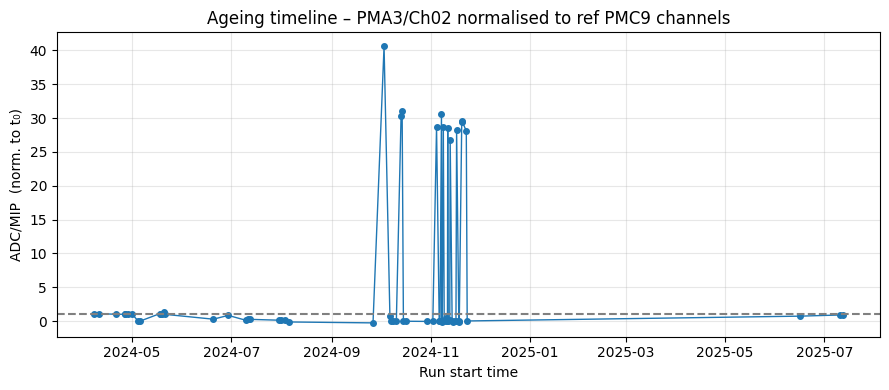

In [41]:
# Cell 5 – visualise ------------------------------------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
plt.plot(df["time"], df["rel_gain"], "o-", ms=4, lw=1)
plt.axhline(1, ls="--", c="grey")
plt.title("Ageing timeline – PMA3/Ch02 normalised to ref PMC9 channels")
plt.ylabel("ADC/MIP  (norm. to t₀)")
plt.xlabel("Run start time")
plt.grid(alpha=.3)
plt.tight_layout()
plt.show()

In [43]:
df["rel_gain"].tail()

59    28.090406
60     0.029733
61     0.742384
62     0.915157
63     0.907777
Name: rel_gain, dtype: float64

In [44]:
# Cell X – compare target & refs at first vs last timestamp ---------------
import uproot, awkward as ak, numpy as np, pandas as pd
from itertools import islice

# ---- helper (same fitter used before) -----------------------------------
def channel_mu(tree, ch):
    arr = ak.to_numpy(tree["FT0DIGITSCH.QTCAmpl"].array(library="ak")[:, ch]
                      .to_numpy().flatten())
    return safe_mu(arr)

channels = [TARGET_CH] + REF_CHS
labels   = ["target"] + [f"ref{i+1}" for i in range(len(REF_CHS))]

summary  = []

for pos, lbl in zip([0, -1], ["first", "last"]):
    run_id   = df.iloc[pos]["run"]
    rootfile = DIG_DIR / f"run_{run_id}_ft0digits.root"
    with uproot.open(rootfile) as f:
        tree = f["o2sim/FT0DIGITSCH"]
        mus  = [channel_mu(tree, ch) for ch in channels]

    summary.append(
        pd.Series(dict(timestamp=pd.to_datetime(df.iloc[pos]["t_ms"], unit="ms"),
                       run=run_id, **dict(zip(labels, mus))),
                  name=lbl)
    )

compare = pd.concat(summary, axis=1).T
compare

timestamp     run      target        ref1        ref2  \
first         2024-04-07 17:13:04  549661  165.382555  132.071351  147.308496   
last   2025-07-12 07:37:39.856000  564562  173.747614  158.507426  144.265509   

             ref3  
first  128.894424  
last   150.254557

area:   0%|          | 0/198 [00:00<?, ?it/s]

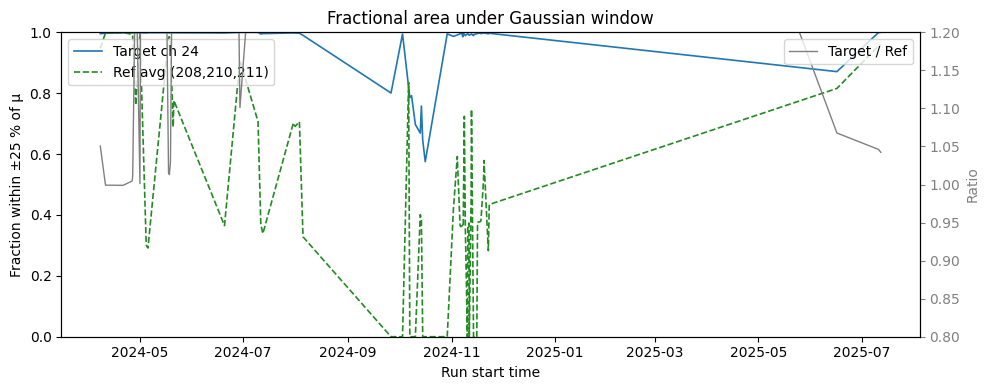

In [45]:
# ▣ Cell – fractional-area timeline  ───────────────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt, uproot, awkward as ak
from tqdm.auto import tqdm

# ---------------- parameters (consistent with earlier cells) --------------
FRAC_WINDOW = 0.25        # ±25 % around μ (keep in sync with safe_mu)
BINS_ADC    = np.arange(0, 4096, 8)   # fixed binning for stable area estimates

area_rows = []

for p in tqdm(sorted(DIG_DIR.glob("run_*_ft0digits.root")), desc="area"):
    run = int(p.name.split("_")[1])
    t_ms = RUN_META.get(run)
    if t_ms is None:
        continue

    with uproot.open(p) as f:
        qtc = f["o2sim/FT0DIGITSCH"]["FT0DIGITSCH.QTCAmpl"].array(library="ak")

    # -- helper that returns fractional area inside window ------------------
    def frac_area(ch, mu):
        arr = ak.to_numpy(qtc[:, ch].to_numpy().flatten())
        if arr.size == 0 or not np.isfinite(mu):
            return np.nan
        h, _ = np.histogram(arr, bins=BINS_ADC)
        centres = 0.5 * (BINS_ADC[:-1] + BINS_ADC[1:])
        mask = (centres >= (1-FRAC_WINDOW)*mu) & (centres <= (1+FRAC_WINDOW)*mu)
        area = h[mask].sum()
        return area / h.sum() if h.sum() else np.nan

    # target μ was already fitted – fetch from df to avoid refitting
    rec = df.loc[df.run == run]
    if rec.empty:
        continue
    mu_tgt = rec.mu_tgt.values[0]

    area_tgt = frac_area(TARGET_CH, mu_tgt)
    ref_areas = []
    for ch in REF_CHS:
        mu_ref = safe_mu(
            ak.to_numpy(qtc[:, ch].to_numpy().flatten()))   # quick fit
        ref_areas.append(frac_area(ch, mu_ref))
    ref_areas = [x for x in ref_areas if np.isfinite(x)]
    if not ref_areas:
        continue

    area_rows.append(dict(run=run, t_ms=t_ms,
                          frac_tgt=area_tgt,
                          frac_ref=np.mean(ref_areas)))

# convert to tidy DataFrame -------------------------------------------------
area_df = (pd.DataFrame(area_rows)
             .dropna()
             .sort_values("t_ms")
             .assign(time=lambda d: pd.to_datetime(d.t_ms, unit="ms"))
             .reset_index(drop=True))

# ----------------------  simple visualisation  ----------------------------
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(area_df.time, area_df.frac_tgt,  label="Target ch 24",  lw=1.2)
ax.plot(area_df.time, area_df.frac_ref,  label="Ref avg (208,210,211)",
        lw=1.2, ls="--", color="forestgreen")

ax2 = ax.twinx()
ax2.plot(area_df.time,
         area_df.frac_tgt / area_df.frac_ref,
         color="grey", lw=1, label="Target / Ref")
ax2.set_ylabel("Ratio", color="grey")
ax2.tick_params(axis="y", colors="grey")

ax.set_ylabel(f"Fraction within ±{int(FRAC_WINDOW*100)} % of μ")
ax.set_xlabel("Run start time")
ax.set_ylim(0, 2)            # fractions ∈ [0,1]
ax2.set_ylim(0.8, 1.2)       # tweak if needed
ax.set_title("Fractional area under Gaussian window")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

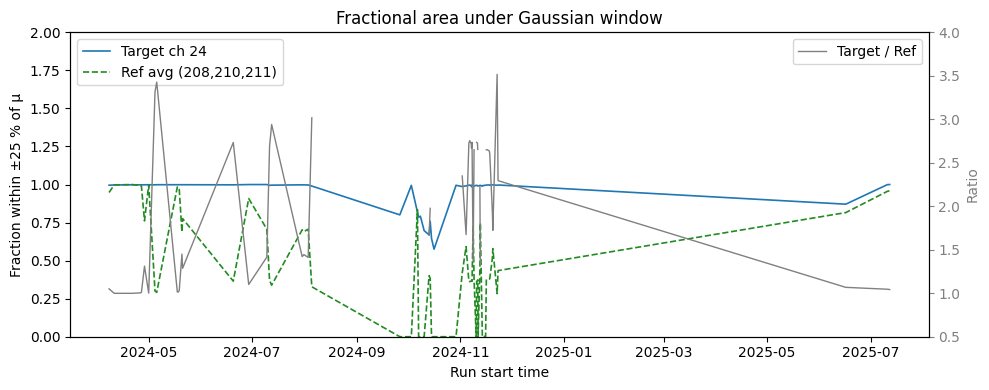

In [51]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(area_df.time, area_df.frac_tgt,  label="Target ch 24",  lw=1.2)
ax.plot(area_df.time, area_df.frac_ref,  label="Ref avg (208,210,211)",
        lw=1.2, ls="--", color="forestgreen")

ax2 = ax.twinx()
ax2.plot(area_df.time,
         area_df.frac_tgt / area_df.frac_ref,
         color="grey", lw=1, label="Target / Ref")
ax2.set_ylabel("Ratio", color="grey")
ax2.tick_params(axis="y", colors="grey")

ax.set_ylabel(f"Fraction within ±{int(FRAC_WINDOW*100)} % of μ")
ax.set_xlabel("Run start time")
ax.set_ylim(0, 2)            # fractions ∈ [0,1]
ax2.set_ylim(0.5, 4)       # tweak if needed
ax.set_title("Fractional area under Gaussian window")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [52]:
with uproot.open(root_path) as f:
    tree = f["o2sim/FT0DIGITSCH"]
    chid  = tree["FT0DIGITSCH.ChId"].array(library="ak")       # jagged uint16
    ampl  = tree["FT0DIGITSCH.QTCAmpl"].array(library="ak")    # jagged uint16

In [55]:
def channel_adc(chid_jagged, ampl_jagged, target):
    """
    Return a flat NumPy array of amplitudes for one linear channel.
    Works even when events contain variable numbers of digits.
    """
    mask   = (chid_jagged == target)           # jagged boolean
    sel    = ampl_jagged[mask]                 # still jagged
    flat   = ak.flatten(sel)                   # 1-D Awkward array
    return ak.to_numpy(flat)                   # → NumPy

In [56]:
# target
tgt_adc = channel_adc(chid, ampl, TARGET_CH)
mu_tgt, _ = fit_gaussian(tgt_adc)

# references
ref_mus = []
for ch in REF_CHS:
    ref_adc = channel_adc(chid, ampl, ch)
    mu_ref, _ = fit_gaussian(ref_adc)
    if np.isfinite(mu_ref):
        ref_mus.append(mu_ref)

Fit failed
Fit failed
Fit failed


In [74]:
import pathlib, re, gc
import numpy as np, uproot, awkward as ak
from tqdm.notebook import tqdm

DIG_DIR = pathlib.Path("../data/laserROOT/work/250714-123016/digits")
file_re = re.compile(r"run_(\d+)_ft0digits\.root")

bins_adc    = np.arange(0, 4096, 8, dtype=np.float32)        # 512 ADC bins
n_bins      = len(bins_adc) - 1
n_channels  = 256                                             # FT0 pad indexes
step_size   = "50 MB"

digit_files = sorted(DIG_DIR.glob("run_*_ft0digits.root"))
runs = np.empty(len(digit_files), dtype=np.int32)

# final tensor:  run × channel × bin
Hch = np.zeros((len(digit_files), n_channels, n_bins), dtype=np.uint32)

for i, p in enumerate(tqdm(digit_files, desc="per-channel hists")):
    runs[i] = int(file_re.match(p.name).group(1))

    with uproot.open(p) as f:
        tree = f["o2sim/FT0DIGITSCH"]

        for chunk in tree.iterate(
                ["FT0DIGITSCH.QTCAmpl", "FT0DIGITSCH.ChId"],
                library="ak", step_size=step_size):

            adc_flat  = ak.to_numpy(ak.flatten(chunk["FT0DIGITSCH.QTCAmpl"]))
            chid_flat = ak.to_numpy(ak.flatten(chunk["FT0DIGITSCH.ChId"]))

            # histogram each channel locally → add into global tensor
            for ch in np.unique(chid_flat):
                mask = chid_flat == ch
                if mask.any():
                    Hch[i, ch] += np.histogram(adc_flat[mask], bins=bins_adc)[0].astype(np.uint32)

    gc.collect()
print("Tensor Hch shape:", Hch.shape)   # (nRuns, 256, 512)

per-channel hists:   0%|          | 0/198 [00:00<?, ?it/s]

Tensor Hch shape: (198, 256, 511)


In [99]:
# Cell ▸ ageing timeline  (target ch 24 vs refs 208/210/211)
import numpy as np, pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# -------------------------------------------------------------------
BIN_CENTRES = 0.5 * (BINS_ADC[:-1] + BINS_ADC[1:])        # 512 centres
TGT_CH      = 24                                          # PMA3/Ch02
REF_CHS     = [208, 210, 211]                             # PMC9/Ch05,07,08
FRAC        = 0.25                                        # ±25 % fit window
# -------------------------------------------------------------------

def gauss(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def fit_mu(hist, frac=FRAC):
    """Return μ from a Gaussian fit on a fractional slice; np.nan if fail."""
    if hist.sum() < 50:        # too few entries → unreliable
        return np.nan

    x_peak = BIN_CENTRES[np.argmax(hist)]
    for scale in (frac, 0.35, 0.45, 0.60):
        m = (BIN_CENTRES >= (1 - scale) * x_peak) & (BIN_CENTRES <= (1 + scale) * x_peak)
        if hist[m].sum() < 10:         # still too few points
            continue
        try:
            p0   = (hist[m].max(), x_peak, 160.)
            popt, _ = curve_fit(gauss, BIN_CENTRES[m], hist[m], p0=p0,
                                maxfev=4000, bounds=([0, 0, 0], np.inf))
            return popt[1]             # μ
        except RuntimeError:
            pass
    return np.nan

records = []
for i in tqdm(range(len(runs)), desc="fits"):
    h_tgt = Hch[i, TGT_CH]
    mu_tgt = fit_mu(h_tgt)

    mu_refs = [fit_mu(Hch[i, ch]) for ch in REF_CHS]
    mu_ref_avg = np.nanmean(mu_refs)

    if np.isfinite(mu_tgt) and np.isfinite(mu_ref_avg):
        records.append(dict(run=runs[i],
                            index=i,
                            mu_tgt=mu_tgt,
                            mu_ref=mu_ref_avg))

df = pd.DataFrame(records).sort_values("index").reset_index(drop=True)

# --- baseline normalisation (first valid point) ---------------------------
baseline = (df.loc[0, "mu_tgt"] / df.loc[0, "mu_ref"])
df["aging"] = (df["mu_tgt"] / df["mu_ref"]) / baseline

print("First rows:")
display(df.head())

fits:   0%|          | 0/198 [00:00<?, ?it/s]

/tmp/ipykernel_9079/3491910286.py:42: RuntimeWarning: Mean of empty slice
  mu_ref_avg = np.nanmean(mu_refs)
/tmp/ipykernel_9079/3491910286.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gauss, BIN_CENTRES[m], hist[m], p0=p0,


First rows:


run  index      mu_tgt  mu_ref     aging
0  549661      5  163.436523     4.0  1.000000
1  549749      6  173.611473     4.0  1.062256
2  549824      7  182.994799     4.0  1.119669
3  549853      8  183.104426     4.0  1.120340
4  549958      9  171.819017     4.0  1.051289

In [100]:
run_meta = pd.read_json("../data/laserROOT/laser_runs.json")
df = df.merge(run_meta, how="left", on="run")
df["time"] = pd.to_datetime(df["start_ms"], unit="ms")

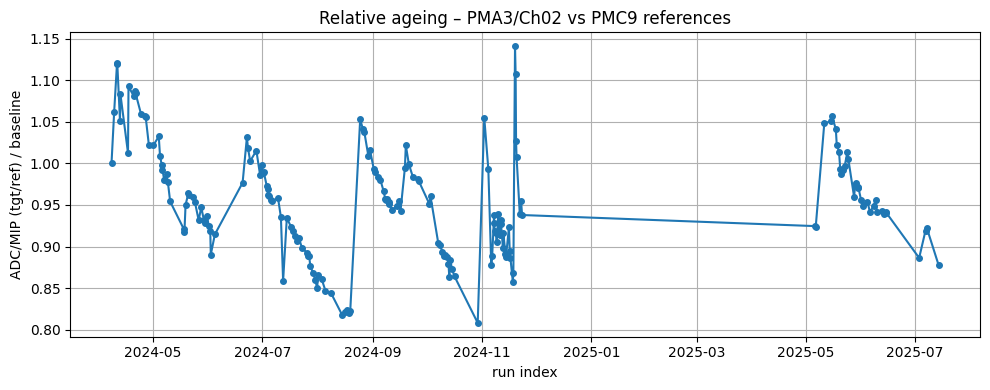

In [101]:
plt.figure(figsize=(10,4))
plt.plot(df["time"], df["aging"], "o-", ms=4)
plt.xlabel("run index")
plt.ylabel("ADC/MIP (tgt/ref) / baseline")
plt.title("Relative ageing – PMA3/Ch02 vs PMC9 references")
plt.grid()
plt.tight_layout()
plt.show()

In [86]:
# ╔════════════════════════════════════════════════════════════════════════╗
# ║  CELL A – build df with ageing ratio  (makes column "norm")           ║
# ╚════════════════════════════════════════════════════════════════════════╝
import pandas as pd, numpy as np
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
import math, gc

# -- helper ---------------------------------------------------------------
def gauss(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def fit_mu(counts, bins):
    """Return Gaussian mean μ (NaN if fit fails)."""
    if counts.sum() < 50:          # skip tiny histograms
        return np.nan
    x  = 0.5 * (bins[:-1] + bins[1:])
    p0 = (counts.max(), x[counts.argmax()], 50.)
    try:
        popt, _ = curve_fit(gauss, x, counts, p0=p0, maxfev=6000)
        return popt[1]             # μ
    except Exception:
        return np.nan

# -- 1. metadata table ----------------------------------------------------
meta_txt = """ch,pm,ring
0,PMA5,A inner
1,PMA5,A inner
2,PMA5,A inner
3,PMA5,A inner
4,PMA6,A inner
5,PMA6,A inner
6,PMA6,A inner
7,PMA6,A inner
8,PMA7,A inner
9,PMA7,A inner
10,PMA7,A inner
11,PMA7,A inner
12,PMA0,A inner
13,PMA0,A inner
14,PMA0,A inner
15,PMA0,A inner
16,PMA1,A inner
17,PMA1,A inner
18,PMA1,A inner
19,PMA1,A inner
20,PMA2,A inner
21,PMA2,A inner
22,PMA2,A inner
23,PMA2,A inner
24,PMA3,A inner
25,PMA3,A inner
26,PMA3,A inner
27,PMA3,A inner
28,PMA4,A inner
29,PMA4,A inner
30,PMA4,A inner
31,PMA4,A inner
32,PMA5,A outer
33,PMA5,A outer
34,PMA5,A outer
35,PMA5,A outer
36,PMA6,A outer
37,PMA6,A outer
38,PMA6,A outer
39,PMA6,A outer
40,PMA6,A outer
41,PMA6,A outer
42,PMA6,A outer
43,PMA6,A outer
44,PMA7,A outer
45,PMA7,A outer
46,PMA7,A outer
47,PMA7,A outer
48,PMA7,A outer
49,PMA7,A outer
50,PMA7,A outer
51,PMA7,A outer
52,PMA0,A outer
53,PMA0,A outer
54,PMA0,A outer
55,PMA0,A outer
56,PMA0,A outer
57,PMA0,A outer
58,PMA0,A outer
59,PMA0,A outer
60,PMA1,A outer
61,PMA1,A outer
62,PMA1,A outer
63,PMA1,A outer
64,PMA1,A outer
65,PMA1,A outer
66,PMA1,A outer
67,PMA1,A outer
68,PMA2,A outer
69,PMA2,A outer
70,PMA2,A outer
71,PMA2,A outer
72,PMA2,A outer
73,PMA2,A outer
74,PMA2,A outer
75,PMA2,A outer
76,PMA3,A outer
77,PMA3,A outer
78,PMA3,A outer
79,PMA3,A outer
80,PMA3,A outer
81,PMA3,A outer
82,PMA3,A outer
83,PMA3,A outer
84,PMA4,A outer
85,PMA4,A outer
86,PMA4,A outer
87,PMA4,A outer
88,PMA4,A outer
89,PMA4,A outer
90,PMA4,A outer
91,PMA4,A outer
92,PMA5,A outer
93,PMA5,A outer
94,PMA5,A outer
95,PMA5,A outer
96,PMC3,C inner
97,PMC3,C inner
98,PMC3,C inner
99,PMC3,C inner
100,PMC8,C inner
101,PMC8,C inner
102,PMC8,C inner
103,PMC8,C inner
104,PMC2,C inner
105,PMC2,C inner
106,PMC2,C inner
107,PMC2,C inner
108,PMC1,C inner
109,PMC1,C inner
110,PMC1,C inner
111,PMC1,C inner
112,PMC8,C inner
113,PMC8,C inner
114,PMC8,C inner
115,PMC8,C inner
116,PMC0,C inner
117,PMC0,C inner
118,PMC0,C inner
119,PMC0,C inner
120,PMC7,C inner
121,PMC7,C inner
122,PMC7,C inner
123,PMC7,C inner
124,PMC8,C outer
125,PMC8,C outer
126,PMC8,C outer
127,PMC8,C outer
128,PMC6,C inner
129,PMC6,C inner
130,PMC6,C inner
131,PMC6,C inner
132,PMC5,C inner
133,PMC5,C inner
134,PMC5,C inner
135,PMC5,C inner
136,PMC9,C inner
137,PMC9,C inner
138,PMC9,C inner
139,PMC9,C inner
140,PMC4,C inner
141,PMC4,C inner
142,PMC4,C inner
143,PMC4,C inner
144,PMC3,C outer
145,PMC3,C outer
146,PMC3,C outer
147,PMC3,C outer
148,PMC3,C outer
149,PMC3,C outer
150,PMC3,C outer
151,PMC3,C outer
152,PMC2,C outer
153,PMC2,C outer
154,PMC2,C outer
155,PMC2,C outer
156,PMC2,C outer
157,PMC2,C outer
158,PMC2,C outer
159,PMC2,C outer
160,PMC1,C outer
161,PMC1,C outer
162,PMC1,C outer
163,PMC1,C outer
164,PMC1,C outer
165,PMC1,C outer
166,PMC1,C outer
167,PMC1,C outer
168,PMC0,C outer
169,PMC0,C outer
170,PMC0,C outer
171,PMC0,C outer
172,PMC0,C outer
173,PMC0,C outer
174,PMC0,C outer
175,PMC0,C outer
176,PMC7,C outer
177,PMC7,C outer
178,PMC7,C outer
179,PMC7,C outer
180,PMC7,C outer
181,PMC7,C outer
182,PMC7,C outer
183,PMC7,C outer
184,PMC6,C outer
185,PMC6,C outer
186,PMC6,C outer
187,PMC6,C outer
188,PMC6,C outer
189,PMC6,C outer
190,PMC6,C outer
191,PMC6,C outer
192,PMC5,C outer
193,PMC5,C outer
194,PMC5,C outer
195,PMC5,C outer
196,PMC5,C outer
197,PMC5,C outer
198,PMC5,C outer
199,PMC5,C outer
200,PMC4,C outer
201,PMC4,C outer
202,PMC4,C outer
203,PMC4,C outer
204,PMC4,C outer
205,PMC4,C outer
206,PMC4,C outer
207,PMC4,C outer
208,PMC9,LCS
209,PMC9,LCS
210,PMC9,LCS
211,PMC9,LCS"""
meta = pd.read_csv(pd.io.common.StringIO(meta_txt))
meta["ring"] = meta["ring"].str.replace("_", " ")

# -- 2. fit μ for every (run, ch) -----------------------------------------
n_runs = Hch.shape[0]
mu     = np.full((n_runs, n_channels), np.nan, dtype=np.float32)

for i in tqdm(range(n_runs), desc="fitting μ"):
    for ch in range(n_channels):
        cts = Hch[i, ch]
        if cts.sum():
            mu[i, ch] = fit_mu(cts, bins_adc)

# -- 3. build the long data-frame -----------------------------------------
df = (pd.DataFrame(mu, columns=[f"ch{c}" for c in range(n_channels)])
        .assign(run=runs)
        .melt(id_vars="run", var_name="ch", value_name="mu")
        .assign(ch=lambda d: d["ch"].str[2:].astype(int))
        .merge(meta, on="ch", how="left"))

# -- 4. compute reference median & ageing ratio ---------------------------
REF_CHS = [208, 210, 211]
ref_mu  = (df[df["ch"].isin(REF_CHS)]
             .groupby("run")["mu"]
             .median()
             .rename("mu_ref"))

df = df.merge(ref_mu, on="run", how="left")

# *first-run* baseline per channel
baseline = (df.groupby("ch")["mu"]
              .first()
              .rename("mu0"))
df = df.merge(baseline, on="ch", how="left")

df["norm"] = df["mu"] / df["mu_ref"] / df["mu0"]

# -- 5. convert run → time (you already have RUN_META dict) ---------------
df["time"] = pd.to_datetime(df["run"].map(RUN_META), unit="ms")

print("Data-frame ready:", df.shape, "rows; columns:", list(df.columns))
gc.collect()

fitting μ:   0%|          | 0/198 [00:00<?, ?it/s]

/tmp/ipykernel_9079/2452209274.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gauss, x, counts, p0=p0, maxfev=6000)
/home/mvishiu11/default/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:499: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/home/mvishiu11/default/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:499: RuntimeWarning: invalid value encountered in matmul
  cov_x = invR @ invR.T


Data-frame ready: (50688, 9) rows; columns: ['run', 'ch', 'mu', 'pm', 'ring', 'mu_ref', 'mu0', 'norm', 'time']


2420

⚠  dropped 12188 rows without valid norm


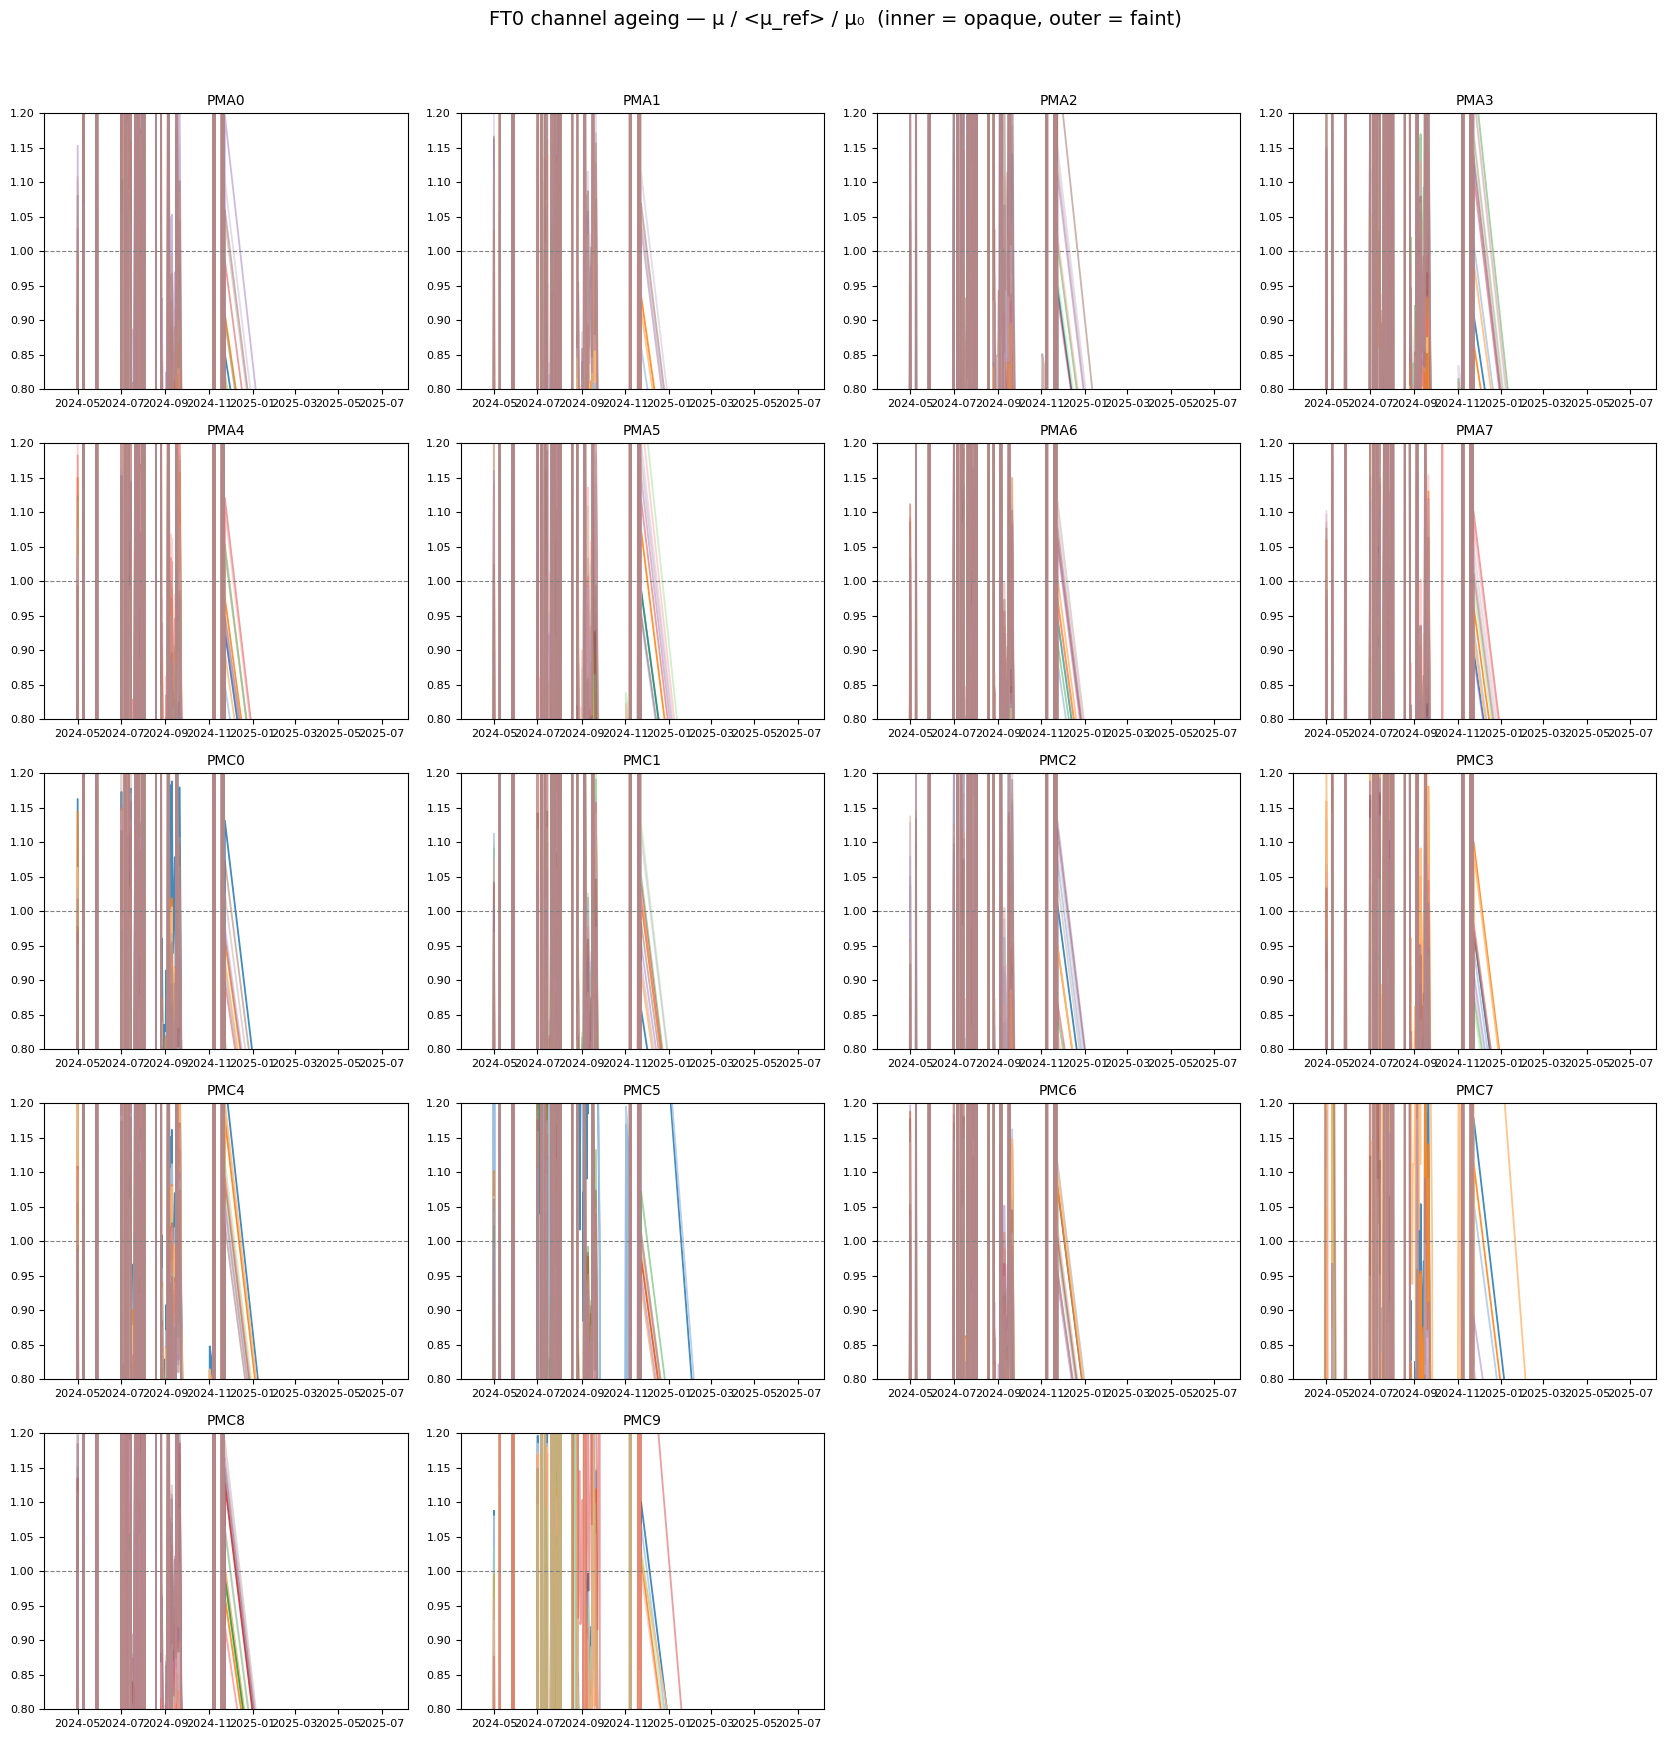

In [87]:
# ╔════════════════════════════════════════════════════════════════════════╗
# ║  CELL B – PM-by-PM ageing curves (clearer & auto-grid)                ║
# ╚════════════════════════════════════════════════════════════════════════╝
import matplotlib.pyplot as plt, seaborn as sns, math

bad_refs = df["norm"].isna().sum()
print(f"⚠  dropped {bad_refs} rows without valid norm")

df_clean = df.dropna(subset=["norm"])

pms   = sorted(df_clean["pm"].dropna().unique())
cols  = 4
rows  = math.ceil(len(pms) / cols)
palette = sns.color_palette("tab20", 12)

plt.figure(figsize=(cols * 4.2, rows * 3.4))
plt.subplots_adjust(hspace=0.4, wspace=0.25)

for i, pm in enumerate(pms, 1):
    ax = plt.subplot(rows, cols, i)
    sub = df_clean[df_clean["pm"] == pm]
    for j, (ch, g) in enumerate(sub.groupby("ch", sort=True)):
        ax.plot(g["time"], g["norm"],
                lw=1.3, color=palette[j % len(palette)],
                alpha=0.85 if g["ring"].iloc[0].endswith("inner") else 0.45)
    ax.set_title(pm, fontsize=10)
    ax.axhline(1, ls="--", lw=0.8, color="grey")
    ax.set_ylim(0.8, 1.2)
    ax.tick_params(labelsize=8)

plt.suptitle("FT0 channel ageing — μ / <μ_ref> / μ₀  (inner = opaque, outer = faint)",
             y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## Changed approach

In [ ]:
import pathlib, re, gc
import numpy as np, uproot, awkward as ak
from tqdm.notebook import tqdm

DIG_DIR = pathlib.Path("../data/laserROOT/work/250714-123016/digits")
file_re = re.compile(r"run_(\d+)_ft0digits\.root")

bins_adc    = np.arange(0, 4096, 8, dtype=np.float32)        # 512 ADC bins
n_bins      = len(bins_adc) - 1
n_channels  = 256                                             # FT0 pad indexes
step_size   = "50 MB"

digit_files = sorted(DIG_DIR.glob("run_*_ft0digits.root"))
runs = np.empty(len(digit_files), dtype=np.int32)

# final tensor:  run × channel × bin
Hch = np.zeros((len(digit_files), n_channels, n_bins), dtype=np.uint32)

for i, p in enumerate(tqdm(digit_files, desc="per-channel hists")):
    runs[i] = int(file_re.match(p.name).group(1))

    with uproot.open(p) as f:
        tree = f["o2sim/FT0DIGITSCH"]

        for chunk in tree.iterate(
                ["FT0DIGITSCH.QTCAmpl", "FT0DIGITSCH.ChId"],
                library="ak", step_size=step_size):

            adc_flat  = ak.to_numpy(ak.flatten(chunk["FT0DIGITSCH.QTCAmpl"]))
            chid_flat = ak.to_numpy(ak.flatten(chunk["FT0DIGITSCH.ChId"]))

            # histogram each channel locally → add into global tensor
            for ch in np.unique(chid_flat):
                mask = chid_flat == ch
                if mask.any():
                    Hch[i, ch] += np.histogram(adc_flat[mask], bins=bins_adc)[0].astype(np.uint32)

    gc.collect()
print("Tensor Hch shape:", Hch.shape)   # (nRuns, 256, 512)

In [2]:
# ▸ Cell A – fit μ per run (target ch 24 vs refs 208,210,211)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

TGT_CH   = 24
REF_CHS  = [208, 210, 211]
ADC_REF_RANGE = (150, 600)      # hard window for references
FRAC     = 0.25                 # ±25 % slice around the peak
BIN_W    = 8                    # ADC bin width used in Hch

def bin_centres_for(hist_len, bin_w=BIN_W):
    """Return an array of bin centres that matches *this* histogram length."""
    return np.arange(hist_len, dtype=np.float32) * bin_w + bin_w/2

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2))

def fit_mu(hist, is_ref=False, frac=FRAC):
    """Gaussian μ (np.nan on failure).  Refs pre-masked to 150–600 ADC."""
    if hist.sum() < 50:
        return np.nan

    x = bin_centres_for(len(hist))
    if is_ref:
        lo, hi = ADC_REF_RANGE
        m = (x >= lo) & (x <= hi)
        hist, x = hist[m], x[m]
        if hist.sum() < 30:
            return np.nan

    peak = x[np.argmax(hist)]
    for f in (frac, 0.35, 0.45, 0.60):
        m = (x >= (1-f)*peak) & (x <= (1+f)*peak)
        if hist[m].sum() < 10:
            continue
        try:
            p0 = (hist[m].max(), peak, 160.)
            popt, _ = curve_fit(
                gauss, x[m], hist[m], p0=p0, maxfev=5000,
                bounds=([0,   0,   0], [np.inf, 4096, 4096])
            )
            return popt[1]                   # μ
        except RuntimeError:
            pass
    return np.nan


records = []
for i in tqdm(range(len(runs)), desc="Gaussian fits"):
    mu_tgt  = fit_mu(Hch[i, TGT_CH], is_ref=False)
    mu_refs = [fit_mu(Hch[i, ch], is_ref=True) for ch in REF_CHS]
    mu_ref  = np.nanmean(mu_refs)

    if np.isfinite(mu_tgt) and np.isfinite(mu_ref):
        records.append({"run": runs[i], "idx": i,
                        "mu_tgt": mu_tgt, "mu_ref": mu_ref})

df = (pd.DataFrame(records)
        .sort_values("idx")
        .reset_index(drop=True))

# baseline-normalise to the very first accepted run
baseline = df.loc[0, "mu_tgt"] / df.loc[0, "mu_ref"]
df["aging"] = (df["mu_tgt"] / df["mu_ref"]) / baseline

print(f"Successfully fitted {len(df)}/{len(runs)} runs "
      f"({len(runs)-len(df)} skipped due to bad reference fits).")
df.head()

Gaussian fits:   0%|          | 0/198 [00:00<?, ?it/s]

/tmp/ipykernel_6964/2531017285.py:53: RuntimeWarning: Mean of empty slice
  mu_ref  = np.nanmean(mu_refs)


Successfully fitted 186/198 runs (12 skipped due to bad reference fits).


run  idx      mu_tgt      mu_ref     aging
0  549661    5  163.437496  327.626260  1.000000
1  549749    6  173.612734  328.460044  1.059561
2  549824    7  182.997800  329.441654  1.113511
3  549853    8  183.105951  330.477076  1.110678
4  549958    9  171.819406  326.018650  1.056469

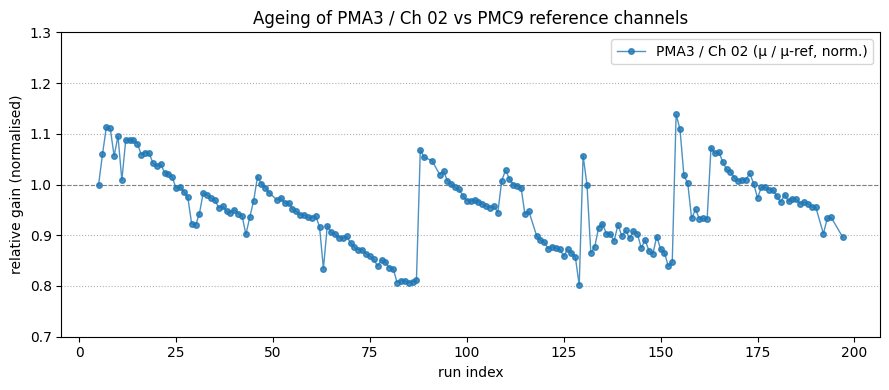

In [3]:
# ▸ Cell B – ageing curve visualisation
plt.figure(figsize=(9, 4))
plt.errorbar(df["idx"], df["aging"],
             fmt="o-", lw=1, ms=4, alpha=0.8, capsize=2,
             label="PMA3 / Ch 02 (μ / μ-ref, norm.)")
plt.axhline(1, color="grey", ls="--", lw=0.8)
plt.xlabel("run index")
plt.ylabel("relative gain (normalised)")
plt.title("Ageing of PMA3 / Ch 02 vs PMC9 reference channels")
plt.ylim(0.7, 1.3)
plt.grid(axis="y", ls=":")
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
run_meta = pd.read_json("../data/laserROOT/laser_runs.json")
df = df.merge(run_meta, how="left", on="run")
df["time"] = pd.to_datetime(df["start_ms"], unit="ms")

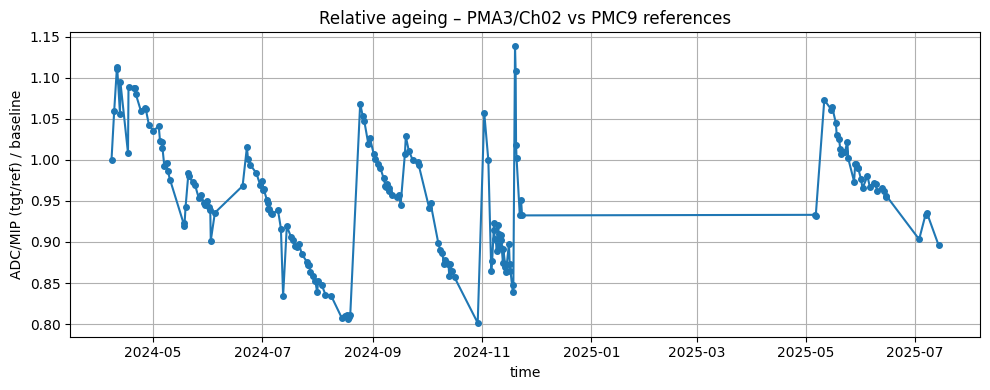

In [5]:
plt.figure(figsize=(10,4))
plt.plot(df["time"], df["aging"], "o-", ms=4)
plt.xlabel("time")
plt.ylabel("ADC/MIP (tgt/ref) / baseline")
plt.title("Relative ageing – PMA3/Ch02 vs PMC9 references")
plt.grid()
plt.tight_layout()
plt.show()

In [6]:
# ▸ Cell 1 – compute BOTH curves (old vs new)
import numpy as np, pandas as pd
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

TGT_CH   = 24
REF_CHS  = [208, 210, 211]
FRAC     = 0.25
BIN_W    = 8
ADC_REF_RANGE = (150, 600)     # new approach only

def centres(n):      # fast helper: correct length every time
    return np.arange(n, dtype=np.float32)*BIN_W + BIN_W/2

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def mu_fit(hist, ref=False, frac=FRAC):
    """Gaussian μ or nan.  If *ref*→ pre-mask to ADC_REF_RANGE."""
    if hist.sum() < 50:                 # too few entries
        return np.nan
    x = centres(len(hist))
    if ref:
        lo, hi = ADC_REF_RANGE
        m = (x >= lo) & (x <= hi)
        hist, x = hist[m], x[m]
        if hist.sum() < 30:
            return np.nan
    peak = x[np.argmax(hist)]
    for f in (frac, 0.35, 0.45, 0.60):
        m = (x >= (1-f)*peak) & (x <= (1+f)*peak)
        if hist[m].sum() < 10:
            continue
        try:
            p0 = (hist[m].max(), peak, 160.)
            return curve_fit(
                gauss, x[m], hist[m], p0=p0, maxfev=4000,
                bounds=([0, 0, 0], np.inf)
            )[0][1]
        except RuntimeError:
            pass
    return np.nan

records = []
for i in tqdm(range(len(runs)), desc="Gaussian fits"):
    h_tgt = Hch[i, TGT_CH]
    mu_tgt_old = mu_fit(h_tgt, ref=False)            # same for both
    mu_tgt_new = mu_tgt_old                          # identical target curve

    # ------- references --------
    mu_ref_old = np.nanmean([mu_fit(Hch[i, ch], ref=False) for ch in REF_CHS])
    mu_ref_new = np.nanmean([mu_fit(Hch[i, ch], ref=True ) for ch in REF_CHS])

    records.append(dict(run=runs[i], idx=i,
                        mu_tgt=mu_tgt_old,
                        mu_ref_old=mu_ref_old,
                        mu_ref_new=mu_ref_new))

df = (pd.DataFrame(records)
        .dropna(subset=["mu_ref_old","mu_ref_new"])   # drop runs with broken refs
        .sort_values("idx")
        .reset_index(drop=True))

# --- normalise both curves to their own first point ----------------------
base_old = df.loc[0, "mu_tgt"] / df.loc[0, "mu_ref_old"]
base_new = df.loc[0, "mu_tgt"] / df.loc[0, "mu_ref_new"]

df["aging_old"] = (df["mu_tgt"] / df["mu_ref_old"]) / base_old
df["aging_new"] = (df["mu_tgt"] / df["mu_ref_new"]) / base_new
print(df.head())

Gaussian fits:   0%|          | 0/198 [00:00<?, ?it/s]

/tmp/ipykernel_6964/592765318.py:51: RuntimeWarning: Mean of empty slice
  mu_ref_old = np.nanmean([mu_fit(Hch[i, ch], ref=False) for ch in REF_CHS])
/tmp/ipykernel_6964/592765318.py:52: RuntimeWarning: Mean of empty slice
  mu_ref_new = np.nanmean([mu_fit(Hch[i, ch], ref=True ) for ch in REF_CHS])
/tmp/ipykernel_6964/592765318.py:36: OptimizeWarning: Covariance of the parameters could not be estimated
  return curve_fit(


      run  idx      mu_tgt  mu_ref_old  mu_ref_new  aging_old  aging_new
0  549661    5  163.436523         4.0  327.626260   1.000000   1.000000
1  549749    6  173.611473         4.0  328.460044   1.062256   1.059560
2  549824    7  182.994799         4.0  329.441654   1.119669   1.113499
3  549853    8  183.104426         4.0  330.477076   1.120340   1.110675
4  549958    9  171.819017         4.0  326.018650   1.051289   1.056473


In [7]:
run_meta = pd.read_json("../data/laserROOT/laser_runs.json")
df = df.merge(run_meta, how="left", on="run")
df["time"] = pd.to_datetime(df["start_ms"], unit="ms")

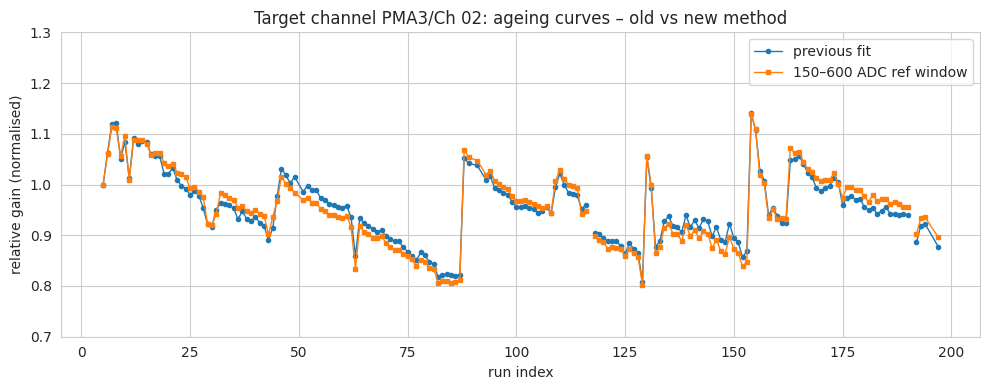

Δ (new−old) mean = -0.0004  RMS = 0.0152


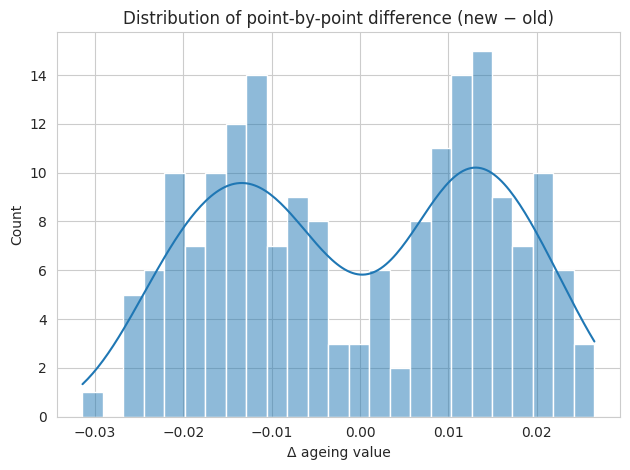

In [8]:
# ▸ Cell 2 – visual & numeric comparison
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(10,4))
plt.plot(df["idx"], df["aging_old"], "o-", lw=1, ms=3, label="previous fit")
plt.plot(df["idx"], df["aging_new"], "s-", lw=1, ms=3, label="150–600 ADC ref window")
plt.xlabel("run index")
plt.ylabel("relative gain (normalised)")
plt.title("Target channel PMA3/Ch 02: ageing curves – old vs new method")
plt.ylim(0.7, 1.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- quantitative summary ------------------------------------------------
delta = df["aging_new"] - df["aging_old"]
print(f"Δ (new−old) mean = {delta.mean():+.4f}  "
      f"RMS = {delta.std():.4f}")
sns.histplot(delta, bins=25, kde=True)
plt.title("Distribution of point-by-point difference (new − old)")
plt.xlabel("Δ ageing value"); plt.tight_layout(); plt.show()

In [22]:
df = df.dropna()

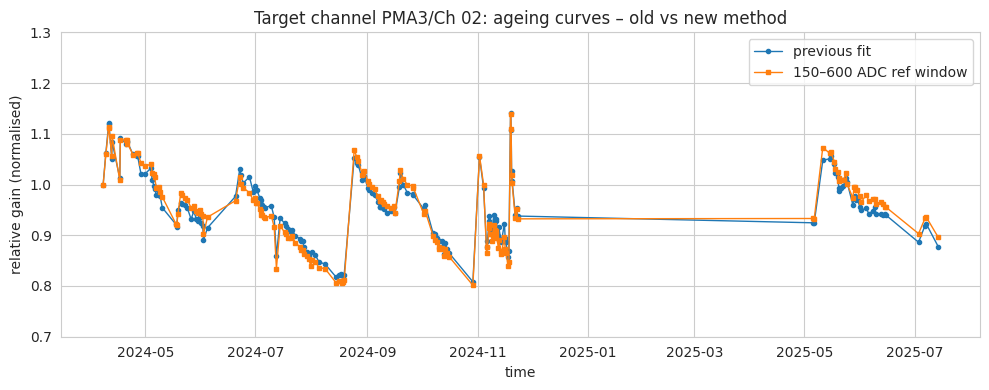

Δ (new−old) mean = -0.0004  RMS = 0.0152


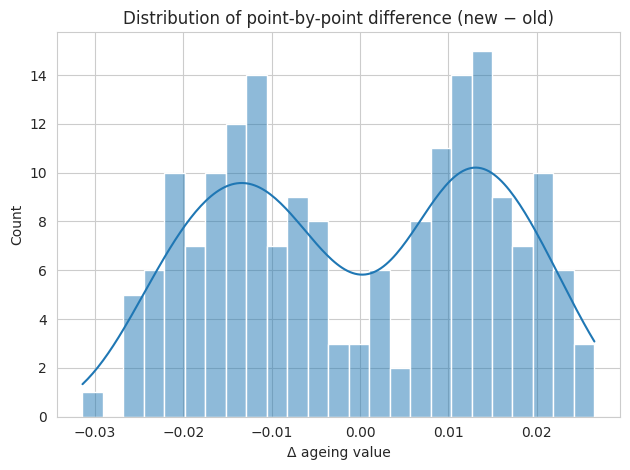

In [23]:
# ▸ Cell 2 – visual & numeric comparison
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(10,4))
plt.plot(df["time"], df["aging_old"], "o-", lw=1, ms=3, label="previous fit")
plt.plot(df["time"], df["aging_new"], "s-", lw=1, ms=3, label="150–600 ADC ref window")
plt.xlabel("time")
plt.ylabel("relative gain (normalised)")
plt.title("Target channel PMA3/Ch 02: ageing curves – old vs new method")
plt.ylim(0.7, 1.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- quantitative summary ------------------------------------------------
delta = df["aging_new"] - df["aging_old"]
print(f"Δ (new−old) mean = {delta.mean():+.4f}  "
      f"RMS = {delta.std():.4f}")
sns.histplot(delta, bins=25, kde=True)
plt.title("Distribution of point-by-point difference (new − old)")
plt.xlabel("Δ ageing value"); plt.tight_layout(); plt.show()

In [10]:
meta = pd.read_json("../data/laserROOT/laser_runs.json")      # run  start_ms
meta["year"] = pd.to_datetime(meta["start_ms"], unit="ms").dt.year

# 2) merge -> add a 'year' column to df
df = df.merge(meta[["run", "year"]], how="left", on="run")

# 3) subset to 2025
df_2025 = (df[df["year"] == 2025]
             .reset_index(drop=True))

print(f"kept {len(df_2025)} / {len(df)} rows that are from 2025")
display(df_2025.head())

kept 35 / 188 rows that are from 2025


run  idx      mu_tgt  mu_ref_old  mu_ref_new  aging_old  aging_new  \
0  562702  161  151.102590         4.0  324.636601   0.924534   0.933048   
1  562714  162  151.022335         4.0  324.817415   0.924043   0.932033   
2  562865  163  171.276205         4.0  319.992022   1.047968   1.072970   
3  562957  164  171.748135         4.0  324.439452   1.050855   1.061177   
4  562988  165  172.724262         4.0  325.192645   1.056828   1.064737   

        start_ms                    time  year  
0  1746490302275 2025-05-06 00:11:42.275  2025  
1  1746526057093 2025-05-06 10:07:37.093  2025  
2  1746938237696 2025-05-11 04:37:17.696  2025  
3  1747282071708 2025-05-15 04:07:51.708  2025  
4  1747313905231 2025-05-15 12:58:25.231  2025

In [20]:
df_2025 = df_2025.dropna()

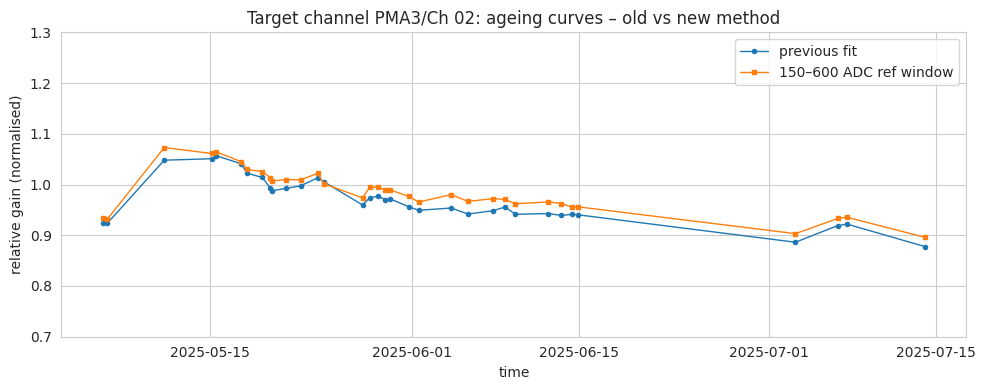

Δ (new−old) mean = +0.0157  RMS = 0.0067


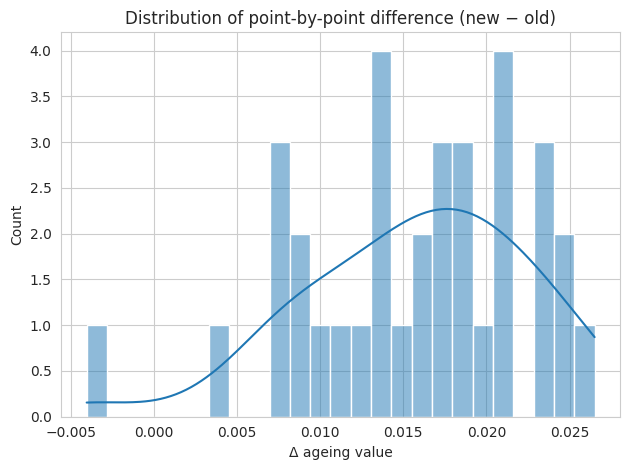

In [24]:
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(10,4))
plt.plot(df_2025["time"], df_2025["aging_old"], "o-", lw=1, ms=3, label="previous fit")
plt.plot(df_2025["time"], df_2025["aging_new"], "s-", lw=1, ms=3, label="150–600 ADC ref window")
plt.xlabel("time")
plt.ylabel("relative gain (normalised)")
plt.title("Target channel PMA3/Ch 02: ageing curves – old vs new method")
plt.ylim(0.7, 1.3)
plt.legend()
plt.tight_layout()
plt.show()

delta = df_2025["aging_new"] - df_2025["aging_old"]
print(f"Δ (new−old) mean = {delta.mean():+.4f}  "
      f"RMS = {delta.std():.4f}")
sns.histplot(delta, bins=25, kde=True)
plt.title("Distribution of point-by-point difference (new − old)")
plt.xlabel("Δ ageing value"); plt.tight_layout(); plt.show()

In [26]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ 0.  Imports & constants                                      ║
# ╚══════════════════════════════════════════════════════════════╝
import numpy as np, pandas as pd, math, gc, pathlib, uproot
import matplotlib.pyplot as plt, seaborn as sns
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

# already loaded objects ----------------------------------------------------
#   Hch   : shape (nRuns, 256, 511)   ADC histograms per run×channel
#   runs  : np.array of run numbers   (same order as Hch axis 0)
#   BINS  : bin edges  (len = 512)    from previous notebook
#   META  : DataFrame  ch → pm/ring   (built earlier from your table)
#   RUN_META : DataFrame  run → start_ms

REF_CHS   = [208, 210, 211]
FRAC      = 0.25
ADC_MASK  = (150, 600)
BIN_C     = 0.5*(bins_adc[:-1] + bins_adc[1:])     # length 511

# ╔══════════════════════════════════════════════════════════════╗
# ║ 1.  Gaussian μ-fit helpers                                   ║
# ╚══════════════════════════════════════════════════════════════╝
def _gauss(x, A, mu, s):
    return A*np.exp(-(x-mu)**2/(2*s**2))

def mu_fit(hist, *, for_ref=False, frac=FRAC):
    """Return Gaussian μ (or NaN) for one histogram array."""
    if hist.sum() < 50:
        return np.nan
    x, h = BIN_C, hist.copy()
    if for_ref:                         # mask 150-600 ADC region
        lo, hi = ADC_MASK
        sel    = (x >= lo) & (x <= hi)
        x, h   = x[sel], h[sel]
        if h.sum() < 30:
            return np.nan
    peak = x[np.argmax(h)]
    for f in (frac, .35, .45, .60):
        m = (x >= (1-f)*peak) & (x <= (1+f)*peak)
        if h[m].sum() < 10:         # still too noisy
            continue
        try:
            p0  = (h[m].max(), peak, 160.)
            mu  = curve_fit(_gauss, x[m], h[m], p0=p0,
                            maxfev=4000,
                            bounds=([0,0,0],[np.inf,np.inf,np.inf]))[0][1]
            return mu
        except RuntimeError:
            pass
    return np.nan

In [27]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ 2.  Build ageing tensor  (runs × channels)                   ║
# ╚══════════════════════════════════════════════════════════════╝
n_run, n_ch, _ = Hch.shape
age   = np.full((n_run, n_ch), np.nan, dtype=np.float32)   # final tensor
good  = np.ones_like(age, dtype=bool)                      # mask of valids

print("Gaussian fitting …")
for i in tqdm(range(n_run)):
    # reference μ for this run
    ref_mu = np.nanmean([mu_fit(Hch[i, ch], for_ref=True) for ch in REF_CHS])
    if not math.isfinite(ref_mu):
        good[i,:] = False          # whole run unusable
        continue

    # target μ for every channel ---------------------------------------
    for ch in range(n_ch):
        mu = mu_fit(Hch[i, ch], for_ref=False)
        if math.isfinite(mu):
            age[i, ch] = mu / ref_mu      # raw ratio (not yet normed)
        else:
            good[i, ch] = False

# drop runs that failed for *all* channels
valid_runs = good.any(axis=1)
age        = age[valid_runs]
runs_ok    = runs[valid_runs]

# normalise channel-wise to first valid run (t₀) --------------------------
t0 = age[0,:].copy()                      # (n_ch,)
age = age / t0            # broadcasting → ageing factor per channel/run

print("Tensor shape after clean-up:", age.shape)   # e.g. (180, 256)

Gaussian fitting …


  0%|          | 0/198 [00:00<?, ?it/s]

/tmp/ipykernel_6964/1926202956.py:11: RuntimeWarning: Mean of empty slice
  ref_mu = np.nanmean([mu_fit(Hch[i, ch], for_ref=True) for ch in REF_CHS])
/tmp/ipykernel_6964/2063078456.py:45: OptimizeWarning: Covariance of the parameters could not be estimated
  mu  = curve_fit(_gauss, x[m], h[m], p0=p0,


Tensor shape after clean-up: (188, 256)


In [28]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ 3.  Persist to disk (NumPy & ROOT)                           ║
# ╚══════════════════════════════════════════════════════════════╝
OUT_DIR = pathlib.Path("processed_ageing")
OUT_DIR.mkdir(exist_ok=True)

# ---- ROOT file: TTree per channel --------------------------------------
with uproot.recreate(OUT_DIR/"ageing_per_channel.root") as fout:
    for ch in range(n_ch):
        fout[f"ch{ch:03d}"] = {
            "run"   : runs_ok.astype("i4"),
            "aging" : age[:, ch].astype("f4"),
        }
print("Files written to", OUT_DIR.resolve())

Files written to /home/mvishiu11/Desktop/CERN/LHC-aging-analysis/notebooks/processed_ageing


## Visualization

In [22]:
meta_txt = """ch,pm,ring
0,PMA5,A inner
1,PMA5,A inner
2,PMA5,A inner
3,PMA5,A inner
4,PMA6,A inner
5,PMA6,A inner
6,PMA6,A inner
7,PMA6,A inner
8,PMA7,A inner
9,PMA7,A inner
10,PMA7,A inner
11,PMA7,A inner
12,PMA0,A inner
13,PMA0,A inner
14,PMA0,A inner
15,PMA0,A inner
16,PMA1,A inner
17,PMA1,A inner
18,PMA1,A inner
19,PMA1,A inner
20,PMA2,A inner
21,PMA2,A inner
22,PMA2,A inner
23,PMA2,A inner
24,PMA3,A inner
25,PMA3,A inner
26,PMA3,A inner
27,PMA3,A inner
28,PMA4,A inner
29,PMA4,A inner
30,PMA4,A inner
31,PMA4,A inner
32,PMA5,A outer
33,PMA5,A outer
34,PMA5,A outer
35,PMA5,A outer
36,PMA6,A outer
37,PMA6,A outer
38,PMA6,A outer
39,PMA6,A outer
40,PMA6,A outer
41,PMA6,A outer
42,PMA6,A outer
43,PMA6,A outer
44,PMA7,A outer
45,PMA7,A outer
46,PMA7,A outer
47,PMA7,A outer
48,PMA7,A outer
49,PMA7,A outer
50,PMA7,A outer
51,PMA7,A outer
52,PMA0,A outer
53,PMA0,A outer
54,PMA0,A outer
55,PMA0,A outer
56,PMA0,A outer
57,PMA0,A outer
58,PMA0,A outer
59,PMA0,A outer
60,PMA1,A outer
61,PMA1,A outer
62,PMA1,A outer
63,PMA1,A outer
64,PMA1,A outer
65,PMA1,A outer
66,PMA1,A outer
67,PMA1,A outer
68,PMA2,A outer
69,PMA2,A outer
70,PMA2,A outer
71,PMA2,A outer
72,PMA2,A outer
73,PMA2,A outer
74,PMA2,A outer
75,PMA2,A outer
76,PMA3,A outer
77,PMA3,A outer
78,PMA3,A outer
79,PMA3,A outer
80,PMA3,A outer
81,PMA3,A outer
82,PMA3,A outer
83,PMA3,A outer
84,PMA4,A outer
85,PMA4,A outer
86,PMA4,A outer
87,PMA4,A outer
88,PMA4,A outer
89,PMA4,A outer
90,PMA4,A outer
91,PMA4,A outer
92,PMA5,A outer
93,PMA5,A outer
94,PMA5,A outer
95,PMA5,A outer
96,PMC3,C inner
97,PMC3,C inner
98,PMC3,C inner
99,PMC3,C inner
100,PMC8,C inner
101,PMC8,C inner
102,PMC8,C inner
103,PMC8,C inner
104,PMC2,C inner
105,PMC2,C inner
106,PMC2,C inner
107,PMC2,C inner
108,PMC1,C inner
109,PMC1,C inner
110,PMC1,C inner
111,PMC1,C inner
112,PMC8,C inner
113,PMC8,C inner
114,PMC8,C inner
115,PMC8,C inner
116,PMC0,C inner
117,PMC0,C inner
118,PMC0,C inner
119,PMC0,C inner
120,PMC7,C inner
121,PMC7,C inner
122,PMC7,C inner
123,PMC7,C inner
124,PMC8,C outer
125,PMC8,C outer
126,PMC8,C outer
127,PMC8,C outer
128,PMC6,C inner
129,PMC6,C inner
130,PMC6,C inner
131,PMC6,C inner
132,PMC5,C inner
133,PMC5,C inner
134,PMC5,C inner
135,PMC5,C inner
136,PMC9,C inner
137,PMC9,C inner
138,PMC9,C inner
139,PMC9,C inner
140,PMC4,C inner
141,PMC4,C inner
142,PMC4,C inner
143,PMC4,C inner
144,PMC3,C outer
145,PMC3,C outer
146,PMC3,C outer
147,PMC3,C outer
148,PMC3,C outer
149,PMC3,C outer
150,PMC3,C outer
151,PMC3,C outer
152,PMC2,C outer
153,PMC2,C outer
154,PMC2,C outer
155,PMC2,C outer
156,PMC2,C outer
157,PMC2,C outer
158,PMC2,C outer
159,PMC2,C outer
160,PMC1,C outer
161,PMC1,C outer
162,PMC1,C outer
163,PMC1,C outer
164,PMC1,C outer
165,PMC1,C outer
166,PMC1,C outer
167,PMC1,C outer
168,PMC0,C outer
169,PMC0,C outer
170,PMC0,C outer
171,PMC0,C outer
172,PMC0,C outer
173,PMC0,C outer
174,PMC0,C outer
175,PMC0,C outer
176,PMC7,C outer
177,PMC7,C outer
178,PMC7,C outer
179,PMC7,C outer
180,PMC7,C outer
181,PMC7,C outer
182,PMC7,C outer
183,PMC7,C outer
184,PMC6,C outer
185,PMC6,C outer
186,PMC6,C outer
187,PMC6,C outer
188,PMC6,C outer
189,PMC6,C outer
190,PMC6,C outer
191,PMC6,C outer
192,PMC5,C outer
193,PMC5,C outer
194,PMC5,C outer
195,PMC5,C outer
196,PMC5,C outer
197,PMC5,C outer
198,PMC5,C outer
199,PMC5,C outer
200,PMC4,C outer
201,PMC4,C outer
202,PMC4,C outer
203,PMC4,C outer
204,PMC4,C outer
205,PMC4,C outer
206,PMC4,C outer
207,PMC4,C outer
208,PMC9,LCS
209,PMC9,LCS
210,PMC9,LCS
211,PMC9,LCS"""
META = pd.read_csv(pd.io.common.StringIO(meta_txt))

In [13]:
# ╔══════════════════════════════════════════════════════╗
# ║ 0.  Imports & optimized helpers                      ║
# ╚══════════════════════════════════════════════════════╝
import math, gc, pathlib, json
import numpy as np, pandas as pd, uproot
import matplotlib.pyplot as plt, seaborn as sns
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')  # Suppress curve_fit warnings if needed

# --- constants -----------------------------------------------------------------
BIN_W   = 8
CENTRES = np.arange(Hch.shape[2], dtype=np.float32)*BIN_W + BIN_W/2
REF_CHS = [208, 210, 211]
ADC_REF_RANGE = (150, 600)

# --- fast peak estimation helper -----------------------------------------------
def fast_peak_estimate(hist, *, for_ref):
    """
    Fast peak estimation using weighted centroid around maximum.
    Much faster than Gaussian fitting while maintaining good accuracy.
    """
    if hist.sum() < 50:
        return np.nan
    
    x = CENTRES
    h = hist.copy()
    
    if for_ref:
        lo, hi = ADC_REF_RANGE
        m = (x >= lo) & (x <= hi)
        if h[m].sum() < 30:
            return np.nan
        x, h = x[m], h[m]
    
    # Find peak position
    peak_idx = np.argmax(h)
    peak_val = x[peak_idx]
    
    # Try different fractions around peak (similar to original logic)
    for frac in (0.25, 0.35, 0.45, 0.60):
        mask = (x >= (1-frac)*peak_val) & (x <= (1+frac)*peak_val)
        if h[mask].sum() < 10:
            continue
        
        # Use weighted centroid for better accuracy than simple peak
        weights = h[mask]
        if weights.sum() > 0:
            return np.average(x[mask], weights=weights)
    
    # Fallback to simple peak if weighted centroid fails
    return peak_val

# --- parallel processing function ----------------------------------------------
def process_run(i):
    """
    Process a single run in parallel.
    Returns array of ages for all channels in this run.
    """
    # Compute reference μ from reference channels
    ref_values = []
    for ch in REF_CHS:
        mu_ref = fast_peak_estimate(Hch[i, ch], for_ref=True)
        if math.isfinite(mu_ref):
            ref_values.append(mu_ref)
    
    if len(ref_values) == 0:
        # No valid reference channels - return all NaN
        return np.full(Hch.shape[1], np.nan, dtype=np.float32)
    
    ref_mu = np.mean(ref_values)
    
    # Process all channels for this run
    run_ages = np.full(Hch.shape[1], np.nan, dtype=np.float32)
    for ch in range(Hch.shape[1]):
        mu = fast_peak_estimate(Hch[i, ch], for_ref=False)
        if math.isfinite(mu) and ref_mu > 0:
            run_ages[ch] = mu / ref_mu
    
    return run_ages

# ╔══════════════════════════════════════════════════════╗
# ║ 1.  Build channel-wise ageing tensor (OPTIMIZED)    ║
# ╚══════════════════════════════════════════════════════╝
n_run, n_ch, _ = Hch.shape

print("Computing μ_tgt/μ_ref for all runs (parallel + fast estimation)...")

# Process all runs in parallel
# n_jobs=-1 uses all available CPU cores
# You can set n_jobs=4 or similar if you want to limit CPU usage
age_list = Parallel(n_jobs=-1, backend='threading')(
    delayed(process_run)(i) for i in tqdm(range(n_run), desc="Processing runs")
)

# Convert to numpy array
age = np.array(age_list, dtype=np.float32)

# Keep runs that still have ≥1 finite value
good_run = np.isfinite(age).any(axis=1)
age = age[good_run]
runs_ok = runs[good_run]

print(f"Kept {np.sum(good_run)}/{n_run} runs with valid data")

# Normalise each channel to its first finite entry
print("Normalising channel-wise...")
for ch in tqdm(range(n_ch), desc="Normalizing channels"):
    finite_values = age[:, ch][np.isfinite(age[:, ch])]
    if finite_values.size > 0:
        first_finite = finite_values[0]
        if first_finite != 0:  # Avoid division by zero
            age[:, ch] /= first_finite

print(f"Final tensor shape: {age.shape}")
print(f"Finite values: {np.isfinite(age).sum()}/{age.size} ({100*np.isfinite(age).sum()/age.size:.1f}%)")

# Optional: Memory cleanup
gc.collect()

Computing μ_tgt/μ_ref for all runs (parallel + fast estimation)...


Processing runs:   0%|          | 0/198 [00:00<?, ?it/s]

Kept 188/198 runs with valid data
Normalising channel-wise...


Normalizing channels:   0%|          | 0/256 [00:00<?, ?it/s]

Final tensor shape: (188, 256)
Finite values: 38669/48128 (80.3%)


6467

In [15]:
# ╔══════════════════════════════════════════════════════╗
# ║ 2.  restrict to 2025 and save as ROOT                ║
# ╚══════════════════════════════════════════════════════╝
RUN_META = {int(r["run"]): r["start_ms"]
            for r in json.load(open("../data/laserROOT/laser_runs.json"))}

mask_2025 = np.array([str(r).startswith("56") and 2025 ==
                      pd.to_datetime(RUN_META.get(r,0), unit="ms").year
                      for r in runs_ok])
runs_25   = runs_ok[mask_2025]
age_25    = age[mask_2025]

print(f"→ {len(runs_25)} runs from 2025 remain after cut")

root_path = "ft0_aging_2025.root"
with uproot.recreate(root_path) as fout:
    for ch in range(n_ch):
        y = age_25[:, ch]
        if np.isfinite(y).sum() == 0:
            continue
        arr_run  = runs_25.astype(np.int32)
        arr_age  = y.astype(np.float32)
        fout.mktree(f"ch{ch:03d}",
                    {"run": "i4", "aging": "f4"}) \
            .extend({"run":  arr_run,
                     "aging": arr_age})

print("ROOT file written →", root_path)

→ 35 runs from 2025 remain after cut
ROOT file written → ft0_aging_2025.root


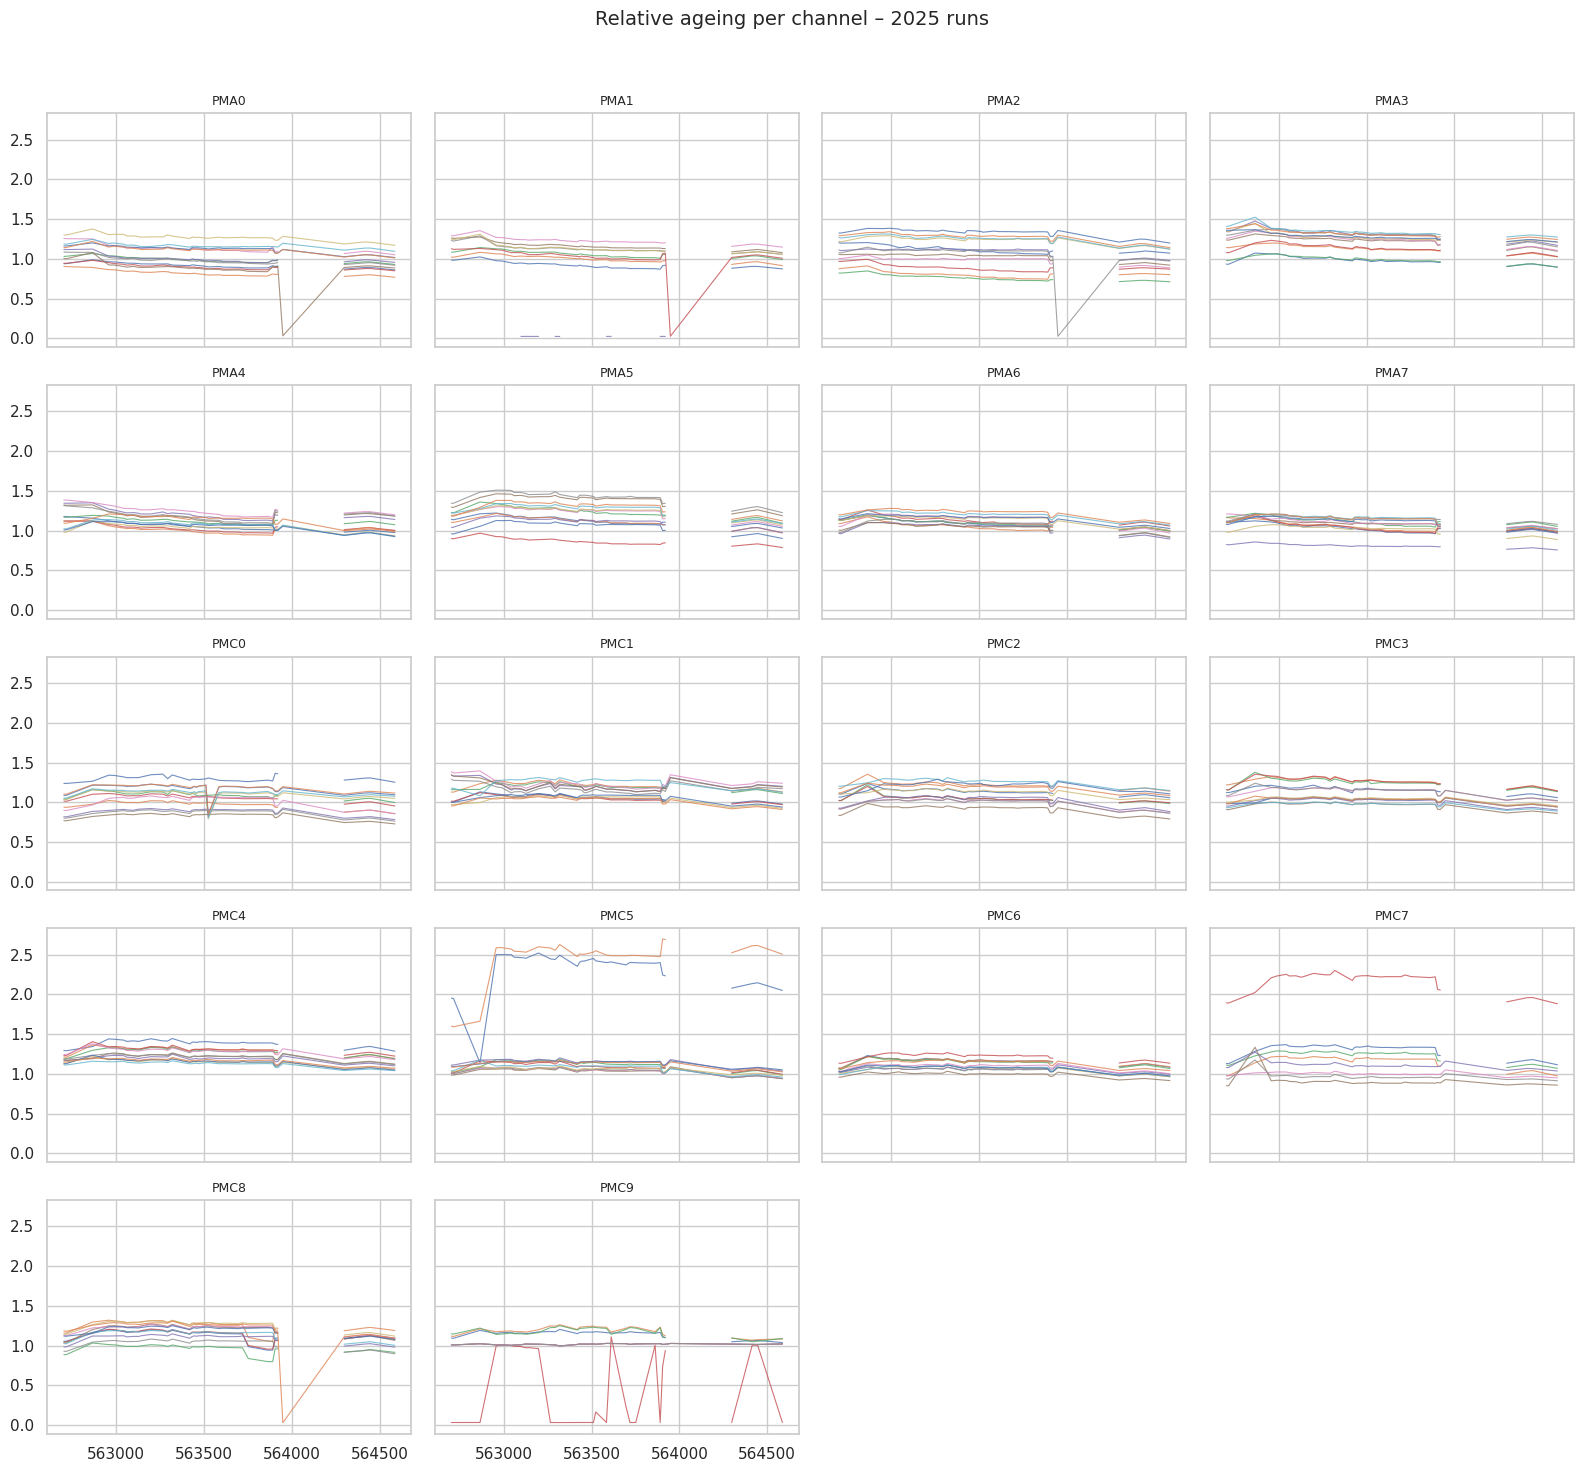

In [16]:
# ╔══════════════════════════════════════════════════════╗
# ║ 3.  quick PM-overview plot (only 2025)               ║
# ╚══════════════════════════════════════════════════════╝
sns.set_theme(style="whitegrid")
fig_cols = 4
pms      = META["pm"].unique()
fig_rows = math.ceil(len(pms)/fig_cols)
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(fig_cols*4, fig_rows*3),
                         sharex=True, sharey=True)
axes = axes.ravel()

for i_pm, pm in enumerate(sorted(pms)):
    ax   = axes[i_pm]
    chans = META.loc[META["pm"] == pm, "ch"].values
    for ch in chans:
        y = age_25[:, ch]
        if np.isfinite(y).sum() == 0:
            continue
        ax.plot(runs_25, y, lw=.8, alpha=.8)
    ax.set_title(pm, fontsize=9)

for ax in axes[len(pms):]:
    ax.remove()
fig.suptitle("Relative ageing per channel – 2025 runs", fontsize=14)
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

## Fancy Vis

In [23]:
import pandas as pd, re, textwrap, csv, pathlib, warnings

# ------------------------------------------------------------------
# 1) read the short meta table you pasted --------------------------
META["pm"]   = META["pm"].str.upper().str.replace("PM", "", regex=False)  # "PMA5" → "A5"
META["ring"] = META["ring"].str.strip().str.replace(" +", " ", regex=True)

# ------------------------------------------------------------------
# 2) read the *full* PM:CH specification  --------------------------
#    (you can EITHER  --- keep the long string inline  OR  load fta/ftc.csv files)
# ------------------------------------------------------------------
def parse_long_list(long_txt: str) -> pd.DataFrame:
    pat = re.compile(r"(\d+),P?M([AC]\d)/Ch(\d+)", re.I)
    rows = []
    for line in textwrap.dedent(long_txt).strip().splitlines():
        m = pat.match(line.strip())
        if m:
            ch_id = int(m.group(1))
            pm    = m.group(2).upper()           # "A6"
            ch    = m.group(3).zfill(2)          # "5" → "05"
            rows.append([ch_id, f"{pm}:CH{ch}"])
    return pd.DataFrame(rows, columns=["ch", "tag"])

def parse_layout_csvs(csv_paths) -> pd.DataFrame:
    rows = []
    for csv_path in csv_paths:
        with open(csv_path, newline="", encoding="utf-8") as f:
            for r in csv.DictReader(f):
                key = r["PM:Channel"].strip()
                # convert "A6:CH12" → linear id later
                rows.append(key)
    # we still need the linear id → derive from META + channel number:
    pat = re.compile(r"([AC]\d):CH(\d\d)")
    chan_map = {}
    for _, row in META.iterrows():   # build pm→list of unused channel ids
        chan_map.setdefault(row["pm"], []).append(row["ch"])
    linear_rows = []
    for key in rows:
        m = pat.match(key)
        pm = m.group(1)
        chno = int(m.group(2))
        # pick the *matching* linear id whose order in META matches CH01…CH12
        try:
            ch_id = sorted(chan_map[pm])[chno-1]
        except (KeyError, IndexError):
            warnings.warn(f"cannot match {key} to linear id — skipped")
            continue
        linear_rows.append([ch_id, key])
    return pd.DataFrame(linear_rows, columns=["ch", "tag"])

# ------- Choose ONE of the two loaders -----------------------------------
# FULL = parse_long_list(long_txt_from_earlier)
FULL = parse_layout_csvs(["../data/fta.csv", "../data/ftc.csv"])

# ------------------------------------------------------------------
# 3) merge:  ch  →  tag   +   pm,ring  ------------------------------
mapping_df = (META.merge(FULL, on="ch", how="left")
                   .dropna(subset=["tag"]))     # keep only matched channels

# quick sanity
print(mapping_df.head(), "\nmatched", len(mapping_df), "channels")

   ch  pm     ring      tag
0   0  A5  A inner  A5:CH01
1   1  A5  A inner  A5:CH02
2   2  A5  A inner  A5:CH03
3   3  A5  A inner  A5:CH04
4   4  A6  A inner  A6:CH01 
matched 208 channels


In [24]:
# linear id  →  ageing value   (already computed tensor `age`)
age_2025 = age_25              # (nRun, 256) from your previous cells
runs_2025 = runs_25

# -----------------------------------------------------------------
# ready-made look-ups
id2tag   = dict(zip(mapping_df["ch"], mapping_df["tag"]))     # 24 → "A3:CH02"
tag2id   = {v:k for k,v in id2tag.items()}

# side-split
sideA_tags = mapping_df[mapping_df["pm"].str.startswith("A")]["tag"].tolist()
sideC_tags = mapping_df[mapping_df["pm"].str.startswith("C")]["tag"].tolist()

In [25]:
def draw_grid(ax, vals, title, vmin=0.7, vmax=1.3, cmap="RdYlGn"):
    if not vals:
        ax.set_axis_off();  ax.set_title(title + " (no data)")
        return
    cm = plt.get_cmap(cmap)
    # draw rectangles
    for (r,c), v in vals.items():
        col = cm((v - vmin)/(vmax - vmin))
        ax.add_patch(plt.Rectangle((c-0.5, r-0.5), 1, 1,
                                   facecolor=col, edgecolor="black", lw=.7))
        ax.text(c, r, f"{v:.2f}", ha="center", va="center",
                fontsize=6, color="black" if .3<=(v-vmin)/(vmax-vmin)<=.7 else "white")
    # set limits
    rows = [r for r,_ in vals]
    cols = [c for _,c in vals]
    pad  = .6
    ax.set_xlim(min(cols)-pad, max(cols)+pad)
    ax.set_ylim(max(rows)+pad, min(rows)-pad)
    ax.set_aspect("equal")
    ax.set_axis_off()
    ax.set_title(title, fontweight="bold")

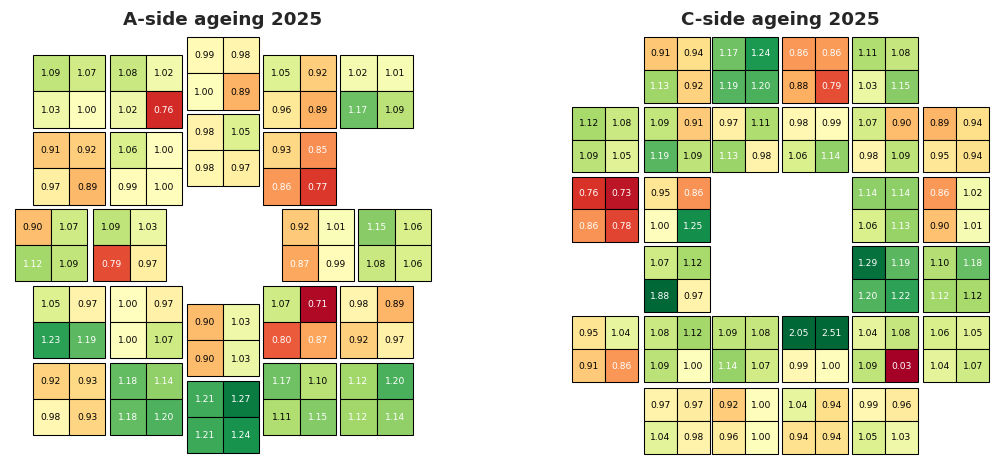

In [26]:
import matplotlib.pyplot as plt, numpy as np, csv, math

def load_positions(csv_path):
    pos = {}
    with open(csv_path, newline="", encoding="utf-8") as f:
        for r in csv.DictReader(f):
            key = r["PM:Channel"].strip()
            pos[key] = (float(r["row"]), float(r["col"]))
    return pos

pos_A = load_positions("../data/fta.csv")
pos_C = load_positions("../data/ftc.csv")

def build_value_dict(pos_map, vec):
    d = {}
    for tag,(r,c) in pos_map.items():
        ch = tag2id.get(tag)
        if ch is None or math.isnan(vec[ch]):
            continue
        d[(r,c)] = vec[ch]
    return d

# pick LAST run in 2025 for demo
vec = age_2025[-1]

vals_A = build_value_dict(pos_A, vec)
vals_C = build_value_dict(pos_C, vec)

# --- plotting (same draw() helper as before) ---------------------
fig,(axA,axC)=plt.subplots(1,2,figsize=(12,5),dpi=110)
draw_grid(axA, vals_A, "A-side ageing 2025")
draw_grid(axC, vals_C, "C-side ageing 2025")
plt.show()

Starting FT0 visualization...
Input data shape: (188, 256)

Loading run timestamps from laser_runs.json...
Loaded 228 runs from ../data/laserROOT/laser_runs.json
Date range: 2022-11-28 to 2025-07-14
Run range: 529693 to 564587
Matched 188/188 runs to dates

Creating visualization for specific date range...
Creating FT0 Detector Ageing Visualization
Date range: 2025-05-10 to 2025-06-14
Normalized 9 dead channels:
  A1:CH05 -> A1:CH05
  A1:CH06 -> A1:CH06
  A1:CH07 -> A1:CH07
  A1:CH08 -> A1:CH08
  C7:CH05 -> C7:CH05
  C7:CH06 -> C7:CH06
  C7:CH07 -> C7:CH07
  C7:CH08 -> C7:CH08
  C9:CH02 -> C9:CH02
Filtering to 27 runs between 2025-05-10 and 2025-06-14
First run date: 2025-05-11
Last run date: 2025-06-14
Calculating ageing factors for 256 channels over 27 runs...
Calculated ageing factors for 256 channels

Loading grid mappings...
Loaded 96 channel mappings from ../data/fta.csv
Loaded 112 channel mappings from ../data/ftc.csv

DEBUG: FTA mapping loaded 96 positions
DEBUG: FTC mapping lo

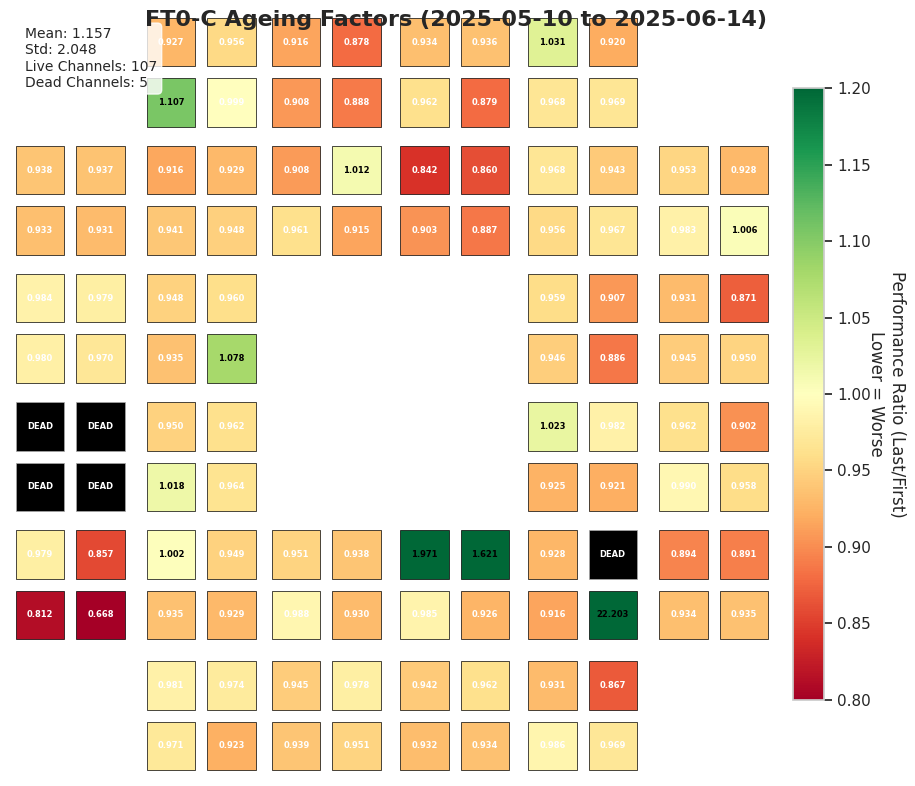

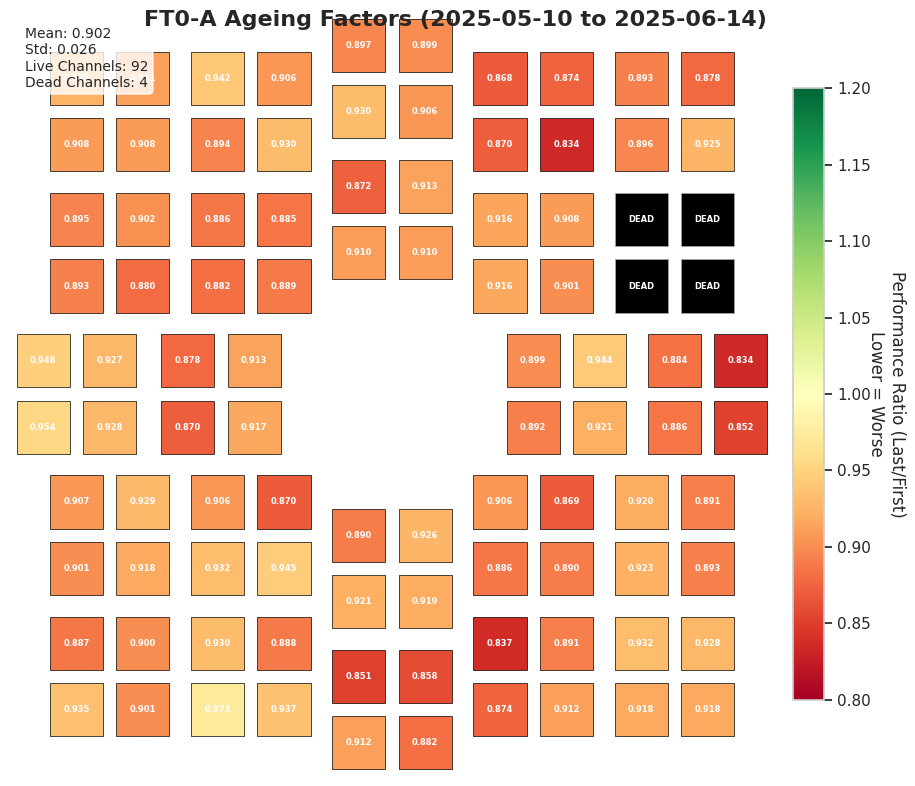

<Figure size 640x480 with 0 Axes>


SUMMARY STATISTICS:
Total runs analyzed: 188
Total channels: 256
Date range: 2024-04-07 to 2025-07-14

VISUALIZATION INTERPRETATION GUIDE:
• Red channels: Poor performance (low values - degraded)
• Yellow channels: Moderate performance
• Blue channels: Good performance (high values - stable/improved)
• Black channels: Dead channels (no data)
• Values shown are ratios: Last_run / First_run
• Values < 1.0: Degradation over time (RED)
• Values > 1.0: Improvement over time (BLUE)

DEAD CHANNELS USAGE:
To mark channels as dead (black), define:
  dead_channels = [
      ('A6', 'CH03'),      # PM A6, Channel 3
      ('C2', 'CH01'),      # PM C2, Channel 1
      ('PMA0', 'CH04'),    # PM A0, Channel 4
      ('PMC8', 'CH02'),    # PM C8, Channel 2
  ]

Channel formats supported:
  PM: 'A6', 'C2', 'PMA6', 'PMC2' (prefix optional)
  Channel: 'CH03', 'CH3', 'ch3', '3' (various formats)


In [43]:
# ╔══════════════════════════════════════════════════════╗
# ║ FT0 Detector Ageing Visualization                    ║
# ║ Comparing first vs last run of 2025                  ║
# ╚══════════════════════════════════════════════════════╝

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize
import re
import json
from datetime import datetime
from typing import Dict, Tuple, List, Optional

def load_run_timestamps(json_file: str = 'laser_runs.json') -> Tuple[List[int], List[str]]:
    """
    Load run numbers and timestamps from JSON file.
    
    Args:
        json_file: Path to JSON file with run data
    
    Returns:
        Tuple of (run_numbers, dates) where dates are in 'YYYY-MM-DD' format
    """
    try:
        with open(json_file, 'r') as f:
            run_data = json.load(f)
        
        run_numbers = []
        dates = []
        
        for entry in run_data:
            run_num = entry['run']
            timestamp_ms = entry['start_ms']
            
            # Convert UNIX timestamp (milliseconds) to datetime
            timestamp_s = timestamp_ms / 1000  # Convert ms to seconds
            dt = datetime.fromtimestamp(timestamp_s)
            date_str = dt.strftime('%Y-%m-%d')
            
            run_numbers.append(run_num)
            dates.append(date_str)
        
        print(f"Loaded {len(run_numbers)} runs from {json_file}")
        print(f"Date range: {min(dates)} to {max(dates)}")
        print(f"Run range: {min(run_numbers)} to {max(run_numbers)}")
        
        return run_numbers, dates
    
    except Exception as e:
        print(f"Error loading {json_file}: {e}")
        return [], []

def match_runs_to_data(run_numbers: List[int], 
                      dates: List[str], 
                      runs_ok: np.ndarray) -> List[str]:
    """
    Match run numbers from JSON to the filtered runs_ok array.
    
    Args:
        run_numbers: List of run numbers from JSON
        dates: List of corresponding dates
        runs_ok: Array of run numbers that passed quality filters
    
    Returns:
        List of dates corresponding to runs_ok array
    """
    # Create mapping from run number to date
    run_to_date = dict(zip(run_numbers, dates))
    
    # Get dates for runs that passed quality filters
    matched_dates = []
    missing_runs = []
    
    for run in runs_ok:
        if run in run_to_date:
            matched_dates.append(run_to_date[run])
        else:
            matched_dates.append(None)  # Missing date
            missing_runs.append(run)
    
    print(f"Matched {len([d for d in matched_dates if d is not None])}/{len(runs_ok)} runs to dates")
    
    if missing_runs:
        print(f"Warning: {len(missing_runs)} runs not found in JSON:")
        print(f"  Missing runs: {missing_runs[:10]}{'...' if len(missing_runs) > 10 else ''}")
    
    return matched_dates

# Channel to PM mapping (0-207 -> PM identifier) - based on your linear mapping
CHANNEL_TO_PM_MAPPING = {
    # A side inner (0-31)
    0: "PMA5", 1: "PMA5", 2: "PMA5", 3: "PMA5",
    4: "PMA6", 5: "PMA6", 6: "PMA6", 7: "PMA6", 
    8: "PMA7", 9: "PMA7", 10: "PMA7", 11: "PMA7",
    12: "PMA0", 13: "PMA0", 14: "PMA0", 15: "PMA0",
    16: "PMA1", 17: "PMA1", 18: "PMA1", 19: "PMA1",
    20: "PMA2", 21: "PMA2", 22: "PMA2", 23: "PMA2",
    24: "PMA3", 25: "PMA3", 26: "PMA3", 27: "PMA3",
    28: "PMA4", 29: "PMA4", 30: "PMA4", 31: "PMA4",
    # A side outer (32-95)
    32: "PMA5", 33: "PMA5", 34: "PMA5", 35: "PMA5",
    36: "PMA6", 37: "PMA6", 38: "PMA6", 39: "PMA6",
    40: "PMA6", 41: "PMA6", 42: "PMA6", 43: "PMA6",
    44: "PMA7", 45: "PMA7", 46: "PMA7", 47: "PMA7",
    48: "PMA7", 49: "PMA7", 50: "PMA7", 51: "PMA7",
    52: "PMA0", 53: "PMA0", 54: "PMA0", 55: "PMA0",
    56: "PMA0", 57: "PMA0", 58: "PMA0", 59: "PMA0",
    60: "PMA1", 61: "PMA1", 62: "PMA1", 63: "PMA1",
    64: "PMA1", 65: "PMA1", 66: "PMA1", 67: "PMA1",
    68: "PMA2", 69: "PMA2", 70: "PMA2", 71: "PMA2",
    72: "PMA2", 73: "PMA2", 74: "PMA2", 75: "PMA2",
    76: "PMA3", 77: "PMA3", 78: "PMA3", 79: "PMA3",
    80: "PMA3", 81: "PMA3", 82: "PMA3", 83: "PMA3",
    84: "PMA4", 85: "PMA4", 86: "PMA4", 87: "PMA4",
    88: "PMA4", 89: "PMA4", 90: "PMA4", 91: "PMA4",
    92: "PMA5", 93: "PMA5", 94: "PMA5", 95: "PMA5",
    # C side inner (96-143)
    96: "PMC3", 97: "PMC3", 98: "PMC3", 99: "PMC3",
    100: "PMC8", 101: "PMC8", 102: "PMC8", 103: "PMC8",
    104: "PMC2", 105: "PMC2", 106: "PMC2", 107: "PMC2",
    108: "PMC1", 109: "PMC1", 110: "PMC1", 111: "PMC1",
    112: "PMC8", 113: "PMC8", 114: "PMC8", 115: "PMC8",
    116: "PMC0", 117: "PMC0", 118: "PMC0", 119: "PMC0",
    120: "PMC7", 121: "PMC7", 122: "PMC7", 123: "PMC7",
    124: "PMC8", 125: "PMC8", 126: "PMC8", 127: "PMC8",
    128: "PMC6", 129: "PMC6", 130: "PMC6", 131: "PMC6",
    132: "PMC5", 133: "PMC5", 134: "PMC5", 135: "PMC5",
    136: "PMC9", 137: "PMC9", 138: "PMC9", 139: "PMC9",
    140: "PMC4", 141: "PMC4", 142: "PMC4", 143: "PMC4",
    # C side outer (144-207)
    144: "PMC3", 145: "PMC3", 146: "PMC3", 147: "PMC3",
    148: "PMC3", 149: "PMC3", 150: "PMC3", 151: "PMC3",
    152: "PMC2", 153: "PMC2", 154: "PMC2", 155: "PMC2",
    156: "PMC2", 157: "PMC2", 158: "PMC2", 159: "PMC2",
    160: "PMC1", 161: "PMC1", 162: "PMC1", 163: "PMC1",
    164: "PMC1", 165: "PMC1", 166: "PMC1", 167: "PMC1",
    168: "PMC0", 169: "PMC0", 170: "PMC0", 171: "PMC0",
    172: "PMC0", 173: "PMC0", 174: "PMC0", 175: "PMC0",
    176: "PMC7", 177: "PMC7", 178: "PMC7", 179: "PMC7",
    180: "PMC7", 181: "PMC7", 182: "PMC7", 183: "PMC7",
    184: "PMC6", 185: "PMC6", 186: "PMC6", 187: "PMC6",
    188: "PMC6", 189: "PMC6", 190: "PMC6", 191: "PMC6",
    192: "PMC5", 193: "PMC5", 194: "PMC5", 195: "PMC5",
    196: "PMC5", 197: "PMC5", 198: "PMC5", 199: "PMC5",
    200: "PMC4", 201: "PMC4", 202: "PMC4", 203: "PMC4",
    204: "PMC4", 205: "PMC4", 206: "PMC4", 207: "PMC4"
}

def normalize_pm_channel(pm: str, channel: str) -> str:
    """Normalize PM and channel names for consistent matching."""
    # Remove 'PM' prefix if present, convert to uppercase
    pm_normalized = pm.upper()
    if pm_normalized.startswith("PM"):
        pm_normalized = pm_normalized[2:]
    
    # Normalize channel: ensure CH + 2-digit format
    channel_normalized = channel.upper()
    channel_match = re.search(r"CH?(\d+)", channel_normalized, re.IGNORECASE)
    if channel_match:
        channel_num = channel_match.group(1).zfill(2)
        channel_normalized = f"CH{channel_num}"
    else:
        channel_normalized = channel_normalized
    
    return f"{pm_normalized}:{channel_normalized}"

def normalize_dead_channels(dead_channels: List[Tuple[str, str]]) -> List[str]:
    """
    Normalize dead channel specifications to consistent PM:Channel format.
    
    Args:
        dead_channels: List of (PM, Channel) tuples
        
    Returns:
        List of normalized PM:Channel strings
    """
    normalized = []
    for pm, channel in dead_channels:
        normalized_key = normalize_pm_channel(pm, channel)
        normalized.append(normalized_key)
    
    print(f"Normalized {len(dead_channels)} dead channels:")
    for orig, norm in zip(dead_channels, normalized):
        print(f"  {orig[0]}:{orig[1]} -> {norm}")
    
    return normalized

def load_grid_mapping(csv_file: str) -> Dict[str, Tuple[float, float]]:
    """Load grid mapping from CSV file."""
    try:
        df = pd.read_csv(csv_file)
        mapping = {}
        
        for _, row in df.iterrows():
            pm_channel = row['PM:Channel'].strip()
            try:
                row_pos = float(row['row'])
                col_pos = float(row['col'])
                
                # Split and normalize PM:Channel
                if ':' in pm_channel:
                    pm, channel = pm_channel.split(':', 1)
                    normalized_key = normalize_pm_channel(pm, channel)
                else:
                    normalized_key = normalize_pm_channel('', pm_channel)
                
                mapping[normalized_key] = (row_pos, col_pos)
            except (ValueError, KeyError) as e:
                print(f"Warning: Invalid data in row {pm_channel}: {e}")
        
        print(f"Loaded {len(mapping)} channel mappings from {csv_file}")
        return mapping
    
    except Exception as e:
        print(f"Error loading {csv_file}: {e}")
        return {}

def calculate_ageing_factors(age_data: np.ndarray, 
                           run_dates: Optional[List[str]] = None,
                           start_date: Optional[str] = None, 
                           end_date: Optional[str] = None) -> Dict[int, float]:
    """
    Calculate ageing factors as ratio of last/first valid run for each channel.
    
    Args:
        age_data: Array of shape (n_runs, n_channels) with normalized ageing data
        run_dates: List of date strings corresponding to each run (format: 'YYYY-MM-DD')
        start_date: Start date for filtering (format: 'YYYY-MM-DD')
        end_date: End date for filtering (format: 'YYYY-MM-DD')
    
    Returns:
        Dictionary mapping channel number to ageing factor
    """
    ageing_factors = {}
    n_runs, n_channels = age_data.shape
    
    # Filter runs by date if dates are provided
    if run_dates and (start_date or end_date):
        import pandas as pd
        
        # Convert to pandas datetime for easy filtering
        dates_df = pd.DataFrame({
            'run_idx': range(n_runs),
            'date': pd.to_datetime(run_dates)
        })
        
        # Apply date filters
        if start_date:
            start_dt = pd.to_datetime(start_date)
            dates_df = dates_df[dates_df['date'] >= start_dt]
            
        if end_date:
            end_dt = pd.to_datetime(end_date)
            dates_df = dates_df[dates_df['date'] <= end_dt]
        
        # Get filtered run indices
        valid_run_indices = dates_df['run_idx'].tolist()
        
        if len(valid_run_indices) < 2:
            print(f"Warning: Only {len(valid_run_indices)} runs found in date range {start_date} to {end_date}")
            return ageing_factors
            
        print(f"Filtering to {len(valid_run_indices)} runs between {start_date} and {end_date}")
        print(f"First run date: {dates_df.iloc[0]['date'].strftime('%Y-%m-%d')}")
        print(f"Last run date: {dates_df.iloc[-1]['date'].strftime('%Y-%m-%d')}")
        
        # Filter age data to selected runs
        filtered_age_data = age_data[valid_run_indices, :]
    else:
        print("No date filtering applied - using all runs")
        filtered_age_data = age_data
        valid_run_indices = list(range(n_runs))
    
    n_filtered_runs = filtered_age_data.shape[0]
    print(f"Calculating ageing factors for {n_channels} channels over {n_filtered_runs} runs...")
    
    for ch in range(n_channels):
        channel_data = filtered_age_data[:, ch]
        valid_data = channel_data[np.isfinite(channel_data)]
        
        if len(valid_data) >= 2:
            # Use first and last valid measurements in filtered data
            first_value = valid_data[0]
            last_value = valid_data[-1]
            
            if first_value != 0:
                ageing_factor = last_value / first_value
                ageing_factors[ch] = ageing_factor
            else:
                ageing_factors[ch] = 1.0  # No change
        else:
            ageing_factors[ch] = 1.0  # Default to no ageing if insufficient data
    
    print(f"Calculated ageing factors for {len(ageing_factors)} channels")
    return ageing_factors

def map_channels_to_grid(ageing_factors: Dict[int, float], 
                        grid_mapping: Dict[str, Tuple[float, float]],
                        side: str) -> Dict[str, float]:
    """
    Map channel ageing factors to grid positions for specified side.
    
    Args:
        ageing_factors: Dictionary mapping channel number to ageing factor
        grid_mapping: Dictionary mapping PM:Channel to (row, col) position
        side: 'A' or 'C' for detector side
    
    Returns:
        Dictionary mapping PM:Channel to ageing factor values
    """
    grid_data = {}
    
    # Define channel ranges for each side
    if side == 'A':
        channel_range = range(0, 96)  # Channels 0-95
    elif side == 'C':
        channel_range = range(96, 208)  # Channels 96-207
    else:
        raise ValueError("Side must be 'A' or 'C'")
    
    # Group channels by PM for better mapping
    pm_channels = {}
    for ch in channel_range:
        if ch not in ageing_factors:
            continue
            
        pm_id = CHANNEL_TO_PM_MAPPING.get(ch)
        if not pm_id:
            continue
            
        if pm_id not in pm_channels:
            pm_channels[pm_id] = []
        pm_channels[pm_id].append((ch, ageing_factors[ch]))
    
    # Map channels within each PM
    for pm_id, channels in pm_channels.items():
        # Sort channels by channel number to maintain consistent ordering
        channels.sort(key=lambda x: x[0])
        
        for i, (ch, factor) in enumerate(channels):
            # Channel number within PM (1-based)
            ch_in_pm = i + 1
            
            # Create normalized PM:Channel key
            pm_channel_key = normalize_pm_channel(pm_id, f"CH{ch_in_pm:02d}")
            
            # Check if this key exists in grid mapping
            if pm_channel_key in grid_mapping:
                grid_data[pm_channel_key] = factor
            else:
                # Try alternative channel numbering if first attempt fails
                for alt_ch in range(1, 17):  # Try channels 1-16
                    alt_key = normalize_pm_channel(pm_id, f"CH{alt_ch:02d}")
                    if alt_key in grid_mapping and alt_key not in grid_data:
                        grid_data[alt_key] = factor
                        break
                else:
                    print(f"Warning: Grid position not found for {pm_channel_key} (channel {ch})")
    
    print(f"Mapped {len(grid_data)} channels to grid for side {side}")
    
    # Debug: show available vs mapped channels
    available_in_grid = len([k for k in grid_mapping.keys() if (side == 'A' and 'A' in k) or (side == 'C' and 'C' in k)])
    print(f"Available positions in grid for side {side}: {available_in_grid}")
    
    return grid_data

def create_grid_visualization(grid_mapping: Dict[str, Tuple[float, float]],
                             grid_data: Dict[str, float],
                             side: str,
                             dead_channels: List[str] = None,
                             colormap: str = 'RdYlBu',
                             vmin: float = 0.8,
                             vmax: float = 1.2):
    """
    Create grid visualization for one detector side.
    
    Args:
        grid_mapping: Dictionary mapping PM:Channel to (row, col) positions
        grid_data: Dictionary mapping PM:Channel to ageing factor values
        side: 'A' or 'C' for detector side
        dead_channels: List of normalized PM:Channel strings to mark as dead (black)
        colormap: Matplotlib colormap name
        vmin: Minimum value for color scaling
        vmax: Maximum value for color scaling
    
    Returns:
        Matplotlib Figure with the grid visualization
    """
    fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
    
    # Get colormap
    cmap = plt.get_cmap(colormap)
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    # Convert dead channels to set for fast lookup
    dead_set = set(dead_channels) if dead_channels else set()
    
    # Collect positions and values
    positions = []
    values = []
    labels = []
    dead_positions = []
    
    for pm_channel, (row, col) in grid_mapping.items():
        if pm_channel in dead_set:
            # This is a dead channel
            dead_positions.append((col, row, pm_channel))
        else:
            # Normal channel
            value = grid_data.get(pm_channel, 1.0)  # Default to 1.0 if no data
            positions.append((col, row))
            values.append(value)
            labels.append(pm_channel)
    
    if not values and not dead_positions:
        ax.text(0.5, 0.5, f"No data available for side {side}",
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        return fig
    
    # Create rectangles for normal channels
    for (x, y), value, label in zip(positions, values, labels):
        # Create colored rectangle
        rect = patches.Rectangle((x - 0.4, y - 0.4), 0.8, 0.8,
                               facecolor=cmap(norm(value)),
                               edgecolor='black', linewidth=0.5)
        ax.add_patch(rect)
        
        # Add value text inside rectangle
        value_normalized = norm(value)
        text_color = 'white' if value_normalized < 0.5 else 'black'
        ax.text(x, y, f'{value:.3f}', ha='center', va='center',
                color=text_color, fontsize=6, weight='bold')
    
    # Create black rectangles for dead channels
    dead_count = 0
    for x, y, label in dead_positions:
        # Create black rectangle for dead channel
        rect = patches.Rectangle((x - 0.4, y - 0.4), 0.8, 0.8,
                               facecolor='black',
                               edgecolor='darkgray', linewidth=0.5)
        ax.add_patch(rect)
        
        # Add "DEAD" text in white
        ax.text(x, y, 'DEAD', ha='center', va='center',
                color='white', fontsize=6, weight='bold')
        dead_count += 1
    
    # Set axis limits with padding
    all_x = [pos[0] for pos in positions] + [pos[0] for pos in dead_positions]
    all_y = [pos[1] for pos in positions] + [pos[1] for pos in dead_positions]
    
    if all_x and all_y:
        x_min, x_max = min(all_x), max(all_x)
        y_min, y_max = min(all_y), max(all_y)
        padding = 0.5
        ax.set_xlim(x_min - padding, x_max + padding)
        ax.set_ylim(y_min - padding, y_max + padding)
    
    # Style the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_aspect('equal')
    
    # Invert y-axis to match detector layout
    ax.invert_yaxis()
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label('Performance Ratio (Last/First)\nLower = Worse', rotation=270, labelpad=25)
    
    # Add statistics text (excluding dead channels)
    stats_text = (f'Mean: {np.mean(values):.3f}\n'
                 f'Std: {np.std(values):.3f}\n'
                 f'Live Channels: {len(values)}\n'
                 f'Dead Channels: {dead_count}')
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', 
            facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

def create_combined_ft0_visualization(age_data: np.ndarray,
                                    run_dates: Optional[List[str]] = None,
                                    start_date: Optional[str] = None,
                                    end_date: Optional[str] = None,
                                    dead_channels: List[Tuple[str, str]] = None,
                                    fta_csv: str = 'fta.csv',
                                    ftc_csv: str = 'ftc.csv',
                                    colormap: str = 'RdYlBu',
                                    vmin: float = 0.8,
                                    vmax: float = 1.2,
                                    debug: bool = True) -> Tuple[plt.Figure, plt.Figure]:
    """
    Create combined FT0 visualization with both A and C sides.
    
    Args:
        age_data: Ageing data array of shape (n_runs, n_channels)
        run_dates: List of date strings corresponding to each run (format: 'YYYY-MM-DD')
        start_date: Start date for filtering (format: 'YYYY-MM-DD')
        end_date: End date for filtering (format: 'YYYY-MM-DD')
        dead_channels: List of (PM, Channel) tuples for dead channels to mark black
        fta_csv: Path to FTA grid mapping CSV
        ftc_csv: Path to FTC grid mapping CSV
        colormap: Matplotlib colormap name
        vmin: Minimum value for color scaling
        vmax: Maximum value for color scaling
        debug: Print debugging information
    
    Returns:
        Tuple of (figure_A, figure_C) matplotlib Figures
    """
    print("=" * 60)
    print("Creating FT0 Detector Ageing Visualization")
    if start_date or end_date:
        print(f"Date range: {start_date or 'start'} to {end_date or 'end'}")
    print("=" * 60)
    
    # Normalize dead channels
    normalized_dead = []
    if dead_channels:
        normalized_dead = normalize_dead_channels(dead_channels)
    
    # Calculate ageing factors with date filtering
    ageing_factors = calculate_ageing_factors(age_data, run_dates, start_date, end_date)
    
    # Load grid mappings
    print("\nLoading grid mappings...")
    grid_mapping_a = load_grid_mapping(fta_csv)
    grid_mapping_c = load_grid_mapping(ftc_csv)
    
    if debug:
        print(f"\nDEBUG: FTA mapping loaded {len(grid_mapping_a)} positions")
        print(f"DEBUG: FTC mapping loaded {len(grid_mapping_c)} positions")
        
        if normalized_dead:
            print(f"DEBUG: {len(normalized_dead)} dead channels specified")
        
        # Show sample mappings
        print("\nSample FTA mappings:")
        for i, (key, pos) in enumerate(list(grid_mapping_a.items())[:5]):
            print(f"  {key} -> {pos}")
            
        print("\nSample FTC mappings:")
        for i, (key, pos) in enumerate(list(grid_mapping_c.items())[:5]):
            print(f"  {key} -> {pos}")
    
    # Map channels to grids
    print("\nMapping channels to grids...")
    grid_data_a = map_channels_to_grid(ageing_factors, grid_mapping_a, 'A')
    grid_data_c = map_channels_to_grid(ageing_factors, grid_mapping_c, 'C')
    
    if debug:
        print(f"\nDEBUG: A-side coverage: {len(grid_data_a)}/{len(grid_mapping_a)} positions")
        print(f"DEBUG: C-side coverage: {len(grid_data_c)}/{len(grid_mapping_c)} positions")
        
        # Show ageing factor statistics (excluding dead channels)
        if grid_data_a:
            a_values = [v for k, v in grid_data_a.items() if k not in normalized_dead]
            if a_values:
                print(f"DEBUG: A-side ageing factors - mean: {np.mean(a_values):.3f}, "
                      f"std: {np.std(a_values):.3f}, range: {np.min(a_values):.3f}-{np.max(a_values):.3f}")
        
        if grid_data_c:
            c_values = [v for k, v in grid_data_c.items() if k not in normalized_dead]
            if c_values:
                print(f"DEBUG: C-side ageing factors - mean: {np.mean(c_values):.3f}, "
                      f"std: {np.std(c_values):.3f}, range: {np.min(c_values):.3f}-{np.max(c_values):.3f}")
    
    # Create visualizations
    print("\nCreating visualizations...")
    fig_a = create_grid_visualization(grid_mapping_a, grid_data_a, 'A', 
                                     normalized_dead, colormap, vmin, vmax)
    fig_c = create_grid_visualization(grid_mapping_c, grid_data_c, 'C', 
                                     normalized_dead, colormap, vmin, vmax)
    
    # Update titles to include date range if specified
    if start_date or end_date:
        date_range = f"({start_date or 'start'} to {end_date or 'end'})"
        fig_a.suptitle(f'FT0-A Ageing Factors {date_range}', fontsize=16, fontweight='bold')
        fig_c.suptitle(f'FT0-C Ageing Factors {date_range}', fontsize=16, fontweight='bold')
    else:
        fig_a.suptitle(f'FT0-A Ageing Factors (Last/First Run 2025)', fontsize=16, fontweight='bold')
        fig_c.suptitle(f'FT0-C Ageing Factors (Last/First Run 2025)', fontsize=16, fontweight='bold')
    
    print("Visualization complete!")
    print(f"Side A: {len(grid_data_a)} channels mapped")
    print(f"Side C: {len(grid_data_c)} channels mapped")
    if normalized_dead:
        print(f"Dead channels: {len(normalized_dead)} marked in black")
    
    return fig_a, fig_c

# ╔══════════════════════════════════════════════════════╗
# ║ Main visualization execution with JSON date loading   ║
# ╚══════════════════════════════════════════════════════╝

# Create the FT0 detector visualization with JSON timestamp loading
# Assumes 'age' and 'runs_ok' variables exist from previous ageing calculation
try:
    print("Starting FT0 visualization...")
    print(f"Input data shape: {age.shape}")

    TIMESTAMPS = '../data/laserROOT/laser_runs.json'
    FTA_CSV = '../data/fta.csv'
    FTC_CSV = '../data/ftc.csv'
    
    # DEFINE DEAD CHANNELS HERE
    # Format: List of (PM, Channel) tuples
    dead_channels = [
        ('A1', 'CH05'),
        ('A1', 'CH06'),
        ('A1', 'CH07'),
        ('A1', 'CH08'),
        ('C7', 'CH05'),
        ('C7', 'CH06'),
        ('C7', 'CH07'),
        ('C7', 'CH08'),
        ('C9', 'CH02'),
    ]
    
    # Load run timestamps from JSON
    print("\nLoading run timestamps from laser_runs.json...")
    run_numbers, all_dates = load_run_timestamps(TIMESTAMPS)
    
    if run_numbers and all_dates:
        # Match JSON run numbers to your filtered runs_ok array
        run_dates = match_runs_to_data(run_numbers, all_dates, runs_ok)
        
        # OPTION 1: Use all available runs with dates
        """
        print("\nCreating visualization with all available runs...")
        fig_a, fig_c = create_combined_ft0_visualization(
            age_data=age,
            run_dates=run_dates,   # Use matched dates
            dead_channels=dead_channels,  # Mark dead channels black
            fta_csv=FTA_CSV,
            ftc_csv=FTC_CSV,
            colormap='RdYlBu',     # Red=bad (low values), Blue=good (high values)
            vmin=0.8,              # 20% degradation (bad - red)
            vmax=1.2,              # 20% improvement (good - blue)
            debug=True             # Enable debugging output
        )
        """
        
        # OPTION 2: Filter by specific date range (uncomment and modify as needed)
         
        print("\nCreating visualization for specific date range...")
        fig_a, fig_c = create_combined_ft0_visualization(
             age_data=age,
             run_dates=run_dates,
             start_date='2025-05-10',  # Start of analysis period
             end_date='2025-06-14',    # End of analysis period
             dead_channels=dead_channels,  # Mark dead channels black
             fta_csv=FTA_CSV,
             ftc_csv=FTC_CSV,
             colormap='RdYlGn',
             vmin=0.8,
             vmax=1.2,
             debug=True
         )
        
    else:
        # Fallback: No date filtering if JSON loading failed
        print("\nJSON loading failed, creating visualization without date filtering...")
        fig_a, fig_c = create_combined_ft0_visualization(
            age_data=age,
            dead_channels=dead_channels,  # Mark dead channels black
            fta_csv=FTA_CSV,
            ftc_csv=FTC_CSV,
            colormap='RdYlBu',
            vmin=0.8,
            vmax=1.2,
            debug=True
        )
    
    # Display the figures using pyplot
    plt.figure(fig_a.number)
    plt.show()
    
    plt.figure(fig_c.number)
    plt.show()
    
    # Optional: Save figures with high quality
    # fig_a.savefig('FT0_A_ageing_2025.png', dpi=300, bbox_inches='tight', 
    #               facecolor='white', edgecolor='none')
    # fig_c.savefig('FT0_C_ageing_2025.png', dpi=300, bbox_inches='tight', 
    #               facecolor='white', edgecolor='none')
    
    # Print summary statistics
    print(f"\nSUMMARY STATISTICS:")
    print(f"Total runs analyzed: {age.shape[0]}")
    print(f"Total channels: {age.shape[1]}")
    if 'run_dates' in locals() and any(run_dates):
        valid_dates = [d for d in run_dates if d is not None]
        if valid_dates:
            print(f"Date range: {min(valid_dates)} to {max(valid_dates)}")
    
    print("\n" + "="*60)
    print("VISUALIZATION INTERPRETATION GUIDE:")
    print("="*60)
    print("• Red channels: Poor performance (low values - degraded)")
    print("• Yellow channels: Moderate performance")
    print("• Blue channels: Good performance (high values - stable/improved)")
    print("• Black channels: Dead channels (no data)")
    print("• Values shown are ratios: Last_run / First_run")
    print("• Values < 1.0: Degradation over time (RED)")
    print("• Values > 1.0: Improvement over time (BLUE)")
    print("="*60)
    
    print("\n" + "="*60)
    print("DEAD CHANNELS USAGE:")
    print("="*60)
    print("To mark channels as dead (black), define:")
    print("  dead_channels = [")
    print("      ('A6', 'CH03'),      # PM A6, Channel 3")
    print("      ('C2', 'CH01'),      # PM C2, Channel 1") 
    print("      ('PMA0', 'CH04'),    # PM A0, Channel 4")
    print("      ('PMC8', 'CH02'),    # PM C8, Channel 2")
    print("  ]")
    print("")
    print("Channel formats supported:")
    print("  PM: 'A6', 'C2', 'PMA6', 'PMC2' (prefix optional)")
    print("  Channel: 'CH03', 'CH3', 'ch3', '3' (various formats)")
    print("="*60)
    
except NameError as e:
    print(f"Error: Missing variable - {e}")
    print("Please ensure you have both 'age' and 'runs_ok' variables from ageing calculation.")
    print("Example:")
    print("  age_list = Parallel(n_jobs=-1)(delayed(process_run)(i) for i in range(n_run))")
    print("  age = np.array(age_list, dtype=np.float32)")
    print("  # runs_ok should be the array of good run numbers after filtering")
    
except Exception as e:
    print(f"Error creating visualization: {e}")
    print("Troubleshooting checklist:")
    print("1. Make sure 'age' variable exists with shape (n_runs, 208)")
    print("2. Make sure 'runs_ok' variable exists with good run numbers")
    print("3. Ensure 'laser_runs.json' file is in the current directory")
    print("4. Ensure 'fta.csv' and 'ftc.csv' files are in the current directory")
    print("5. Check JSON format: [{'run': 564587, 'start_ms': 1752461684829}, ...]")
    print("6. Verify matplotlib backend supports .show() method")
    
    # Try to provide more debugging info
    try:
        print(f"\nDebugging info:")
        print(f"  age variable exists: {'age' in locals()}")
        print(f"  runs_ok variable exists: {'runs_ok' in locals()}")
        if 'age' in locals():
            print(f"  age shape: {age.shape}")
            print(f"  age dtype: {age.dtype}")
        if 'runs_ok' in locals():
            print(f"  runs_ok shape: {runs_ok.shape}")
            print(f"  runs_ok sample: {runs_ok[:5]}")
        
        import os
        print(f"  laser_runs.json exists: {os.path.exists(TIMESTAMPS)}")
        print(f"  fta.csv exists: {os.path.exists(FTA_CSV)}")
        print(f"  ftc.csv exists: {os.path.exists(FTC_CSV)}")
    except:
        pass

## Plot by polarity

### File loading

In [17]:
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import uproot
from scipy.optimize import curve_fit
from scipy import stats
import numba
from numba import jit, njit
from tqdm.notebook import tqdm
import json
import re
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
import time
import warnings
warnings.filterwarnings('ignore')

# Import the optimized processing module
from optimized_processing import (
    HybridOptimizedProcessor,
    ProcessingConfig, 
    process_all_runs_hybrid,
    calculate_normalized_means_hybrid,
    create_hybrid_config,
    benchmark_hybrid_performance,
    RUST_AVAILABLE
)

# Constants
IN_DIR = "/home/mvishiu11/Desktop/CERN/LHC-aging-analysis/data/laserROOT/work/250725-082002/digits"
JSON_FILE = "/home/mvishiu11/Desktop/CERN/LHC-aging-analysis/data/laserROOT/laser_runs.json"
HIST_BINS = 4100
HIST_RANGE = (0, 4100)
TARGET_CHANNELS = list(range(208))    # Channels 0-207
REFERENCE_CHANNELS = [208, 210, 211]  # Skip 209 as it's noisy
SKIP_CHANNEL = 209
REF_PEAK_RANGE = (100, 600)

# Gaussian fitting parameters
FIT_FRACTION_LOW = 0.75
FIT_FRACTION_HIGH = 1.25

print("Setup complete!")
print(f"Target channels: 0-{max(TARGET_CHANNELS)}")
print(f"Reference channels: {REFERENCE_CHANNELS}")

Setup complete!
Target channels: 0-207
Reference channels: [208, 210, 211]


In [18]:
def load_run_metadata(json_file="laser_runs.json"):
    """Load run metadata from JSON file"""
    with open(json_file, 'r') as f:
        metadata = json.load(f)
    
    # Convert to DataFrame for easier handling
    df = pd.DataFrame(metadata)
    df['timestamp'] = pd.to_datetime(df['start_ms'], unit='ms')
    df = df.sort_values('run').reset_index(drop=True)
    
    print(f"Loaded metadata for {len(df)} runs")
    print(f"Run range: {df['run'].min()} - {df['run'].max()}")
    print(f"Time range: {df['timestamp'].min()} - {df['timestamp'].max()}")
    print(f"Polarities: {df['polarity'].unique()}")
    
    return df

# Load metadata
run_metadata = load_run_metadata(json_file=JSON_FILE)
run_metadata.head()

Loaded metadata for 451 runs
Run range: 529693 - 564856
Time range: 2022-11-28 05:13:47 - 2025-07-24 04:58:23.150000
Polarities: ['POSITIVE' 'NEGATIVE' None]


run       start_ms  polarity         beamType           timestamp
0  529693  1669612427000  POSITIVE  PROTON - PROTON 2022-11-28 05:13:47
1  543366  1695644117000  POSITIVE      PB82 - PB82 2023-09-25 12:15:17
2  543445  1695761986000  POSITIVE      PB82 - PB82 2023-09-26 20:59:46
3  543473  1695798658000  POSITIVE      PB82 - PB82 2023-09-27 07:10:58
4  543474  1695798823000  POSITIVE      PB82 - PB82 2023-09-27 07:13:43

In [19]:
def extract_run_number(filename):
    """Extract run number from filename like 'run_564250_ft0digits.root'"""
    match = re.search(r'run_(\d{6})_ft0digits\.root', filename)
    if match:
        return int(match.group(1))
    return None

def get_root_files(directory):
    """Get all .root files matching the pattern in directory"""
    files = []
    for file in Path(directory).glob("run_*_ft0digits.root"):
        run_num = extract_run_number(file.name)
        if run_num:
            files.append((str(file), run_num))
    
    # Sort by run number
    files.sort(key=lambda x: x[1])
    print(f"Found {len(files)} ROOT files")
    return files

def gaussian_func(x, amplitude, mean, sigma, offset=0):
    """Gaussian function for fitting"""
    return amplitude * np.exp(-0.5 * ((x - mean) / sigma) ** 2) + offset

# Test the file finding
root_files = get_root_files(IN_DIR)
print(f"Sample files: {[f[1] for f in root_files[:5]]}")

Found 371 ROOT files
Sample files: [546923, 548584, 548609, 549390, 549617]


### Integrity check

In [20]:
def check_file_integrity(file_path):
    """
    Check if a ROOT file has the expected structure and content
    Returns (is_valid, error_message, file_info)
    """
    try:
        # Check file exists and size
        if not Path(file_path).exists():
            return False, "File not found", {}
        
        file_size = Path(file_path).stat().st_size
        if file_size < 1024:  # Less than 1KB
            return False, f"File too small ({file_size} bytes)", {"size": file_size}
        
        # Try to open and check structure
        with uproot.open(file_path) as file:
            # Check for required tree
            if "o2sim" not in file:
                available = list(file.keys())
                return False, f"Missing 'o2sim' tree. Available: {available}", {"keys": available}
            
            tree = file["o2sim"]
            
            # Check tree entries
            try:
                num_entries = len(tree)
                if num_entries == 0:
                    return False, "Tree has no entries", {"entries": 0}
            except:
                return False, "Cannot read tree entries", {}
            
            # Check for required branches
            required_branches = ["FT0DIGITSCH/FT0DIGITSCH.QTCAmpl", "FT0DIGITSCH/FT0DIGITSCH.ChId"]
            missing_branches = [branch for branch in required_branches if branch not in tree]
            
            if missing_branches:
                return False, f"Missing branches: {missing_branches}", {"missing_branches": missing_branches}
            
            # Try to read a small sample to check data integrity
            try:
                qtc_sample = tree["FT0DIGITSCH/FT0DIGITSCH.QTCAmpl"].array(library="np", entry_stop=min(10, num_entries))
                ch_sample = tree["FT0DIGITSCH/FT0DIGITSCH.ChId"].array(library="np", entry_stop=min(10, num_entries))
                
                # Check if we can flatten without errors
                total_qtc_entries = sum(len(event) for event in qtc_sample)
                total_ch_entries = sum(len(event) for event in ch_sample)
                
                if total_qtc_entries == 0:
                    return False, "No QTCAmpl data in sample", {"entries": num_entries, "qtc_entries": 0}
                
                return True, "OK", {
                    "entries": num_entries, 
                    "qtc_entries": total_qtc_entries,
                    "ch_entries": total_ch_entries,
                    "size": file_size
                }
                
            except Exception as e:
                return False, f"Data read error: {e}", {"entries": num_entries}
        
    except Exception as e:
        return False, f"File access error: {e}", {}


def delete_invalid_files(invalid_files):
    """
    Delete invalid files with user confirmation
    """
    if not invalid_files:
        print("No invalid files to delete.")
        return
    
    print(f"\n{'='*60}")
    print(f"FOUND {len(invalid_files)} INVALID FILES")
    print(f"{'='*60}")
    
    # Show summary by error type
    error_counts = {}
    total_size = 0
    for file_path, run_num, error in invalid_files:
        error_type = error.split(':')[0] if ':' in error else error
        error_counts[error_type] = error_counts.get(error_type, 0) + 1
        
        # Try to get file size for total calculation
        try:
            if Path(file_path).exists():
                total_size += Path(file_path).stat().st_size
        except:
            pass
    
    print(f"Error breakdown:")
    for error_type, count in sorted(error_counts.items()):
        print(f"  • {error_type}: {count} files")
    
    if total_size > 0:
        print(f"\nTotal size to be freed: {total_size / 1024 / 1024:.1f} MB")
    
    # Show first few files as examples
    print(f"\nExample files to be deleted:")
    for i, (file_path, run_num, error) in enumerate(invalid_files[:5]):
        file_size = ""
        try:
            if Path(file_path).exists():
                size_mb = Path(file_path).stat().st_size / 1024 / 1024
                file_size = f" ({size_mb:.1f} MB)"
        except:
            pass
        print(f"  • Run {run_num}: {Path(file_path).name}{file_size} - {error}")
    
    if len(invalid_files) > 5:
        print(f"  ... and {len(invalid_files) - 5} more files")
    
    # Ask for confirmation
    print(f"\n{'='*60}")
    response = input(f"Do you want to DELETE these {len(invalid_files)} invalid files? [y/N]: ").strip().lower()
    
    if response not in ['y', 'yes']:
        print("Deletion cancelled. Invalid files preserved.")
        return
    
    # Final confirmation for safety
    print(f"\n⚠️  FINAL WARNING: About to permanently delete {len(invalid_files)} files!")
    final_confirm = input("Type 'DELETE' to confirm: ").strip()
    
    if final_confirm != 'DELETE':
        print("Deletion cancelled. Invalid files preserved.")
        return
    
    # Proceed with deletion
    print(f"\nDeleting {len(invalid_files)} invalid files...")
    
    deleted_count = 0
    failed_deletions = []
    freed_space = 0
    
    for file_path, run_num, error in tqdm(invalid_files, desc="Deleting files"):
        try:
            if Path(file_path).exists():
                # Get file size before deletion
                file_size = Path(file_path).stat().st_size
                
                # Delete the file
                Path(file_path).unlink()
                
                deleted_count += 1
                freed_space += file_size
                
            else:
                # File already doesn't exist
                deleted_count += 1
                
        except Exception as e:
            failed_deletions.append((file_path, run_num, str(e)))
            print(f"  Failed to delete Run {run_num}: {e}")
    
    # Report results
    print(f"\n{'='*60}")
    print(f"DELETION SUMMARY")
    print(f"{'='*60}")
    print(f"Successfully deleted: {deleted_count}/{len(invalid_files)} files")
    print(f"Space freed: {freed_space / 1024 / 1024:.1f} MB")
    
    if failed_deletions:
        print(f"Failed deletions: {len(failed_deletions)}")
        print(f"\nFiles that could not be deleted:")
        for file_path, run_num, error in failed_deletions:
            print(f"  • Run {run_num}: {error}")
    else:
        print("All invalid files successfully deleted! ✓")


def perform_integrity_check(auto_delete=False):
    """
    Check integrity of all ROOT files before processing
    
    Parameters:
    auto_delete (bool): If True, automatically prompt to delete invalid files
    """
    root_files = get_root_files(IN_DIR)
    
    print(f"Checking integrity of {len(root_files)} ROOT files...\n")
    
    valid_files = []
    invalid_files = []
    file_stats = {
        'total_entries': 0,
        'total_size': 0,
        'min_entries': float('inf'),
        'max_entries': 0
    }
    
    for file_path, run_number in tqdm(root_files, desc="Checking files"):
        is_valid, error_msg, info = check_file_integrity(file_path)
        
        if is_valid:
            valid_files.append((file_path, run_number, info))
            file_stats['total_entries'] += info['entries']
            file_stats['total_size'] += info['size']
            file_stats['min_entries'] = min(file_stats['min_entries'], info['entries'])
            file_stats['max_entries'] = max(file_stats['max_entries'], info['entries'])
        else:
            invalid_files.append((file_path, run_number, error_msg))
            print(f"  INVALID: Run {run_number} - {error_msg}")
    
    print(f"\n=== FILE INTEGRITY SUMMARY ===")
    print(f"Valid files: {len(valid_files)}/{len(root_files)} ({len(valid_files)/len(root_files)*100:.1f}%)")
    print(f"Invalid files: {len(invalid_files)}")
    
    if valid_files:
        avg_entries = file_stats['total_entries'] / len(valid_files)
        avg_size_mb = file_stats['total_size'] / len(valid_files) / 1024 / 1024
        
        print(f"\nValid file statistics:")
        print(f"  Average entries per file: {avg_entries:.0f}")
        print(f"  Entry range: {file_stats['min_entries']} - {file_stats['max_entries']}")
        print(f"  Average file size: {avg_size_mb:.1f} MB")
        print(f"  Total data size: {file_stats['total_size']/1024/1024/1024:.2f} GB")
    
    if invalid_files:
        print(f"\nInvalid files by error type:")
        error_counts = {}
        for _, _, error in invalid_files:
            error_type = error.split(':')[0] if ':' in error else error
            error_counts[error_type] = error_counts.get(error_type, 0) + 1
        
        for error_type, count in sorted(error_counts.items()):
            print(f"  {error_type}: {count} files")
        
        if len(invalid_files) <= 10:
            print(f"\nDetailed invalid file list:")
            for file_path, run_num, error in invalid_files:
                print(f"  Run {run_num}: {error}")
        
        # Automatically offer to delete invalid files
        if auto_delete:
            delete_invalid_files(invalid_files)
    
    return valid_files, invalid_files


# Run integrity check with option to delete invalid files
valid_files, invalid_files = perform_integrity_check(auto_delete=True)

Found 371 ROOT files
Checking integrity of 371 ROOT files...



Checking files:   0%|          | 0/371 [00:00<?, ?it/s]


=== FILE INTEGRITY SUMMARY ===
Valid files: 371/371 (100.0%)
Invalid files: 0

Valid file statistics:
  Average entries per file: 2
  Entry range: 2 - 2
  Average file size: 49.0 MB
  Total data size: 17.76 GB


### Faster loading?

In [21]:
print("🧪 Testing hybrid processor with single file...")

# Create configuration (replaces your constants)
config = ProcessingConfig(
        hist_bins=HIST_BINS,
        hist_range=HIST_RANGE,
        min_entries=100,
        min_fit_points=10,
        ref_peak_range=REF_PEAK_RANGE,
        fit_fraction_low=FIT_FRACTION_LOW,
        fit_fraction_high=FIT_FRACTION_HIGH,
        use_rust=True
    )
print(f"Configuration created - Rust available: {config.use_rust}")

# Test with one file
if valid_files:
    processor = HybridOptimizedProcessor(config)
    test_file, test_run, test_info = valid_files[0]
    
    print(f"Testing with file: {test_file}")
    print(f"Run: {test_run}, Entries: {test_info}")
    
    # Time the processing
    start_time = time.time()
    
    # This replaces your process_single_run() call
    test_results = processor.process_single_run_hybrid(test_file, test_run)
    
    processing_time = time.time() - start_time
    
    print(f"✅ Single file test complete!")
    print(f"   Processing time: {processing_time:.2f}s")
    print(f"   Channels processed: {len(test_results)}")
    print(f"   Mode: {'🚀 Rust' if processor.use_rust else '⚡ Python'}")
    
    # Show sample results
    print(f"   Sample channel results:")
    for ch in [0, 1, 2, 208, 210, 211]:
        if ch in test_results:
            result = test_results[ch]
            print(f"     Ch {ch}: mean={result['mean']:.1f}, σ={result['sigma']:.1f}, "
                  f"R²={result['r_squared']:.3f}, method={result['method']}")
    
    # Test normalization (replaces your calculate_normalized_means call)
    normalized_test = calculate_normalized_means_hybrid(test_results, REFERENCE_CHANNELS)
    print(f"   Normalized channels: {len(normalized_test)}")
    
    for ch in [0, 1, 24]:
        if ch in normalized_test:
            result = normalized_test[ch]
            print(f"     Ch {ch}: norm={result['normalized_mean']:.4f} ± {result['normalized_err']:.4f}")

🧪 Testing hybrid processor with single file...
Configuration created - Rust available: True
🔧 Processor initialized:
   Rust acceleration: ✅
   Target channels: 208
   Reference channels: 3
Testing with file: /home/mvishiu11/Desktop/CERN/LHC-aging-analysis/data/laserROOT/work/250725-082002/digits/run_546923_ft0digits.root
Run: 546923, Entries: {'entries': 2, 'qtc_entries': 2444, 'ch_entries': 2444, 'size': 51196708}
✅ Single file test complete!
   Processing time: 2.77s
   Channels processed: 209
   Mode: 🚀 Rust
   Sample channel results:
     Ch 0: mean=73.7, σ=2.5, R²=-0.027, method=weighted_mean
     Ch 1: mean=76.3, σ=2.4, R²=-0.025, method=weighted_mean
     Ch 2: mean=82.8, σ=2.2, R²=-0.020, method=weighted_mean
     Ch 208: mean=263.1, σ=18.6, R²=0.998, method=gaussian_fit
     Ch 210: mean=253.0, σ=17.1, R²=0.998, method=gaussian_fit
     Ch 211: mean=301.0, σ=20.1, R²=0.998, method=gaussian_fit
   Normalized channels: 206
     Ch 0: norm=0.2704 ± 0.0254
     Ch 1: norm=0.2801 

In [22]:
print("\n🏁 Running performance benchmark...")
benchmark_results = benchmark_hybrid_performance(valid_files, num_test_files=5)


🏁 Running performance benchmark...
🏁 Benchmarking hybrid performance with 5 files...
🔧 Processor initialized:
   Rust acceleration: ✅
   Target channels: 208
   Reference channels: 3
🔧 Processor initialized:
   Rust acceleration: ❌
   Target channels: 208
   Reference channels: 3
📊 Benchmark Results:
   🚀 Rust mode: 12.25s (2.45s per file)
   ⚡ Python mode: 19.98s (4.00s per file)
   🏆 Speedup: 1.6x faster with Rust
   📈 Estimated time for 371 files:
      Rust: 15.2 minutes
      Python: 24.7 minutes


In [23]:
print("\n🚀 Starting main hybrid processing...")

# Create configuration
config = create_hybrid_config()

# This SINGLE CALL replaces your entire process_all_runs() function
# Same inputs, same outputs, but much faster!
start_total = time.time()

all_fit_results, all_normalized_results, metadata = process_all_runs_hybrid(
    valid_files,     # Your validated files (3-tuple format)
    run_metadata,    # Your metadata DataFrame  
    config          # Configuration object
)

total_time = time.time() - start_total

print(f"\n🎉 HYBRID PROCESSING COMPLETE!")
print(f"   Total time: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"   Time per file: {total_time/len(valid_files):.2f}s")


🚀 Starting main hybrid processing...
🚀 Starting hybrid processing of 371 files...
🔧 Processor initialized:
   Rust acceleration: ✅
   Target channels: 208
   Reference channels: 3

📊 Processing POSITIVE polarity...


POSITIVE runs:   0%|          | 0/229 [00:00<?, ?it/s]

✅ POSITIVE complete: 216/229 runs successful

📊 Processing NEGATIVE polarity...


NEGATIVE runs:   0%|          | 0/134 [00:00<?, ?it/s]

✅ NEGATIVE complete: 132/134 runs successful

📊 Processing None polarity...


None runs: |          | 0/0 [00:00<?, ?it/s]

✅ None complete: 0/0 runs successful

🎉 HYBRID PROCESSING COMPLETE!
📈 Performance Summary:
   Total time: 881.9s (14.7 minutes)
   Successful runs: 348
   Average time per file: 2.43s
   Files per second: 0.41
   🚀 Rust histogram calls: 363
   🚀 Rust normalization calls: 0
   ⚡ Python fallbacks: 0
⚠️  Failed runs: 15

🎉 HYBRID PROCESSING COMPLETE!
   Total time: 881.9s (14.7 minutes)
   Time per file: 2.38s


In [24]:
print(f"\n📊 Results Summary:")
for polarity, results in all_fit_results.items():
    print(f"   {polarity}: {len(results)} runs processed")
    
    if results:
        sample_run = list(results.keys())[0]
        sample_results = results[sample_run]
        print(f"     Sample run {sample_run}: {len(sample_results)} channels")

print(f"\n🎯 Normalized Results:")
for polarity, results in all_normalized_results.items():
    print(f"   {polarity}: {len(results)} runs with normalized data")
    
    if results:
        sample_run = list(results.keys())[0]
        sample_normalized = results[sample_run]
        print(f"     Sample run {sample_run}: {len(sample_normalized)} normalized channels")


📊 Results Summary:
   POSITIVE: 216 runs processed
     Sample run 551689: 206 channels
   NEGATIVE: 132 runs processed
     Sample run 548584: 207 channels
   None: 0 runs processed

🎯 Normalized Results:
   POSITIVE: 216 runs with normalized data
     Sample run 551689: 203 normalized channels
   NEGATIVE: 132 runs with normalized data
     Sample run 548584: 204 normalized channels
   None: 0 runs with normalized data


### Helper functions

In [23]:
def create_histogram_for_channel(tree, channel_id):
    """Create histogram for a specific channel"""
    try:
        # Load branches using correct names from the ROOT file structure
        qtc_ampl = tree["FT0DIGITSCH/FT0DIGITSCH.QTCAmpl"].array(library="np")
        channel_ids = tree["FT0DIGITSCH/FT0DIGITSCH.ChId"].array(library="np")
        
        # Flatten arrays
        qtc_flat = np.concatenate(qtc_ampl)
        ch_flat = np.concatenate(channel_ids)
        
        # Filter for specific channel
        mask = (ch_flat == channel_id)
        filtered_qtc = qtc_flat[mask]
        
        if len(filtered_qtc) == 0:
            return None, None, 0
        
        # Create histogram
        hist, bin_edges = np.histogram(filtered_qtc, bins=HIST_BINS, range=HIST_RANGE)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        return hist, bin_centers, len(filtered_qtc)
        
    except Exception as e:
        print(f"  Error creating histogram for channel {channel_id}: {e}")
        return None, None, 0

# Test with one file
if root_files:
    test_file, test_run = root_files[0]
    print(f"Testing with file: {test_file}")
    
    with uproot.open(test_file) as file:
        tree = file["o2sim"]
        
        # Test with channel 0
        hist, bins, entries = create_histogram_for_channel(tree, 0)
        if hist is not None:
            print(f"Channel 0: {entries} entries, peak at bin {np.argmax(hist)}")
            print(f"Histogram shape: {hist.shape}, Bins shape: {bins.shape}")
        else:
            print("Failed to create histogram for channel 0")

Testing with file: /home/mvishiu11/Desktop/CERN/LHC-aging-analysis/data/laserROOT/work/250724-120420/digits/run_546923_ft0digits.root
Channel 0: 119130 entries, peak at bin 73
Histogram shape: (4100,), Bins shape: (4100,)


In [24]:
def fit_gaussian_to_histogram(hist, bin_centers, channel_id=None, is_reference_channel=False):
    """
    Fit Gaussian to histogram for reference channels or calculate weighted mean for target channels
    For reference channels, restricts peak finding to (150, 600) range due to backtalk
    For target channels, uses weighted mean to handle missing bins robustly
    Returns fitted parameters and goodness of fit
    """
    if hist is None or len(hist) == 0:
        return None
    
    if is_reference_channel:
        # REFERENCE CHANNELS: Use Gaussian fitting with restricted peak range
        
        # Restrict peak finding to REF_PEAK_RANGE for reference channels due to backtalk
        restricted_mask = (bin_centers >= REF_PEAK_RANGE[0]) & (bin_centers <= REF_PEAK_RANGE[1])
        if np.sum(restricted_mask) == 0:
            print(f"    No bins in restricted range {REF_PEAK_RANGE} for channel {channel_id}")
            return None
        
        restricted_hist = hist[restricted_mask]
        restricted_bins = bin_centers[restricted_mask]
        
        if len(restricted_hist) == 0:
            return None
            
        peak_idx_restricted = np.argmax(restricted_hist)
        peak_position = restricted_bins[peak_idx_restricted]
        
        #if channel_id is not None:
        #    print(f"    Channel {channel_id} (reference): Peak found at {peak_position:.1f} (restricted range {REF_PEAK_RANGE})")
        
        # Define fitting range (0.75x to 1.25x of peak position)
        fit_min = FIT_FRACTION_LOW * peak_position
        fit_max = FIT_FRACTION_HIGH * peak_position
        
        # Create mask for fitting range
        fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
        
        if np.sum(fit_mask) < 10:  # Need at least 10 points for fitting
            return None
        
        x_fit = bin_centers[fit_mask]
        y_fit = hist[fit_mask]
        
        # Initial parameter guesses
        amplitude_guess = np.max(y_fit)
        mean_guess = peak_position
        sigma_guess = (fit_max - fit_min) / 6  # Rough estimate
        offset_guess = np.min(y_fit)
        
        try:
            # Perform Gaussian fit
            popt, pcov = curve_fit(
                gaussian_func, 
                x_fit, 
                y_fit, 
                p0=[amplitude_guess, mean_guess, sigma_guess, offset_guess],
                bounds=([0, fit_min, 0, 0], [np.inf, fit_max, fit_max-fit_min, np.inf])
            )
            
            # Calculate R-squared
            y_pred = gaussian_func(x_fit, *popt)
            ss_res = np.sum((y_fit - y_pred) ** 2)
            ss_tot = np.sum((y_fit - np.mean(y_fit)) ** 2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
            
            # Extract fitted parameters
            amplitude, mean, sigma, offset = popt
            amplitude_err, mean_err, sigma_err, offset_err = np.sqrt(np.diag(pcov))
            
            return {
                'amplitude': amplitude,
                'mean': mean,
                'sigma': sigma,
                'offset': offset,
                'amplitude_err': amplitude_err,
                'mean_err': mean_err,
                'sigma_err': sigma_err,
                'offset_err': offset_err,
                'r_squared': r_squared,
                'peak_position': peak_position,
                'fit_range': (fit_min, fit_max),
                'entries': np.sum(y_fit),
                'method': 'gaussian_fit'
            }
            
        except Exception as e:
            if channel_id is not None:
                print(f"    Gaussian fit failed for channel {channel_id}: {e}")
            return None
    
    else:
        # TARGET CHANNELS: Use weighted mean (robust against missing bins)
        
        # Find global peak for initial range estimation
        peak_idx = np.argmax(hist)
        peak_position = bin_centers[peak_idx]
        
        # Define analysis range around peak
        fit_min = FIT_FRACTION_LOW * peak_position
        fit_max = FIT_FRACTION_HIGH * peak_position
        
        # Create mask for analysis range
        fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
        
        x_range = bin_centers[fit_mask]
        y_range = hist[fit_mask]
        
        # Calculate weighted mean and weighted standard deviation
        total_weight = np.sum(y_range)
        weighted_mean = np.sum(x_range * y_range) / total_weight
        
        # Weighted variance and standard deviation
        weighted_variance = np.sum(y_range * (x_range - weighted_mean)**2) / total_weight
        weighted_std = np.sqrt(weighted_variance)
        
        # Estimate uncertainty in the mean (standard error of weighted mean)
        # For weighted mean: σ_mean ≈ σ / sqrt(N_eff) where N_eff = (Σw)²/Σw²
        sum_weights_sq = np.sum(y_range**2)
        n_effective = total_weight**2 / sum_weights_sq if sum_weights_sq > 0 else 1
        mean_err = weighted_std / np.sqrt(n_effective)
        
        # Calculate a pseudo R-squared based on how well the weighted mean represents the data
        y_pred_mean = np.full_like(y_range, np.sum(y_range * np.exp(-0.5 * ((x_range - weighted_mean) / weighted_std)**2)) / len(y_range))
        ss_res = np.sum((y_range - y_pred_mean)**2)
        ss_tot = np.sum((y_range - np.mean(y_range))**2)
        pseudo_r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        # Return results in same format as Gaussian fit for compatibility
        return {
            'amplitude': np.max(y_range),  # Peak height
            'mean': weighted_mean,           # Weighted mean position
            'sigma': weighted_std,           # Weighted standard deviation
            'offset': 0,                     # No offset for weighted mean
            'amplitude_err': np.sqrt(np.max(y_range)),  # Poisson error estimate
            'mean_err': mean_err,            # Standard error of weighted mean
            'sigma_err': weighted_std / np.sqrt(2 * n_effective),  # Rough error estimate
            'offset_err': 0,
            'r_squared': pseudo_r_squared,   # Pseudo R-squared
            'peak_position': peak_position,  # Original peak position
            'fit_range': (fit_min, fit_max),
            'entries': int(total_weight),    # Total counts in range
            'method': 'weighted_mean',       # Method identifier
            'n_effective': n_effective       # Effective number of measurements
        }

# Test fitting with the histogram we created
if hist is not None:
    # Test with target channel (channel 0) - now uses weighted mean
    fit_result = fit_gaussian_to_histogram(hist, bins, channel_id=0, is_reference_channel=False)
    if fit_result:
        print(f"Target channel analysis successful (method: {fit_result['method']})!")
        print(f"  Mean: {fit_result['mean']:.2f} ± {fit_result['mean_err']:.2f}")
        print(f"  Sigma: {fit_result['sigma']:.2f} ± {fit_result['sigma_err']:.2f}")
        print(f"  Pseudo R²: {fit_result['r_squared']:.4f}")
        print(f"  Effective N: {fit_result.get('n_effective', 'N/A'):.1f}")
    else:
        print("Target channel analysis failed!")
    
    # Test with reference channel behavior - still uses Gaussian fitting
    print(f"\nTesting reference channel Gaussian fitting in {REF_PEAK_RANGE} range:")
    fit_result_ref = fit_gaussian_to_histogram(hist, bins, channel_id=208, is_reference_channel=True)
    if fit_result_ref:
        print(f"Reference channel fit successful (method: {fit_result_ref['method']})!")
        print(f"  Mean: {fit_result_ref['mean']:.2f} ± {fit_result_ref['mean_err']:.2f}")
        print(f"  Peak position: {fit_result_ref['peak_position']:.2f}")
        print(f"  R²: {fit_result_ref['r_squared']:.4f}")
    else:
        print("Reference channel fit failed!")

Target channel analysis successful (method: weighted_mean)!
  Mean: 73.65 ± 0.85
  Sigma: 2.51 ± 0.60
  Pseudo R²: -0.0268
  Effective N: 8.6

Testing reference channel Gaussian fitting in (100, 600) range:
Reference channel fit successful (method: gaussian_fit)!
  Mean: 95.16 ± 0.00
  Peak position: 100.50
  R²: -0.0000


In [25]:
def process_single_run(file_path, run_number):
    """
    Process a single ROOT file and extract fitted parameters for all channels
    Returns dictionary with fit results for each channel
    """
    results = {}
    
    try:
        with uproot.open(file_path) as file:
            tree = file["o2sim"]
            
            # Process all channels (targets + references)
            all_channels = TARGET_CHANNELS + REFERENCE_CHANNELS
            
            for channel_id in all_channels:
                if channel_id == SKIP_CHANNEL:
                    continue
                    
                # Create histogram
                hist, bins, entries = create_histogram_for_channel(tree, channel_id)
                
                if hist is not None and entries > 100:  # Minimum entries threshold
                    # Determine if this is a reference channel
                    is_reference = channel_id in REFERENCE_CHANNELS
                    
                    # Fit Gaussian
                    fit_result = fit_gaussian_to_histogram(hist, bins, channel_id, is_reference)
                    
                    results[channel_id] = fit_result
                    results[channel_id]['entries'] = entries
                
            #print(f"  Processed {len(results)} channels successfully")
            return results
            
    except Exception as e:
        print(f"  Error processing run {run_number}: {e}")
        return {}

# Test with one run
if root_files:
    test_file, test_run = root_files[2]
    print(f"Testing single run processing with run {test_run}")
    
    test_results = process_single_run(test_file, test_run)
    print(f"Successful fits: {len(test_results)} channels")
    
    # Show results for a few channels
    for ch in [0, 1, 2, 208, 210, 211]:
        if ch in test_results:
            result = test_results[ch]
            print(f"  Channel {ch}: mean={result['mean']:.1f}, sigma={result['sigma']:.1f}, R²={result['r_squared']:.3f}")

Testing single run processing with run 549617
Successful fits: 207 channels
  Channel 0: mean=144.1, sigma=4.2, R²=-0.022
  Channel 1: mean=128.1, sigma=3.2, R²=-0.017
  Channel 2: mean=152.9, sigma=3.6, R²=-0.017
  Channel 208: mean=305.8, sigma=19.7, R²=0.998
  Channel 210: mean=302.8, sigma=19.1, R²=0.998
  Channel 211: mean=361.9, sigma=21.7, R²=0.999


In [26]:
def calculate_normalized_means(run_results, reference_channels=REFERENCE_CHANNELS):
    """
    Calculate normalized means for target channels using reference channels
    """
    normalized_results = {}
    
    # Calculate average of reference channel means
    ref_means = []
    for ref_ch in reference_channels:
        if ref_ch in run_results:
            ref_means.append(run_results[ref_ch]['mean'])
    
    if len(ref_means) == 0:
        print("    No reference channels available for normalization")
        return {}
    
    ref_average = np.mean(ref_means)
    ref_std = np.std(ref_means) if len(ref_means) > 1 else 0
    
    # Normalize target channels
    for channel_id in TARGET_CHANNELS:
        if channel_id in run_results:
            target_mean = run_results[channel_id]['mean']
            target_mean_err = run_results[channel_id]['mean_err']
            
            # Calculate normalized value and error propagation
            normalized_mean = target_mean / ref_average
            # Error propagation: sqrt((δA/B)² + (A*δB/B²)²)
            normalized_err = np.sqrt(
                (target_mean_err / ref_average) ** 2 + 
                (target_mean * ref_std / ref_average ** 2) ** 2
            )
            
            normalized_results[channel_id] = {
                'normalized_mean': normalized_mean,
                'normalized_err': normalized_err,
                'raw_mean': target_mean,
                'raw_mean_err': target_mean_err,
                'ref_average': ref_average,
                'ref_std': ref_std,
                'r_squared': run_results[channel_id]['r_squared'],
                'entries': run_results[channel_id]['entries']
            }
    
    return normalized_results

# Test normalization
if test_results:
    normalized_test = calculate_normalized_means(test_results)
    print(f"Normalized results for {len(normalized_test)} channels")
    
    # Show a few examples
    for ch in [0, 1, 24]:  # Include channel 24 as mentioned in requirements
        if ch in normalized_test:
            result = normalized_test[ch]
            print(f"  Channel {ch}: normalized={result['normalized_mean']:.4f} ± {result['normalized_err']:.4f}")

Normalized results for 204 channels
  Channel 0: normalized=0.4456 ± 0.0376
  Channel 1: normalized=0.3961 ± 0.0334
  Channel 24: normalized=0.5004 ± 0.0422


### Main processing

In [27]:
def process_all_runs():
    """
    Main processing function to analyze all ROOT files
    Uses only validated files from integrity check
    """
    # Use validated files from integrity check
    if not valid_files:
        print("ERROR: No valid files available for processing!")
        return {}, {}, pd.DataFrame()
    
    print(f"Processing {len(valid_files)} validated ROOT files")
    
    # Extract run numbers from valid files
    available_runs = [run_num for _, run_num, _ in valid_files]
    
    # Filter metadata to only include runs we have valid files for
    filtered_metadata = run_metadata[run_metadata['run'].isin(available_runs)].copy()
    
    print(f"Found metadata for {len(filtered_metadata)}/{len(valid_files)} files")
    
    # Storage for results
    all_results = {}  # polarity -> run_number -> {channel_id -> fit_results}
    all_normalized = {}  # polarity -> run_number -> {channel_id -> normalized_results}
    failed_runs = []
    processing_stats = {}
    
    # Process each polarity separately
    polarities = filtered_metadata['polarity'].unique()
    
    for polarity in polarities:
        print(f"\n=== Processing {polarity} polarity ===")
        
        polarity_runs = filtered_metadata[filtered_metadata['polarity'] == polarity]['run'].tolist()
        polarity_files = [(file_path, run_num, info) for file_path, run_num, info in valid_files if run_num in polarity_runs]
        
        polarity_results = {}
        polarity_normalized = {}
        polarity_stats = {
            'total_files': len(polarity_files),
            'successful_runs': 0,
            'failed_runs': 0,
            'total_channels_fitted': 0,
            'total_channels_normalized': 0
        }
        
        # Process files with progress bar
        for file_path, run_number, file_info in tqdm(polarity_files, desc=f"{polarity} runs"):
            # print(f"\nProcessing run {run_number} ({polarity}) - {file_info['entries']} entries")
            
            # Process single run
            run_results = process_single_run(file_path, run_number)
            
            if len(run_results) > 50:  # Minimum number of successful channels
                # Calculate normalized values
                normalized_results = calculate_normalized_means(run_results)
                
                if len(normalized_results) > 20:  # Minimum target channels
                    polarity_results[run_number] = run_results
                    polarity_normalized[run_number] = normalized_results
                    polarity_stats['successful_runs'] += 1
                    polarity_stats['total_channels_fitted'] += len(run_results)
                    polarity_stats['total_channels_normalized'] += len(normalized_results)
                    # print(f"  ✓ Success: {len(normalized_results)} target channels normalized")
                else:
                    failed_runs.append((run_number, f"Insufficient normalized channels: {len(normalized_results)}"))
                    polarity_stats['failed_runs'] += 1
                    # print(f"  ✗ Failed: Only {len(normalized_results)} channels normalized")
            else:
                failed_runs.append((run_number, f"Insufficient fit results: {len(run_results)}"))
                polarity_stats['failed_runs'] += 1
                # print(f"  ✗ Failed: Only {len(run_results)} channels fitted")
        
        # Store results by polarity
        all_results[polarity] = polarity_results
        all_normalized[polarity] = polarity_normalized
        processing_stats[polarity] = polarity_stats
        
        print(f"\n{polarity} Summary:")
        print(f"  Successful runs: {polarity_stats['successful_runs']}/{polarity_stats['total_files']}")
        print(f"  Average channels fitted per run: {polarity_stats['total_channels_fitted']/max(1, polarity_stats['successful_runs']):.1f}")
        print(f"  Average channels normalized per run: {polarity_stats['total_channels_normalized']/max(1, polarity_stats['successful_runs']):.1f}")
    
    print(f"\n=== OVERALL SUMMARY ===")
    total_successful = sum(stats['successful_runs'] for stats in processing_stats.values())
    total_failed = len(failed_runs)
    total_attempted = total_successful + total_failed
    
    print(f"  Files validated: {len(valid_files)}")
    print(f"  Files with metadata: {len(filtered_metadata)}")
    print(f"  Successful runs: {total_successful}/{total_attempted} ({total_successful/max(1,total_attempted)*100:.1f}%)")
    print(f"  Failed runs: {total_failed}")
    
    if failed_runs:
        print(f"\nFailure analysis:")
        failure_reasons = {}
        for _, reason in failed_runs:
            key = reason.split(':')[0]
            failure_reasons[key] = failure_reasons.get(key, 0) + 1
        
        for reason, count in sorted(failure_reasons.items()):
            print(f"  {reason}: {count} runs")
            
        if len(failed_runs) <= 10:
            print(f"\nDetailed failures:")
            for run_num, reason in failed_runs:
                print(f"  Run {run_num}: {reason}")
    
    return all_results, all_normalized, filtered_metadata

# Run the main processing
print("Starting main processing...")
all_fit_results, all_normalized_results, metadata = process_all_runs()

Starting main processing...
Processing 104 validated ROOT files
Found metadata for 97/104 files

=== Processing NEGATIVE polarity ===


NEGATIVE runs:   0%|          | 0/8 [00:00<?, ?it/s]

    No reference channels available for normalization

NEGATIVE Summary:
  Successful runs: 7/8
  Average channels fitted per run: 208.0
  Average channels normalized per run: 205.0

=== Processing POSITIVE polarity ===


POSITIVE runs:   0%|          | 0/89 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
def calculate_time_evolution(normalized_results, metadata, target_channel=24):
    """
    Calculate time evolution for a specific channel, normalized to first run
    """
    evolution_data = {}
    
    for polarity in normalized_results.keys():
        polarity_data = []
        
        # Get runs for this polarity, sorted by run number
        polarity_runs = sorted(normalized_results[polarity].keys())
        
        if len(polarity_runs) == 0:
            continue
            
        # Get first run's value for normalization
        first_run = polarity_runs[0]
        if target_channel not in normalized_results[polarity][first_run]:
            print(f"Channel {target_channel} not available in first run {first_run} for {polarity}")
            continue
            
        first_value = normalized_results[polarity][first_run][target_channel]['normalized_mean']
        
        for run_number in polarity_runs:
            if target_channel in normalized_results[polarity][run_number]:
                # Get run metadata
                run_meta = metadata[metadata['run'] == run_number].iloc[0]
                
                # Get normalized value
                norm_data = normalized_results[polarity][run_number][target_channel]
                
                # Normalize to first run
                time_normalized_value = norm_data['normalized_mean'] / first_value
                time_normalized_err = norm_data['normalized_err'] / first_value
                
                polarity_data.append({
                    'run_number': run_number,
                    'timestamp': run_meta['timestamp'],
                    'normalized_value': time_normalized_value,
                    'normalized_err': time_normalized_err,
                    'raw_normalized': norm_data['normalized_mean'],
                    'entries': norm_data['entries'],
                    'r_squared': norm_data['r_squared']
                })
        
        if polarity_data:
            evolution_data[polarity] = pd.DataFrame(polarity_data)
            print(f"{polarity}: {len(polarity_data)} data points for channel {target_channel}")
    
    return evolution_data

# Calculate evolution for channel 24 (as mentioned in requirements)
target_channel = 24
evolution_data = calculate_time_evolution(all_normalized_results, metadata, target_channel)

# Display summary
for polarity, data in evolution_data.items():
    print(f"\n{polarity} Evolution Summary for Channel {target_channel}:")
    print(f"  Time range: {data['timestamp'].min()} to {data['timestamp'].max()}")
    print(f"  Value range: {data['normalized_value'].min():.4f} to {data['normalized_value'].max():.4f}")
    print(f"  Data points: {len(data)}")

POSITIVE: 214 data points for channel 24
NEGATIVE: 132 data points for channel 24

POSITIVE Evolution Summary for Channel 24:
  Time range: 2024-05-17 23:44:11 to 2025-07-14 02:54:44.829000
  Value range: 0.8056 to 1.1617
  Data points: 214

NEGATIVE Evolution Summary for Channel 24:
  Time range: 2024-03-20 09:42:43 to 2024-11-23 05:44:59
  Value range: 1.0000 to 1.5223
  Data points: 132


### HV config

🔋 Loading HV Configuration Logs...
📄 Loading HV configuration logs from ../data/laserROOT/ft0_hv_corrections.json
   Total events in file: 37
   Generated at: 2025-07-24T16:25:49.305645

✅ Processed 27 HV configuration events:

📊 HV Configuration Summary by Polarity:
   🔋 POSITIVE (+0.5T):
      Events: 15
      First: 2022-11-27 13:29
      Last:  2025-06-27 15:46
   🔋 NEGATIVE (-0.5T):
      Events: 12
      First: 2023-07-02 23:15
      Last:  2024-11-19 17:26

📋 Sample HV Events:
   1. 2022-11-27 13:29 | POSITIVE | Default FT0 HV config updated for +0.5T...
   2. 2023-07-02 23:15 | NEGATIVE | FT0 HV config fine-tuned for -0.5T...
   3. 2023-07-16 23:15 | NEGATIVE | FT0 default HV config for -0.5T corrected (in FTC-...


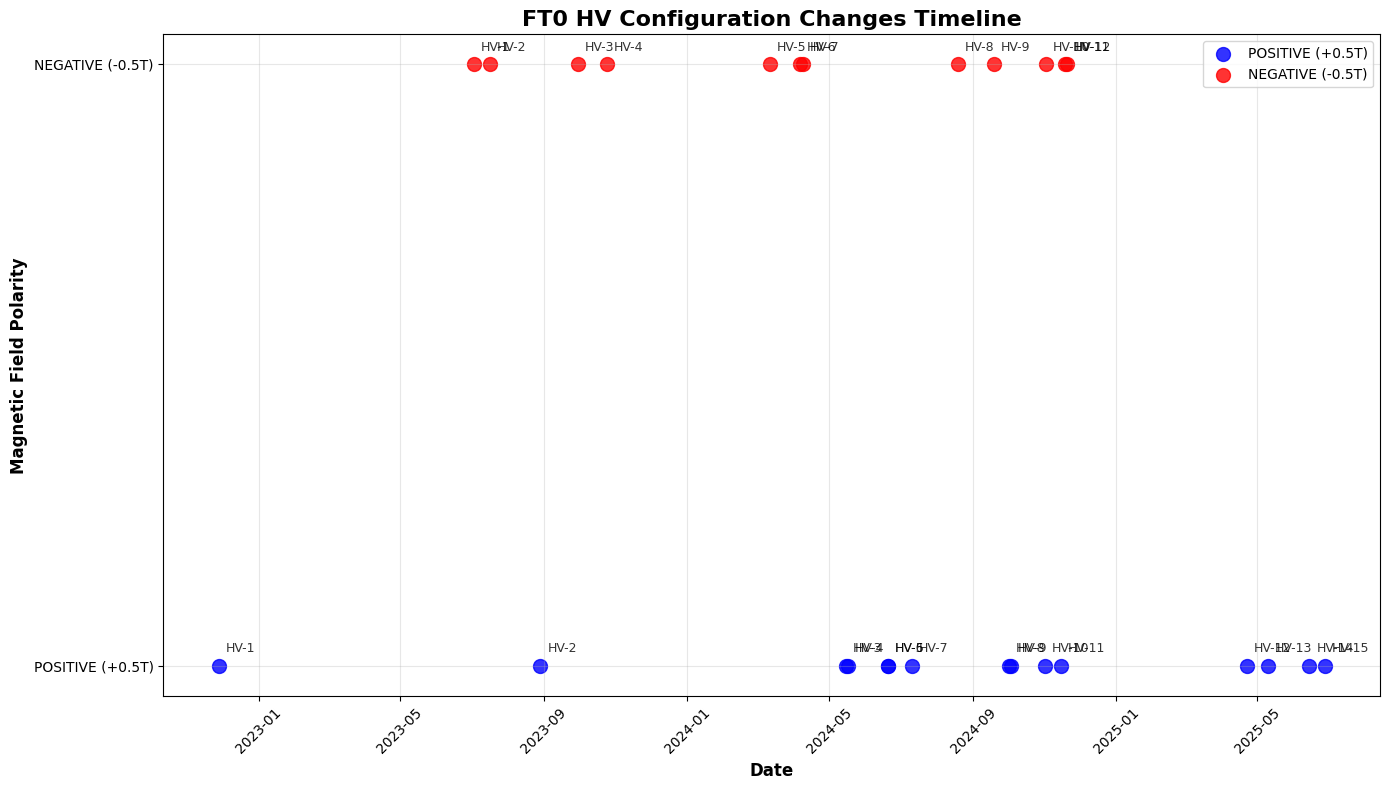


📋 HV Configuration DataFrame (27 events):
 timestamp_datetime polarity magnetic_field                                    title   author_name
2022-11-27 13:29:33 POSITIVE          +0.5T  Default FT0 HV config updated for +0.5T Yury Melikyan
2023-07-02 23:15:27 NEGATIVE          -0.5T       FT0 HV config fine-tuned for -0.5T Yury Melikyan
2023-07-16 23:15:53 NEGATIVE          -0.5T FT0 default HV config for -0.5T corre... Yury Melikyan
2023-08-28 20:56:49 POSITIVE          +0.5T     New FT0 HV and FEE configs for +0.5T Yury Melikyan
2023-09-29 21:52:36 NEGATIVE          -0.5T  Default FT0 HV config updated for -0.5T Yury Melikyan
2023-10-24 20:11:05 NEGATIVE          -0.5T New FT0 HV and FEE configs default fo... Yury Melikyan
2024-03-11 12:12:54 NEGATIVE          -0.5T New FT0 HV and FEE configs set defaul... Yury Melikyan
2024-04-05 21:26:17 NEGATIVE          -0.5T Default FT0 HV and FEE configs update... Yury Melikyan
2024-04-08 12:10:18 NEGATIVE          -0.5T Default FT0 HV and FEE

In [31]:
def load_hv_config_logs(json_file="hv_config_logs.json"):
    """
    Load and process HV configuration logs from JSON file
    
    Args:
        json_file: Path to JSON file containing HV configuration logs
    
    Returns:
        pandas.DataFrame: Processed HV configuration changes with timestamps and polarities
    """
    
    try:
        with open(json_file, 'r') as f:
            hv_data = json.load(f)
        
        print(f"📄 Loading HV configuration logs from {json_file}")
        print(f"   Total events in file: {hv_data['metadata']['total_events']}")
        print(f"   Generated at: {hv_data['metadata']['generated_at']}")
        
        # Extract events
        events = hv_data['events']
        
        # Process events into structured data
        hv_records = []
        
        for event in events:
            # Only process events with magnetic field information
            if 'magnetic_field' in event:
                magnetic_field = event['magnetic_field']
                
                # Map magnetic field to polarity
                if magnetic_field == "+0.5T":
                    polarity = "POSITIVE"
                elif magnetic_field == "-0.5T":
                    polarity = "NEGATIVE"
                else:
                    # Skip events that don't match our polarities of interest
                    continue
                
                # Convert timestamps
                timestamp_str = event['timestamp']
                timestamp_unix_ms = event['timestamp_unix']
                
                # Parse ISO timestamp
                timestamp_dt = datetime.fromisoformat(timestamp_str.replace('Z', '+00:00'))
                
                # Create record
                record = {
                    'event_id': event['id'],
                    'title': event['title'],
                    'timestamp_iso': timestamp_str,
                    'timestamp_datetime': timestamp_dt,
                    'timestamp_unix_ms': timestamp_unix_ms,
                    'magnetic_field': magnetic_field,
                    'polarity': polarity,
                    'author_name': event['author']['name'],
                    'author_id': event['author']['id'],
                    'text_preview': event.get('text_preview', '')[:100] + '...' if event.get('text_preview') else ''
                }
                
                hv_records.append(record)
        
        # Create DataFrame
        hv_df = pd.DataFrame(hv_records)
        
        if len(hv_df) == 0:
            print("⚠️  No HV configuration events found for POSITIVE or NEGATIVE polarities")
            return pd.DataFrame()
        
        # Sort by timestamp
        hv_df = hv_df.sort_values('timestamp_datetime').reset_index(drop=True)
        
        print(f"\n✅ Processed {len(hv_df)} HV configuration events:")
        
        # Group by polarity and show summary
        polarity_summary = hv_df.groupby('polarity').agg({
            'event_id': 'count',
            'timestamp_datetime': ['min', 'max']
        }).round(2)
        
        print(f"\n📊 HV Configuration Summary by Polarity:")
        for polarity in ['POSITIVE', 'NEGATIVE']:
            polarity_events = hv_df[hv_df['polarity'] == polarity]
            if len(polarity_events) > 0:
                print(f"   🔋 {polarity} ({polarity_events.iloc[0]['magnetic_field']}):")
                print(f"      Events: {len(polarity_events)}")
                print(f"      First: {polarity_events.iloc[0]['timestamp_datetime'].strftime('%Y-%m-%d %H:%M')}")
                print(f"      Last:  {polarity_events.iloc[-1]['timestamp_datetime'].strftime('%Y-%m-%d %H:%M')}")
        
        # Show sample events
        print(f"\n📋 Sample HV Events:")
        for i, row in hv_df.head(3).iterrows():
            print(f"   {i+1}. {row['timestamp_datetime'].strftime('%Y-%m-%d %H:%M')} | {row['polarity']} | {row['title'][:50]}...")
        
        return hv_df
        
    except FileNotFoundError:
        print(f"❌ Error: HV config file '{json_file}' not found")
        return pd.DataFrame()
    except json.JSONDecodeError as e:
        print(f"❌ Error: Invalid JSON in '{json_file}': {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error processing HV config logs: {e}")
        return pd.DataFrame()

def get_hv_periods_for_polarity(hv_df, polarity):
    """
    Get HV configuration periods for a specific polarity
    
    Args:
        hv_df: DataFrame from load_hv_config_logs()
        polarity: 'POSITIVE' or 'NEGATIVE'
    
    Returns:
        list: List of (start_time, end_time, title) tuples for plotting
    """
    
    polarity_events = hv_df[hv_df['polarity'] == polarity].copy()
    
    if len(polarity_events) == 0:
        return []
    
    periods = []
    
    for i, row in polarity_events.iterrows():
        start_time = row['timestamp_datetime']
        
        # End time is either the next HV change or a reasonable default (e.g., 30 days later)
        next_events = polarity_events[polarity_events['timestamp_datetime'] > start_time]
        
        if len(next_events) > 0:
            end_time = next_events.iloc[0]['timestamp_datetime']
        else:
            # If this is the last event, extend period to cover remaining data
            end_time = start_time + timedelta(days=60)  # 60 days forward
        
        periods.append((start_time, end_time, row['title']))
    
    return periods

def add_hv_periods_to_plot(ax, hv_df, polarity, alpha=0.15):
    """
    Add HV configuration periods as vertical shaded regions to an existing plot
    
    Args:
        ax: Matplotlib axis object
        hv_df: DataFrame from load_hv_config_logs()
        polarity: 'POSITIVE' or 'NEGATIVE' 
        alpha: Transparency of shaded regions
    """
    
    periods = get_hv_periods_for_polarity(hv_df, polarity)
    
    if not periods:
        return
    
    # Color coding for different HV periods
    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightpink']
    
    for i, (start_time, end_time, title) in enumerate(periods):
        color = colors[i % len(colors)]
        
        # Add shaded region
        ax.axvspan(start_time, end_time, alpha=alpha, color=color, 
                  label=f'HV Period {i+1}' if i < 3 else None)  # Only label first few to avoid clutter
        
        # Add vertical line at HV change
        ax.axvline(start_time, color='red', linestyle=':', alpha=0.7, linewidth=2)
        
        # Add text annotation for HV change
        y_limits = ax.get_ylim()
        y_pos = y_limits[1] - (y_limits[1] - y_limits[0]) * 0.02 * (i % 3 + 1)  # Stagger vertically
        
        ax.text(start_time, y_pos, f'HV Config {i+1}', 
               rotation=90, ha='right', va='top', fontsize=9, 
               color='red', alpha=0.8, fontweight='bold')

def create_hv_summary_plot(hv_df):
    """
    Create a timeline plot showing all HV configuration changes
    """
    
    if len(hv_df) == 0:
        print("No HV data to plot")
        return None
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot events by polarity
    for i, polarity in enumerate(['POSITIVE', 'NEGATIVE']):
        polarity_events = hv_df[hv_df['polarity'] == polarity]
        
        if len(polarity_events) > 0:
            times = polarity_events['timestamp_datetime']
            y_values = [i] * len(times)  # 0 for POSITIVE, 1 for NEGATIVE
            
            # Plot events
            colors = ['blue', 'red']
            ax.scatter(times, y_values, c=colors[i], s=100, alpha=0.8, 
                      label=f'{polarity} ({polarity_events.iloc[0]["magnetic_field"]})')
            
            # Add event labels
            for j, (time, title) in enumerate(zip(times, polarity_events['title'])):
                ax.annotate(f'HV-{j+1}', (time, i), xytext=(5, 10), 
                           textcoords='offset points', fontsize=9, alpha=0.8)
    
    # Styling
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['POSITIVE (+0.5T)', 'NEGATIVE (-0.5T)'])
    ax.set_xlabel('Date', fontweight='bold', fontsize=12)
    ax.set_ylabel('Magnetic Field Polarity', fontweight='bold', fontsize=12)
    ax.set_title('FT0 HV Configuration Changes Timeline', fontsize=16, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Format dates
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

# Load HV configuration data
print("🔋 Loading HV Configuration Logs...")
hv_df = load_hv_config_logs("../data/laserROOT/ft0_hv_corrections.json")  # Update with your actual file path

if len(hv_df) > 0:
    # Create summary plot
    hv_timeline_fig = create_hv_summary_plot(hv_df)
    if hv_timeline_fig:
        plt.show()
    
    # Display the dataframe
    print(f"\n📋 HV Configuration DataFrame ({len(hv_df)} events):")
    print("="*80)
    display_cols = ['timestamp_datetime', 'polarity', 'magnetic_field', 'title', 'author_name']
    if len(hv_df) > 0:
        print(hv_df[display_cols].to_string(index=False, max_colwidth=40))
    
    print(f"\n💡 Usage examples:")
    print(f"   - Get POSITIVE polarity periods: get_hv_periods_for_polarity(hv_df, 'POSITIVE')")
    print(f"   - Add HV periods to plot: add_hv_periods_to_plot(ax, hv_df, 'POSITIVE')")
    print(f"   - Access full dataframe: hv_df")
    
else:
    print("❌ No HV configuration data loaded. Please check the file path and format.")

### Plotting

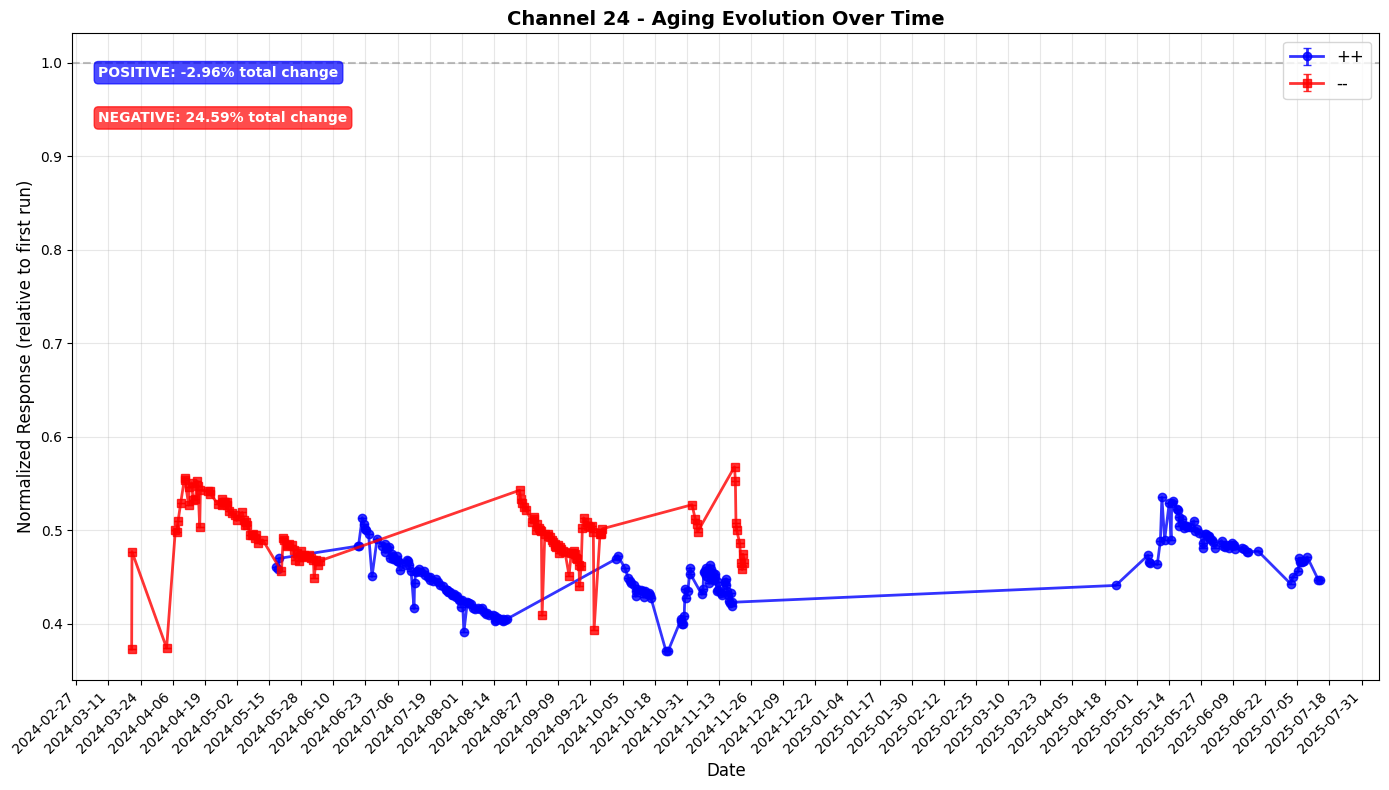


Summary for Channel 24:
  POSITIVE: 214 points, 422 days,  -2.96% change (1.0000 → 0.9704)
  NEGATIVE: 132 points, 247 days, +24.59% change (1.0000 → 1.2459)


In [29]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def plot_time_evolution(evolution_data, channel_id, save_path=None):
    """
    Plot time evolution for both polarities on the same canvas by date
    """
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    colors = {'POSITIVE': 'blue', 'NEGATIVE': 'red'}
    markers = {'POSITIVE': 'o', 'NEGATIVE': 's'}
    labels =  {'POSITIVE': '++', 'NEGATIVE': '--'}
    
    for polarity, data in evolution_data.items():
        # Plot with error bars using actual timestamps
        ax.errorbar(data['timestamp'], data['raw_normalized'], 
                   yerr=0, #data['normalized_err'], 
                   marker=markers.get(polarity, 'o'), 
                   linestyle='-', 
                   color=colors.get(polarity, 'black'),
                   label=labels.get(polarity, polarity),
                   markersize=6, capsize=3, linewidth=2,
                   alpha=0.8)
        
        # Add text with statistics for this polarity
        mean_change = (data['normalized_value'].iloc[-1] - 1.0) * 100
        y_pos = 0.95 if polarity == 'POSITIVE' else 0.88
        ax.text(0.02, y_pos, f'{polarity}: {mean_change:.2f}% total change', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor=colors.get(polarity, 'white'), 
                         alpha=0.7, edgecolor=colors.get(polarity, 'black')),
                color='white', fontweight='bold')
    
    # Formatting
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Normalized Response (relative to first run)', fontsize=12)
    ax.set_title(f'Channel {channel_id} - Aging Evolution Over Time', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12, loc='upper right')
    
    # Format x-axis dates
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(data)//10)))  # Adaptive spacing
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add horizontal line at 1.0
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
    
    # Improve layout
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary for Channel {channel_id}:")
    for polarity, data in evolution_data.items():
        if len(data) > 0:
            time_span = (data['timestamp'].max() - data['timestamp'].min()).days
            initial_val = data['normalized_value'].iloc[0]
            final_val = data['normalized_value'].iloc[-1]
            total_change = (final_val - initial_val) * 100
            print(f"  {polarity:8}: {len(data):3d} points, {time_span:3d} days, "
                  f"{total_change:+6.2f}% change ({initial_val:.4f} → {final_val:.4f})")

# Plot evolution for channel 24
plot_time_evolution(evolution_data, target_channel)

✨ Adding HV periods overlay for channel 24...
📅 Data spans 480 days from 2024-03-20 to 2025-07-14


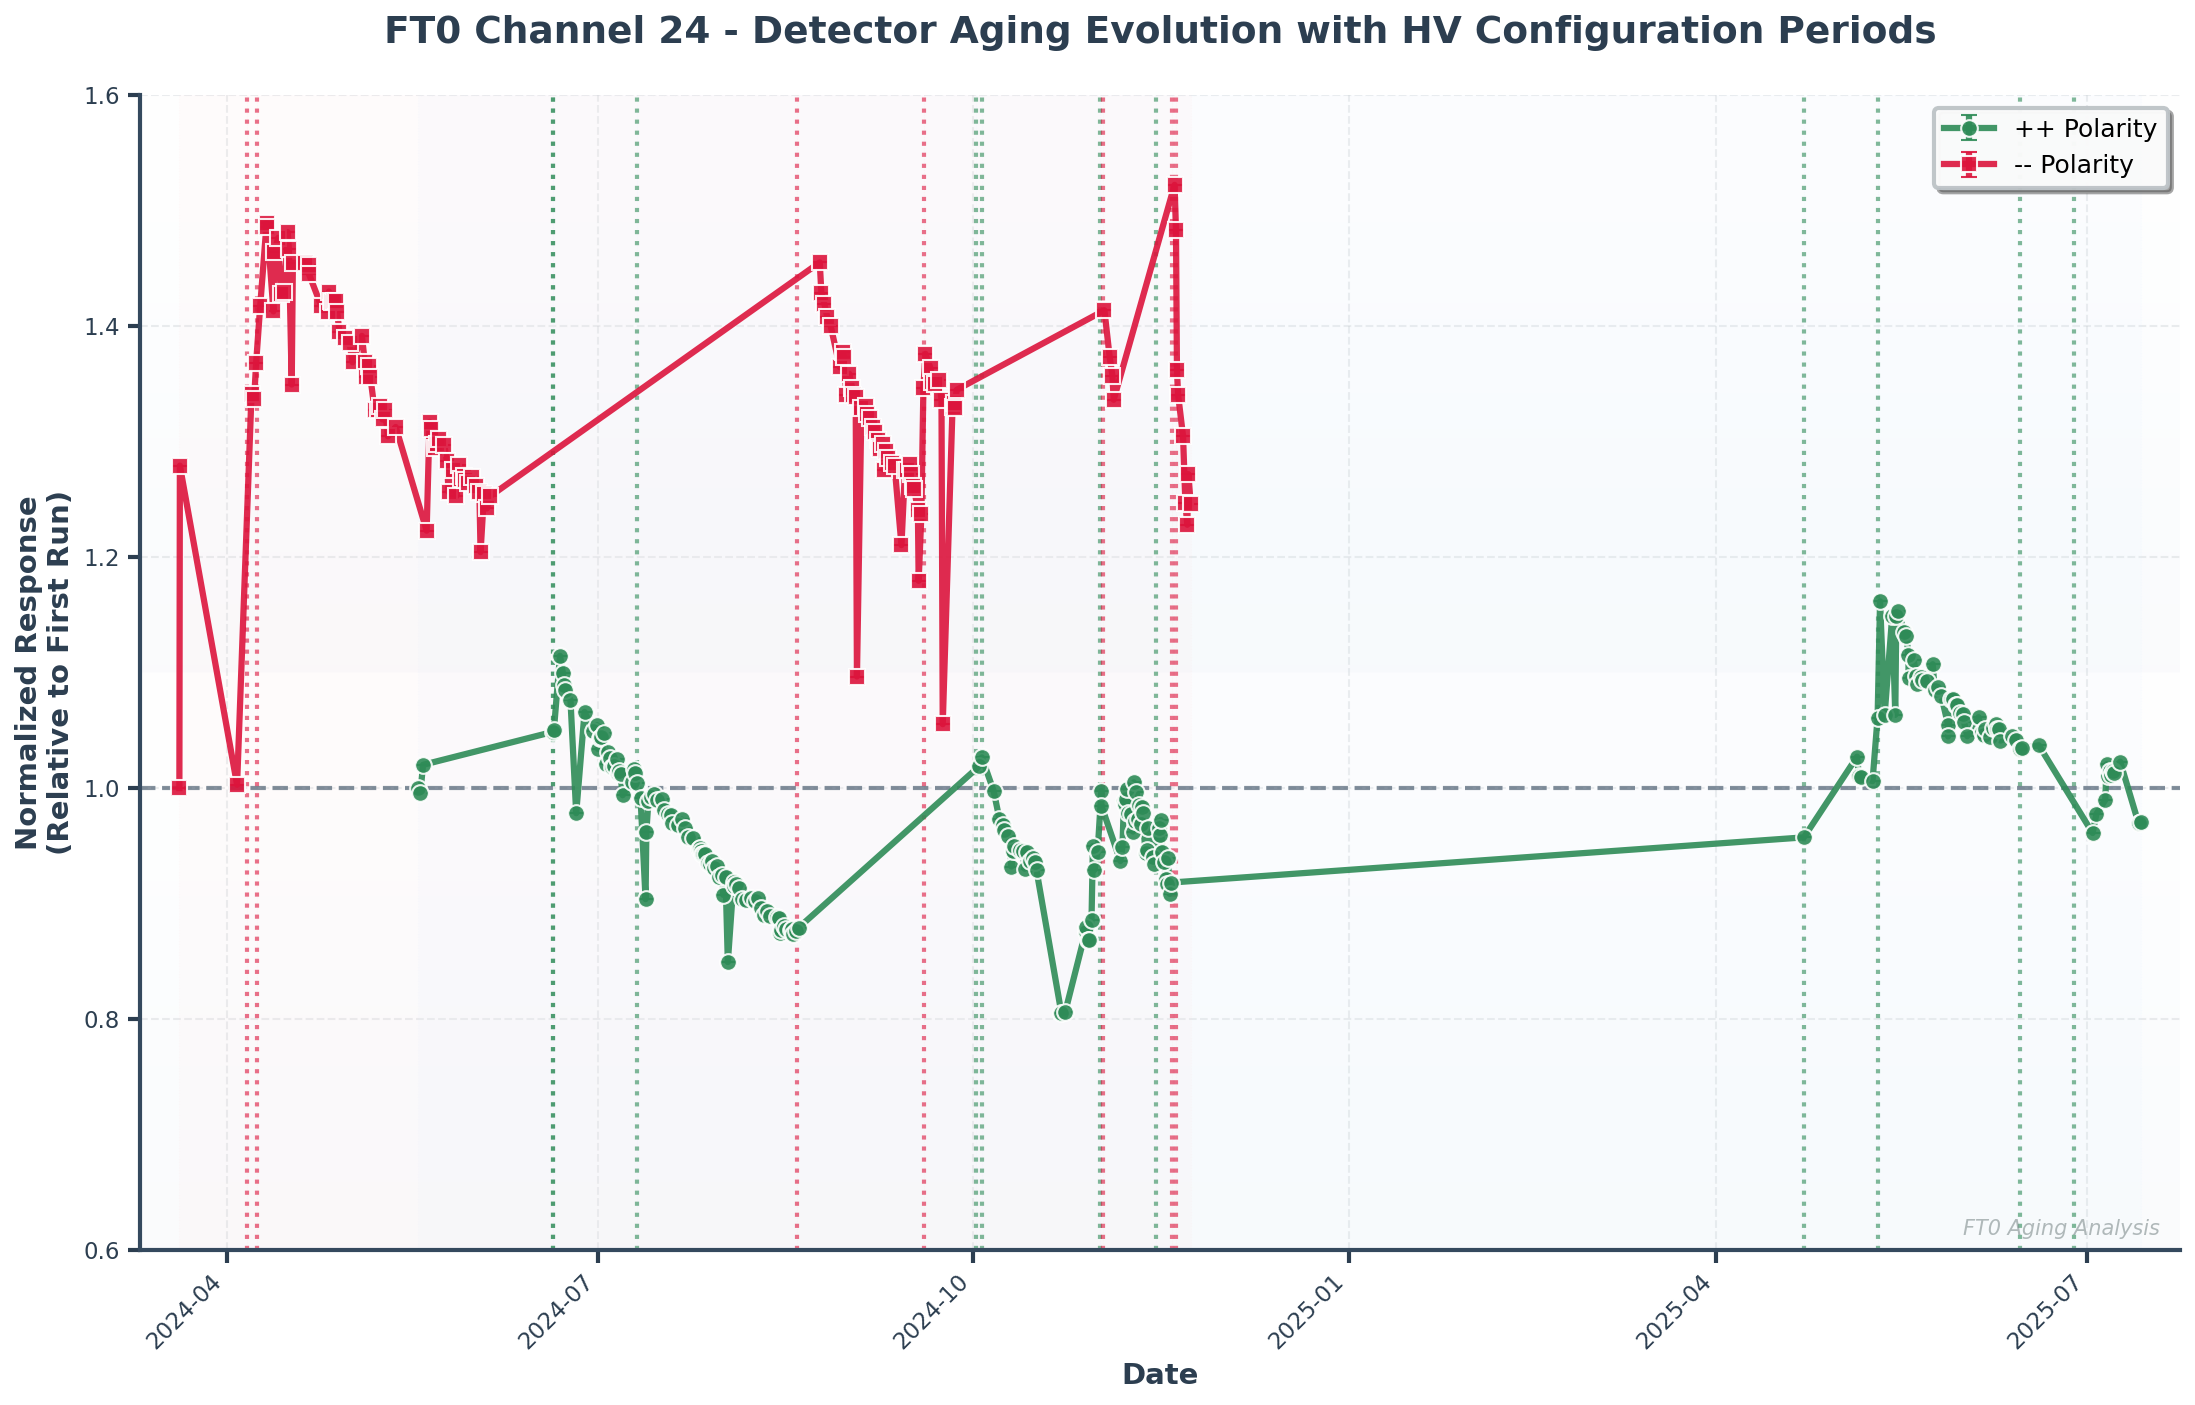


🔬 Analysis Summary for Channel 24
🔋 HV Configuration History:
   POSITIVE: 15 configuration periods
     Period 1: 2022-11-27 to 2023-08-28 (274 days)
              Default FT0 HV config updated for +0.5T
     Period 2: 2023-08-28 to 2024-05-15 (260 days)
              New FT0 HV and FEE configs for +0.5T
     Period 3: 2024-05-15 to 2024-05-16 (1 days)
              Default FT0 HV and FEE configs updated for +0.5T
     ... and 12 more periods
   NEGATIVE: 12 configuration periods
     Period 1: 2023-07-02 to 2023-07-16 (14 days)
              FT0 HV config fine-tuned for -0.5T
     Period 2: 2023-07-16 to 2023-09-29 (74 days)
              FT0 default HV config for -0.5T corrected (in FTC-...
     Period 3: 2023-09-29 to 2023-10-24 (24 days)
              Default FT0 HV config updated for -0.5T
     ... and 9 more periods

📊 Detector Response Evolution:
   POSITIVE: 214 points over 422 days
              -2.96% change (1.0000 → 0.9704) 🔴 DEGRADED
   NEGATIVE: 132 points over 247 days

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
import pandas as pd

def plot_time_evolution(evolution_data, channel_id, hv_df=None, save_path=None):
    """
    Plot time evolution for both polarities with beautiful modern styling
    
    Args:
        evolution_data: Dictionary with POSITIVE/NEGATIVE polarity data
        channel_id: Channel identifier for plot title
        hv_df: Optional HV configuration DataFrame for overlay
        save_path: Optional path to save the plot
    """
    # Create figure with high-resolution modern styling
    plt.style.use('default')
    fig = plt.figure(figsize=(16, 10), dpi=150)  # High DPI for crisp display
    fig.patch.set_facecolor('white')
    ax = plt.subplot(111)
    
    # Enhanced color scheme
    colors = {
        'POSITIVE': '#2E8B57',    # Sea Green - professional and elegant
        'NEGATIVE': '#DC143C'     # Crimson - vibrant but not harsh
    }
    
    # Enhanced markers and styling
    markers = {'POSITIVE': 'o', 'NEGATIVE': 's'}
    labels = {'POSITIVE': '++ Polarity', 'NEGATIVE': '-- Polarity'}
    
    # Add subtle gradient background
    gradient = np.linspace(0, 1, 256).reshape(256, -1)
    gradient = np.vstack((gradient, gradient))
    ax.imshow(gradient, extent=[0, 1, 0, 1], transform=ax.transAxes, 
             aspect='auto', alpha=0.02, cmap='Blues')
    
    # Add HV periods FIRST (as background) if available
    if hv_df is not None and len(hv_df) > 0:
        print(f"✨ Adding HV periods overlay for channel {channel_id}...")
        
        # Enhanced HV period styling
        hv_colors = {'POSITIVE': '#E6F3FF', 'NEGATIVE': '#FFE6E6'}  # Very light backgrounds
        
        for polarity in ['POSITIVE', 'NEGATIVE']:
            if polarity in evolution_data and len(evolution_data[polarity]) > 0:
                periods = get_hv_periods_for_polarity(hv_df, polarity)
                
                if periods:
                    # Get data time bounds for this polarity to limit HV period display
                    data_times = evolution_data[polarity]['timestamp']
                    data_min = min(data_times)
                    data_max = max(data_times)
                    
                    for i, (start_time, end_time, title) in enumerate(periods):
                        # Only show HV periods that overlap with actual data
                        if end_time < data_min or start_time > data_max:
                            continue  # Skip HV periods outside data range
                        
                        # Clip HV period to data bounds
                        display_start = max(start_time, data_min)
                        display_end = min(end_time, data_max)
                        
                        # Enhanced shaded regions with subtle borders
                        ax.axvspan(display_start, display_end, 
                                  alpha=0.12, 
                                  color=hv_colors[polarity],
                                  edgecolor=colors[polarity],
                                  linewidth=0.5,
                                  linestyle=':',
                                  zorder=1)
                        
                        # Elegant vertical lines at HV changes (only if within data range)
                        if data_min <= start_time <= data_max:
                            ax.axvline(start_time, color=colors[polarity], 
                                      linestyle=':', alpha=0.6, linewidth=2, zorder=2)
    
    # Plot data with enhanced styling
    plot_handles = []
    ax.set_ylim(0.6, 1.6)
    
    for polarity, data in evolution_data.items():
        if len(data) == 0:
            continue
            
        # Main data line with glow effect
        # Background glow
        #line_glow = ax.plot(data['timestamp'], data['normalized_value'], 
        #                   color=colors.get(polarity, 'black'),
        #                   linewidth=6, alpha=0.15, zorder=8)
        
        # Main line
        line_main = ax.errorbar(data['timestamp'], data['normalized_value'], 
                               yerr=0,
                               marker=markers.get(polarity, 'o'), 
                               linestyle='-', 
                               color=colors.get(polarity, 'black'),
                               label=labels.get(polarity, polarity),
                               markersize=8, 
                               markeredgewidth=1,
                               markeredgecolor='white',
                               capsize=4, 
                               linewidth=3,
                               alpha=0.9, 
                               zorder=10)
        
        plot_handles.append(line_main)
        
        # Enhanced statistics boxes
        mean_change = (data['normalized_value'].iloc[-1] - 1.0) * 100
        y_pos = 0.95 if polarity == 'POSITIVE' else 0.87
        
        # Include HV period count in statistics if available
        stats_text = f'{polarity} Polarity\n{mean_change:+.2f}% total change'
        if hv_df is not None and len(hv_df) > 0:
            hv_periods = get_hv_periods_for_polarity(hv_df, polarity)
            stats_text += f'\n{len(hv_periods)} HV configurations'
        
        # Beautiful statistics box
        """
        ax.text(0.02, y_pos, stats_text, 
                transform=ax.transAxes, verticalalignment='top',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.8', 
                         facecolor=colors.get(polarity, 'white'), 
                         alpha=0.9, 
                         edgecolor='white',
                         linewidth=2),
                color='white', zorder=15)
        """
    
    # Enhanced reference line
    ax.axhline(y=1.0, color='#34495E', linestyle='--', alpha=0.6, linewidth=2, zorder=5)
    
    # Professional axis styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#34495E')
    ax.spines['bottom'].set_color('#34495E')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    
    # Enhanced labels and title
    ax.set_xlabel('Date', fontsize=14, fontweight='bold', color='#2C3E50')
    ax.set_ylabel('Normalized Response\n(Relative to First Run)', 
                 fontsize=14, fontweight='bold', color='#2C3E50')
    
    # Sophisticated title
    hv_note = " with HV Configuration Periods" if hv_df is not None and len(hv_df) > 0 else ""
    ax.set_title(f'FT0 Channel {channel_id} - Detector Aging Evolution{hv_note}', 
                fontsize=18, fontweight='bold', color='#2C3E50', pad=25)
    
    # Enhanced grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=1, color='#BDC3C7')
    ax.set_axisbelow(True)
    
    # Beautiful legend
    legend = ax.legend(handles=plot_handles,
                      fontsize=12, loc='upper right', frameon=True, 
                      fancybox=True, shadow=True, framealpha=0.95,
                      edgecolor='#BDC3C7', facecolor='white')
    legend.get_frame().set_linewidth(2)
    
    # Enhanced tick styling with smart date locator
    ax.tick_params(axis='both', which='major', labelsize=11, colors='#2C3E50',
                  width=2, length=6)
    
    # Collect all actual data timestamps to determine plot bounds
    all_data_times = []
    for polarity, data in evolution_data.items():
        if len(data) > 0:
            all_data_times.extend(data['timestamp'])
    
    if all_data_times:
        # Set x-axis limits based on ACTUAL DATA, not HV periods
        data_time_min = min(all_data_times)
        data_time_max = max(all_data_times)
        data_time_range = data_time_max - data_time_min
        
        # Add 2% padding on each side
        padding = data_time_range.total_seconds() / 50  # 2% of range in seconds
        ax.set_xlim(data_time_min - timedelta(seconds=padding), 
                   data_time_max + timedelta(seconds=padding))
        
        # Smart date formatting based on data time span
        total_days = data_time_range.days
        
        if total_days <= 7:
            # Week or less - show daily
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        elif total_days <= 30:
            # Month or less - show every few days
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, total_days//7)))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        elif total_days <= 90:
            # Quarter or less - show weekly
            ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        elif total_days <= 365:
            # Year or less - show monthly
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        else:
            # More than a year - show every few months
            interval = max(1, total_days // 365 * 3)  # ~4 ticks per year
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        
        print(f"📅 Data spans {total_days} days from {data_time_min.strftime('%Y-%m-%d')} to {data_time_max.strftime('%Y-%m-%d')}")
    
    else:
        # Fallback if no data
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=8))
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add subtle minor grid only if data span is reasonable
    if all_data_times and data_time_range.days <= 90:
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.grid(True, which='minor', alpha=0.1, linestyle=':', linewidth=0.5)
    
    # Add HV annotations AFTER axis limits are set
    if hv_df is not None and len(hv_df) > 0:
        for polarity in ['POSITIVE', 'NEGATIVE']:
            if polarity in evolution_data and len(evolution_data[polarity]) > 0:
                periods = get_hv_periods_for_polarity(hv_df, polarity)
                
                if periods:
                    data_times = evolution_data[polarity]['timestamp']
                    data_min = min(data_times)
                    data_max = max(data_times)
                    
                    # Count HV periods within data range for annotation
                    visible_periods = []
                    for start_time, end_time, title in periods:
                        if not (end_time < data_min or start_time > data_max):
                            if data_min <= start_time <= data_max:
                                visible_periods.append((start_time, title))
                    
                    # Add stylish HV change annotations (limit to avoid clutter)
                    y_limits = ax.get_ylim()
                    y_range = y_limits[1] - y_limits[0]
                    
                    for i, (start_time, title) in enumerate(visible_periods[:4]):
                        y_pos = y_limits[1] - y_range * 0.03 * (i + 1)

                        """
                        ax.text(start_time, y_pos, f'HV Config {i+1}', 
                               rotation=90, ha='right', va='top', fontsize=9, 
                               color=colors[polarity], alpha=0.8, fontweight='bold',
                               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                                       edgecolor=colors[polarity], alpha=0.8, linewidth=1),
                               zorder=12)
                        """
    
    # Professional watermark
    ax.text(0.99, 0.01, f'FT0 Aging Analysis', transform=ax.transAxes,
           fontsize=10, alpha=0.6, ha='right', va='bottom',
           style='italic', color='#7F8C8D')
    
    # Enhanced layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.15, left=0.1, right=0.95)
    
    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches='tight', 
                   facecolor='white', edgecolor='none',
                   format='png', transparent=False,
                   metadata={'Software': 'FT0 Analysis'})
        print(f"✨ High-resolution plot saved to {save_path} (400 DPI)")
    
    plt.show()
    
    # Enhanced summary output
    print(f"\n🔬 Analysis Summary for Channel {channel_id}")
    print("="*65)
    
    # HV Configuration Summary
    if hv_df is not None and len(hv_df) > 0:
        print(f"🔋 HV Configuration History:")
        for polarity in ['POSITIVE', 'NEGATIVE']:
            hv_periods = get_hv_periods_for_polarity(hv_df, polarity)
            if hv_periods:
                print(f"   {polarity:8}: {len(hv_periods)} configuration periods")
                for i, (start, end, title) in enumerate(hv_periods[:3]):  # Show first 3
                    duration = (end - start).days
                    print(f"     Period {i+1}: {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')} ({duration} days)")
                    print(f"              {title[:50]}{'...' if len(title) > 50 else ''}")
                if len(hv_periods) > 3:
                    print(f"     ... and {len(hv_periods) - 3} more periods")
        print()
    
    # Data Evolution Summary
    print(f"📊 Detector Response Evolution:")
    for polarity, data in evolution_data.items():
        if len(data) > 0:
            time_span = (data['timestamp'].max() - data['timestamp'].min()).days
            initial_val = data['normalized_value'].iloc[0]
            final_val = data['normalized_value'].iloc[-1]
            total_change = (final_val - initial_val) * 100
            
            # Trend analysis
            if abs(total_change) < 1:
                trend = "🟢 STABLE"
            elif total_change < -2:
                trend = "🔴 DEGRADED"
            elif total_change > 2:
                trend = "🔵 IMPROVED"
            else:
                trend = "🟡 SLIGHT CHANGE"
            
            print(f"   {polarity:8}: {len(data):3d} points over {time_span:3d} days")
            print(f"             {total_change:+6.2f}% change ({initial_val:.4f} → {final_val:.4f}) {trend}")
    
    print("="*65)

def add_hv_to_existing_plot(ax, hv_df, polarities=['POSITIVE', 'NEGATIVE']):
    """
    Add beautiful HV periods to an existing matplotlib axis
    
    Args:
        ax: Matplotlib axis object
        hv_df: HV configuration DataFrame
        polarities: List of polarities to include
    """
    
    if hv_df is None or len(hv_df) == 0:
        print("No HV data available for overlay")
        return
    
    # Professional color scheme
    colors = {'POSITIVE': '#2E8B57', 'NEGATIVE': '#DC143C'}
    bg_colors = {'POSITIVE': '#E6F3FF', 'NEGATIVE': '#FFE6E6'}
    alphas = {'POSITIVE': 0.12, 'NEGATIVE': 0.10}
    
    for polarity in polarities:
        if polarity in colors:
            periods = get_hv_periods_for_polarity(hv_df, polarity)
            
            if periods:
                print(f"✨ Adding {len(periods)} beautiful HV periods for {polarity} polarity")
                
                for i, (start_time, end_time, title) in enumerate(periods):
                    # Enhanced shaded region
                    ax.axvspan(start_time, end_time, 
                              alpha=alphas[polarity], 
                              color=bg_colors[polarity],
                              edgecolor=colors[polarity],
                              linewidth=0.8,
                              linestyle=':',
                              label=f'{polarity} HV Config {i+1}' if i == 0 else None,
                              zorder=1)
                    
                    # Elegant vertical line at HV change
                    ax.axvline(start_time, color=colors[polarity], 
                              linestyle=':', alpha=0.7, linewidth=2, zorder=2)
                    
                    # Beautiful text annotation (limited to avoid clutter)
                    if i < 3:
                        y_limits = ax.get_ylim()
                        y_pos = y_limits[1] - (y_limits[1] - y_limits[0]) * 0.03 * (i + 1)
                        
                        ax.text(start_time, y_pos, f'HV-{i+1}', 
                               rotation=90, ha='right', va='top', fontsize=9, 
                               color=colors[polarity], alpha=0.8, fontweight='bold',
                               bbox=dict(boxstyle='round,pad=0.2', facecolor='white',
                                       edgecolor=colors[polarity], alpha=0.9, linewidth=1),
                               zorder=12)

def get_hv_periods_for_polarity(hv_df, polarity):
    """
    Get HV configuration periods for a specific polarity
    (This function should be imported from your main analysis)
    """
    if hv_df is None or len(hv_df) == 0:
        return []
    
    polarity_events = hv_df[hv_df['polarity'] == polarity].copy()
    
    if len(polarity_events) == 0:
        return []
    
    periods = []
    
    for i, row in polarity_events.iterrows():
        start_time = row['timestamp_datetime']
        
        # End time is either the next HV change or a reasonable default
        next_events = polarity_events[polarity_events['timestamp_datetime'] > start_time]
        
        if len(next_events) > 0:
            end_time = next_events.iloc[0]['timestamp_datetime']
        else:
            # If this is the last event, extend period to cover remaining data
            end_time = start_time + timedelta(days=60)  # 60 days forward
        
        periods.append((start_time, end_time, row['title']))
    
    return periods

# Display the demonstration
plot_time_evolution(evolution_data, target_channel, hv_df=hv_df)

### HV correction

In [60]:
def calculate_hv_corrected_evolution(normalized_results, metadata, hv_df, target_channel=24, 
                                     hv_buffer_hours=2, max_search_days=7):
    """
    Calculate time evolution with HV period-based normalization
    
    Args:
        normalized_results: Your existing results dict
        metadata: Run metadata DataFrame  
        hv_df: HV configuration DataFrame
        target_channel: Channel to analyze
        hv_buffer_hours: Hours to wait after HV change before considering runs
        max_search_days: Maximum days to search for first run after HV change
    
    Returns:
        dict: Evolution data with HV corrections applied
    """
    evolution_data = {}
    
    for polarity in normalized_results.keys():
        print(f"\n🔋 Processing {polarity} polarity HV corrections...")
        
        # Get HV periods for this polarity
        hv_periods = get_hv_periods_for_polarity(hv_df, polarity)
        
        if not hv_periods:
            print(f"⚠️  No HV periods found for {polarity} polarity")
            continue
        
        # Get all runs for this polarity, sorted by time
        polarity_runs = []
        for run_number in normalized_results[polarity].keys():
            if target_channel in normalized_results[polarity][run_number]:
                run_meta = metadata[metadata['run'] == run_number].iloc[0]
                polarity_runs.append({
                    'run_number': run_number,
                    'timestamp': run_meta['timestamp'],
                    'data': normalized_results[polarity][run_number][target_channel]
                })
        
        # Sort by timestamp
        polarity_runs.sort(key=lambda x: x['timestamp'])
        
        # Process each HV period
        corrected_data = []
        period_baselines = {}  # Store baseline for each period
        
        for period_idx, (hv_start, hv_end, hv_title) in enumerate(hv_periods):
            print(f"  📅 Processing HV Period {period_idx + 1}: {hv_start.strftime('%Y-%m-%d')}")
            
            # Find runs in this HV period (with buffer)
            buffer_start = hv_start + pd.Timedelta(hours=hv_buffer_hours)
            period_runs = [
                run for run in polarity_runs 
                if buffer_start <= run['timestamp'] <= hv_end
            ]
            
            if not period_runs:
                print(f"    ⚠️  No runs found in HV period {period_idx + 1}")
                continue
            
            # Find baseline run (first run in this period)
            baseline_run = period_runs[0]
            baseline_value = baseline_run['data']['normalized_mean']
            period_baselines[period_idx] = {
                'baseline_value': baseline_value,
                'baseline_run': baseline_run['run_number'],
                'baseline_timestamp': baseline_run['timestamp'],
                'hv_start': hv_start,
                'hv_title': hv_title
            }
            
            print(f"    🎯 Baseline: Run {baseline_run['run_number']} = {baseline_value:.4f}")
            print(f"    📊 Period contains {len(period_runs)} runs")
            
            # Process all runs in this period
            for run_info in period_runs:
                # Normalize to this period's baseline
                period_normalized = run_info['data']['normalized_mean'] / baseline_value
                
                corrected_data.append({
                    'run_number': run_info['run_number'],
                    'timestamp': run_info['timestamp'],
                    'hv_period': period_idx,
                    'hv_period_title': hv_title,
                    'hv_start': hv_start,
                    'raw_normalized': run_info['data']['normalized_mean'],
                    'period_normalized': period_normalized,  # Normalized within period
                    'baseline_run': baseline_run['run_number'],
                    'baseline_value': baseline_value,
                    'normalized_err': run_info['data']['normalized_err'],
                    'entries': run_info['data']['entries'],
                    'r_squared': run_info['data']['r_squared']
                })
        
        if not corrected_data:
            print(f"    ❌ No valid data found for {polarity}")
            continue
        
        # Convert to DataFrame
        df = pd.DataFrame(corrected_data)
        
        # Apply inter-period scaling to maintain continuity
        df = apply_inter_period_scaling(df, period_baselines)
        
        evolution_data[polarity] = df
        
        # Summary
        print(f"  ✅ {polarity} complete:")
        print(f"     Total runs: {len(df)}")
        print(f"     HV periods: {len(period_baselines)}")
        print(f"     Time span: {df['timestamp'].min()} to {df['timestamp'].max()}")
        
    return evolution_data, period_baselines


def apply_inter_period_scaling(df, period_baselines):
    """
    Apply scaling between HV periods to maintain continuity
    
    Strategy: Scale each period so the transition is smooth
    """
    if len(period_baselines) <= 1:
        # Only one period, just copy period_normalized to final_normalized
        df['final_normalized'] = df['period_normalized']
        return df
    
    print(f"    🔗 Applying inter-period scaling across {len(period_baselines)} periods...")
    
    df['final_normalized'] = 0.0
    cumulative_scale = 1.0
    
    for period_idx in sorted(period_baselines.keys()):
        period_data = df[df['hv_period'] == period_idx].copy()
        
        if len(period_data) == 0:
            continue
        
        if period_idx == 0:
            # First period: no scaling needed
            scale_factor = 1.0
        else:
            # Subsequent periods: scale to maintain continuity
            
            # Option 1: Scale so first point equals 1.0 (reset approach)
            # scale_factor = cumulative_scale
            
            # Option 2: Scale to maintain trend (smoother approach)
            prev_period_data = df[df['hv_period'] == period_idx - 1]
            if len(prev_period_data) > 0:
                # Scale so this period continues from where last period ended
                last_prev_value = prev_period_data.iloc[-1]['final_normalized'] 
                scale_factor = last_prev_value * cumulative_scale
            else:
                scale_factor = cumulative_scale
        
        # Apply scaling
        scaled_values = period_data['period_normalized'] * scale_factor
        df.loc[df['hv_period'] == period_idx, 'final_normalized'] = scaled_values
        df.loc[df['hv_period'] == period_idx, 'scale_factor'] = scale_factor
        
        # Update cumulative scale for next period
        if len(period_data) > 0:
            cumulative_scale = scale_factor
            
        print(f"      Period {period_idx}: scale factor = {scale_factor:.4f}")
    
    return df


def get_hv_summary_stats(evolution_data, period_baselines):
    """
    Generate summary statistics for HV-corrected analysis
    """
    print("\n" + "="*80)
    print("🔋 HV-CORRECTED AGING ANALYSIS SUMMARY")
    print("="*80)
    
    for polarity, df in evolution_data.items():
        if len(df) == 0:
            continue
            
        print(f"\n📊 {polarity} POLARITY:")
        print(f"   Total runs analyzed: {len(df)}")
        print(f"   Time span: {df['timestamp'].min().strftime('%Y-%m-%d')} to {df['timestamp'].max().strftime('%Y-%m-%d')}")
        
        # HV period breakdown
        period_summary = df.groupby('hv_period').agg({
            'run_number': 'count',
            'timestamp': ['min', 'max'],
            'period_normalized': ['min', 'max'],
            'final_normalized': ['min', 'max']
        }).round(4)
        
        print(f"\n   🔋 HV Period Breakdown:")
        for period_idx in sorted(df['hv_period'].unique()):
            period_data = df[df['hv_period'] == period_idx]
            period_info = period_baselines[polarity][period_idx] if polarity in period_baselines else {}
            
            aging_in_period = (period_data['period_normalized'].iloc[-1] - 1.0) * 100
            
            print(f"     Period {period_idx}: {len(period_data):3d} runs")
            print(f"       Time: {period_data['timestamp'].min().strftime('%Y-%m-%d')} to {period_data['timestamp'].max().strftime('%Y-%m-%d')}")
            print(f"       Aging within period: {aging_in_period:+.2f}%")
            print(f"       Baseline run: {period_data.iloc[0]['baseline_run']}")
        
        # Overall aging trends
        total_aging = (df['final_normalized'].iloc[-1] - 1.0) * 100
        print(f"\n   📈 Overall Aging Trend:")
        print(f"       Total change: {total_aging:+.2f}%")
        print(f"       Final normalized value: {df['final_normalized'].iloc[-1]:.4f}")
        
        # Period-by-period aging rates
        print(f"\n   📉 Aging Rates by Period:")
        for period_idx in sorted(df['hv_period'].unique()):
            period_data = df[df['hv_period'] == period_idx]
            if len(period_data) > 1:
                days_in_period = (period_data['timestamp'].max() - period_data['timestamp'].min()).days
                aging_in_period = (period_data['period_normalized'].iloc[-1] - 1.0) * 100
                aging_rate = aging_in_period / max(days_in_period, 1) * 365  # Per year
                
                print(f"       Period {period_idx}: {aging_rate:+.2f}%/year ({days_in_period} days)")


# Example usage:
def analyze_channel_with_hv_corrections(normalized_results, metadata, hv_df, target_channel=24):
    """
    Complete analysis pipeline with HV corrections
    """
    print(f"🔬 Analyzing Channel {target_channel} with HV Corrections")
    print("="*60)
    
    # Calculate HV-corrected evolution
    evolution_data, period_baselines = calculate_hv_corrected_evolution(
        normalized_results, metadata, hv_df, target_channel
    )
    
    # Generate summary statistics
    get_hv_summary_stats(evolution_data, period_baselines)
    
    return evolution_data, period_baselines


# Modified plotting function to work with HV-corrected data
def plot_hv_corrected_evolution(evolution_data, period_baselines, channel_id, save_path=None):
    """
    Plot time evolution with HV period corrections and boundaries
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), height_ratios=[2, 1])
    
    colors = {'POSITIVE': '#2E8B57', 'NEGATIVE': '#DC143C'}
    
    # Main plot: HV-corrected evolution
    for polarity, df in evolution_data.items():
        if len(df) == 0:
            continue
            
        # Plot final normalized values
        ax1.plot(df['timestamp'], df['final_normalized'], 
                marker='o', linestyle='-', color=colors[polarity],
                label=f'{polarity} (HV-corrected)', markersize=6, linewidth=2)
        
        # Add HV period boundaries
        for period_idx in df['hv_period'].unique():
            period_data = df[df['hv_period'] == period_idx]
            hv_start = period_data.iloc[0]['hv_start']
            ax1.axvline(hv_start, color=colors[polarity], linestyle=':', alpha=0.7)
            ax1.text(hv_start, ax1.get_ylim()[1] * 0.95, f'HV-{period_idx+1}', 
                    rotation=90, ha='right', va='top', fontsize=9)
    
    # Subplot: Period-normalized view (aging within each period)
    for polarity, df in evolution_data.items():
        if len(df) == 0:
            continue
            
        # Plot period-normalized values
        ax2.plot(df['timestamp'], df['period_normalized'], 
                marker='s', linestyle='-', color=colors[polarity],
                label=f'{polarity} (within periods)', markersize=4, linewidth=1.5, alpha=0.8)
        
        # Add HV period boundaries
        for period_idx in df['hv_period'].unique():
            period_data = df[df['hv_period'] == period_idx]
            hv_start = period_data.iloc[0]['hv_start']
            ax2.axvline(hv_start, color=colors[polarity], linestyle=':', alpha=0.7)
    
    # Styling
    ax1.set_ylabel('HV-Corrected Response', fontsize=12, fontweight='bold')
    ax1.set_title(f'Channel {channel_id} - HV-Corrected Aging Evolution', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    
    ax2.set_ylabel('Within-Period Response', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax2.set_title('Aging Within Each HV Period (Each period starts at 1.0)', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    
    # Format dates
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✨ Plot saved to {save_path}")
    
    plt.show()

🔬 Analyzing Channel 24 with HV Corrections

🔋 Processing POSITIVE polarity HV corrections...
  📅 HV Period 1: 2022-11-27
    ⚠️  No runs found in this period
  📅 HV Period 2: 2023-08-28
    ⚠️  No runs found in this period
  📅 HV Period 3: 2024-05-15
    ⚠️  No runs found in this period
  📅 HV Period 4: 2024-05-16
    🎯 Baseline run 551689  value=0.4607
    📊 Period contains 3 runs
  📅 HV Period 5: 2024-06-19
    ⚠️  No runs found in this period
  📅 HV Period 6: 2024-06-19
    🎯 Baseline run 553134  value=0.4837
    📊 Period contains 28 runs
  📅 HV Period 7: 2024-07-10
    🎯 Baseline run 554102  value=0.4569
    📊 Period contains 57 runs
  📅 HV Period 8: 2024-10-01
    🎯 Baseline run 558130  value=0.4693
    📊 Period contains 1 runs
  📅 HV Period 9: 2024-10-03
    🎯 Baseline run 558260  value=0.4597
    📊 Period contains 26 runs
  📅 HV Period 10: 2024-10-31
    🎯 Baseline run 559389  value=0.4595
    📊 Period contains 24 runs
  📅 HV Period 11: 2024-11-14
    🎯 Baseline run 560014  valu

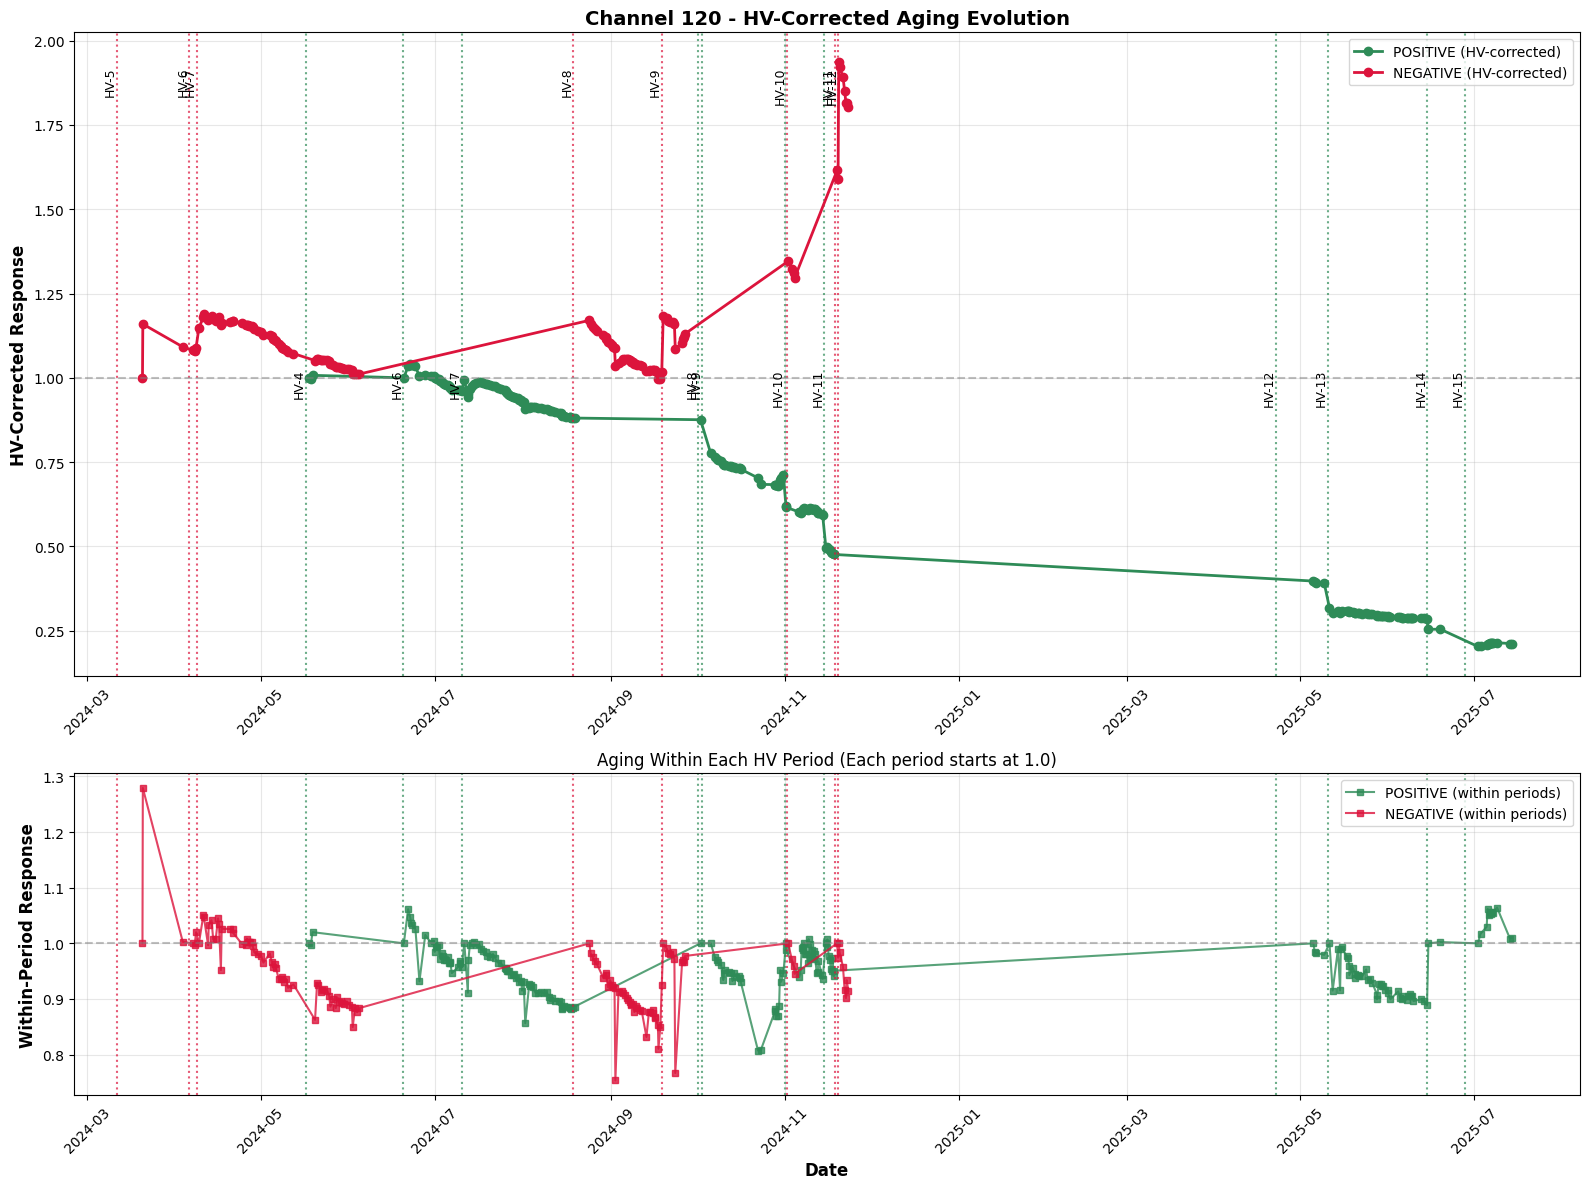

In [64]:
evolution_data, period_baselines = analyze_channel_with_hv_corrections(all_normalized_results, metadata, hv_df)
plot_hv_corrected_evolution(evolution_data, period_baselines, 120)

In [65]:
def calculate_hv_corrected_evolution_final(normalized_results, metadata, hv_df, target_channel=24, 
                                          hv_buffer_hours=2, min_runs_per_period=5, 
                                          min_period_days=3):
    """
    Calculate time evolution with each HV configuration as separate period
    NO MERGING - each HV config change creates a new period
    
    Args:
        normalized_results: Your existing results dict
        metadata: Run metadata DataFrame  
        hv_df: HV configuration DataFrame
        target_channel: Channel to analyze
        hv_buffer_hours: Hours to wait after HV change
        min_runs_per_period: Minimum runs required per period
        min_period_days: Minimum days for a period to be valid
    
    Returns:
        dict: Evolution data with proper HV period separation
    """
    evolution_data = {}
    
    for polarity in normalized_results.keys():
        print(f"\n🔋 Processing {polarity} polarity HV corrections (FINAL)...")
        
        # Get original HV periods - NO MERGING AT ALL
        original_periods = get_hv_periods_for_polarity(hv_df, polarity)
        if not original_periods:
            print(f"⚠️  No HV periods found for {polarity} polarity")
            continue
        
        print(f"  📅 Found {len(original_periods)} HV configuration periods")
        
        # Get all runs for this polarity
        polarity_runs = []
        for run_number in normalized_results[polarity].keys():
            if target_channel in normalized_results[polarity][run_number]:
                run_meta = metadata[metadata['run'] == run_number].iloc[0]
                polarity_runs.append({
                    'run_number': run_number,
                    'timestamp': run_meta['timestamp'],
                    'data': normalized_results[polarity][run_number][target_channel]
                })
        
        polarity_runs.sort(key=lambda x: x['timestamp'])
        
        # Process each HV period separately - NO MERGING
        period_data = []
        valid_periods = []
        
        for period_idx, (hv_start, hv_end, hv_title) in enumerate(original_periods):
            print(f"  📅 HV Period {period_idx}: {hv_start.strftime('%Y-%m-%d')} to {hv_end.strftime('%Y-%m-%d')} ({(hv_end-hv_start).days} days)")
            
            # Find runs in this period (with buffer)
            buffer_start = hv_start + pd.Timedelta(hours=hv_buffer_hours)
            period_runs = [
                run for run in polarity_runs 
                if buffer_start <= run['timestamp'] <= hv_end
            ]
            
            # Check if period meets minimum requirements
            period_duration = (hv_end - hv_start).days
            
            if len(period_runs) < min_runs_per_period:
                print(f"    ⏭️  Only {len(period_runs)} runs (need {min_runs_per_period}) - skipping")
                continue
                
            if period_duration < min_period_days:
                print(f"    ⏭️  Only {period_duration} days (need {min_period_days}) - skipping")
                continue
            
            # Get robust baseline (median of first 3 runs in this period)
            baseline_runs = period_runs[:min(3, len(period_runs))]
            baseline_values = [run['data']['normalized_mean'] for run in baseline_runs]
            baseline_value = np.median(baseline_values)
            
            print(f"    ✅ Valid period: {len(period_runs)} runs, baseline = {baseline_value:.4f}")
            
            # Process all runs in this period - OPTION A: Each period starts at 1.0
            for run_info in period_runs:
                # Normalize to this period's baseline (period starts at 1.0)
                period_normalized = run_info['data']['normalized_mean'] / baseline_value
                
                period_data.append({
                    'run_number': run_info['run_number'],
                    'timestamp': run_info['timestamp'],
                    'hv_period': len(valid_periods),  # Use valid period index
                    'hv_period_original_idx': period_idx,
                    'hv_period_title': hv_title,
                    'hv_start': hv_start,
                    'hv_end': hv_end,
                    'raw_normalized': run_info['data']['normalized_mean'],
                    'period_normalized': period_normalized,  # This IS the final value (Option A)
                    'baseline_value': baseline_value,
                    'baseline_runs_count': len(baseline_runs),
                    'normalized_err': run_info['data']['normalized_err'],
                    'entries': run_info['data']['entries'],
                    'r_squared': run_info['data']['r_squared']
                })
            
            valid_periods.append({
                'period_idx': len(valid_periods),
                'original_idx': period_idx,
                'hv_start': hv_start,
                'hv_end': hv_end,
                'hv_title': hv_title,
                'n_runs': len(period_runs),
                'duration_days': period_duration,
                'baseline_value': baseline_value
            })
        
        if not period_data:
            print(f"    ❌ No valid periods found for {polarity}")
            continue
        
        # Convert to DataFrame
        df = pd.DataFrame(period_data)
        
        # For Option A, period_normalized IS the final value
        df['final_normalized'] = df['period_normalized']
        
        evolution_data[polarity] = df
        
        # Summary
        print(f"  ✅ {polarity} complete:")
        print(f"     Total runs: {len(df)}")
        print(f"     Valid HV periods: {len(valid_periods)}")
        print(f"     Period indices: {sorted(df['hv_period'].unique())}")
        print(f"     Time span: {df['timestamp'].min().strftime('%Y-%m-%d')} to {df['timestamp'].max().strftime('%Y-%m-%d')}")
        
        # Show individual period aging
        for period_info in valid_periods:
            period_data_subset = df[df['hv_period'] == period_info['period_idx']]
            if len(period_data_subset) > 0:
                aging = (period_data_subset['final_normalized'].iloc[-1] - 1.0) * 100
                aging_rate = aging / period_info['duration_days'] * 365  # per year
                print(f"     Period {period_info['period_idx']}: {period_info['n_runs']} runs, "
                      f"{period_info['duration_days']} days, {aging:+.1f}% aging ({aging_rate:+.1f}%/year)")
        
    return evolution_data


def get_hv_summary_stats_final(evolution_data):
    """
    Generate summary statistics for properly separated HV periods
    """
    print("\n" + "="*80)
    print("🔋 HV-CORRECTED AGING ANALYSIS SUMMARY (FINAL)")
    print("="*80)
    
    for polarity, df in evolution_data.items():
        if len(df) == 0:
            continue
            
        print(f"\n📊 {polarity} POLARITY:")
        print(f"   Total runs analyzed: {len(df)}")
        print(f"   HV periods: {len(df['hv_period'].unique())}")
        print(f"   Time span: {df['timestamp'].min().strftime('%Y-%m-%d')} to {df['timestamp'].max().strftime('%Y-%m-%d')}")
        
        # Per-period detailed analysis
        print(f"\n   🔋 HV Period Details:")
        period_end_values = []
        period_aging_rates = []
        
        for period_idx in sorted(df['hv_period'].unique()):
            period_data = df[df['hv_period'] == period_idx]
            
            # Calculate aging within this period
            period_start_value = period_data.iloc[0]['final_normalized']  # Should be ~1.0
            period_end_value = period_data.iloc[-1]['final_normalized']
            aging_in_period = (period_end_value - period_start_value) * 100
            
            # Time info
            period_start_time = period_data['timestamp'].min()
            period_end_time = period_data['timestamp'].max()
            period_days = (period_end_time - period_start_time).days
            
            # Aging rate
            aging_rate_per_year = (aging_in_period / max(period_days, 1)) * 365 if period_days > 0 else 0
            
            # Data quality
            avg_r_squared = period_data['r_squared'].mean()
            entries_range = f"{period_data['entries'].min()}-{period_data['entries'].max()}"
            
            print(f"     Period {period_idx}: {len(period_data):3d} runs, {period_days:3d} days")
            print(f"       📅 {period_start_time.strftime('%Y-%m-%d')} to {period_end_time.strftime('%Y-%m-%d')}")
            print(f"       📈 Aging: {aging_in_period:+6.2f}% ({aging_rate_per_year:+6.1f}%/year)")
            print(f"       🎯 Range: {period_start_value:.3f} → {period_end_value:.3f}")
            print(f"       📊 Quality: R²={avg_r_squared:.3f}, entries={entries_range}")
            
            period_end_values.append(period_end_value)
            period_aging_rates.append(aging_rate_per_year)
        
        # Overall assessment
        if len(period_end_values) > 1:
            print(f"\n   📈 Overall Assessment:")
            print(f"       Period end values: {[f'{v:.3f}' for v in period_end_values]}")
            print(f"       Aging rates: {[f'{r:+.1f}' for r in period_aging_rates]}%/year")
            
            # HV correction effectiveness
            avg_end_drift = np.mean([abs(v - 1.0) for v in period_end_values])
            if avg_end_drift < 0.1:
                effectiveness = "🟢 Excellent HV correction effectiveness"
            elif avg_end_drift < 0.15:
                effectiveness = "🟡 Good HV correction effectiveness"  
            elif avg_end_drift < 0.25:
                effectiveness = "🟠 Moderate HV correction effectiveness"
            else:
                effectiveness = "🔴 Poor HV correction effectiveness"
            
            print(f"       {effectiveness} (avg drift: {avg_end_drift:.3f})")
            
            # Aging trend across periods
            if len(period_aging_rates) > 2:
                recent_rates = period_aging_rates[-3:]  # Last 3 periods
                avg_recent_aging = np.mean([abs(r) for r in recent_rates])
                
                if avg_recent_aging < 10:
                    aging_trend = "🟢 Low aging rates"
                elif avg_recent_aging < 20:
                    aging_trend = "🟡 Moderate aging rates"
                else:
                    aging_trend = "🔴 High aging rates"
                    
                print(f"       {aging_trend} (recent avg: {avg_recent_aging:.1f}%/year)")


def plot_hv_corrected_evolution_final(evolution_data, channel_id, save_path=None):
    """
    Plot evolution with clean separated HV periods
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import numpy as np
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), height_ratios=[3, 1])
    
    colors = {'POSITIVE': '#2E8B57', 'NEGATIVE': '#427bf5'}
    
    # Main plot: Each HV period as separate segment
    for polarity, df in evolution_data.items():
        if len(df) == 0:
            continue
            
        # Plot each period separately with clean styling
        for period_idx in sorted(df['hv_period'].unique()):
            period_data = df[df['hv_period'] == period_idx]
            
            # Clean line plot for each period
            ax1.plot(period_data['timestamp'], period_data['final_normalized'], 
                    marker='o', linestyle='-', color=colors[polarity],
                    markersize=3, linewidth=2, alpha=0.8,
                    label=f'{polarity}' if period_idx == 0 else "")  # Only label first period
            
            # Period boundary
            hv_start = period_data.iloc[0]['hv_start']
            ax1.axvline(hv_start, color=colors[polarity], linestyle=':', alpha=0.6, linewidth=1)
            
            # Period shading
            period_start_time = period_data['timestamp'].min()
            period_end_time = period_data['timestamp'].max()
            ax1.axvspan(period_start_time, period_end_time, 
                       alpha=0.05, color=colors[polarity])
            
            # Period number annotation
            mid_time = period_start_time + (period_end_time - period_start_time) / 2
            ax1.text(mid_time, 1.08, f'{period_idx+1}', 
                    ha='center', va='center', fontsize=8, fontweight='bold',
                    color=colors[polarity], 
                    bbox=dict(boxstyle='circle,pad=0.1', facecolor='white', 
                             edgecolor=colors[polarity], alpha=0.8))
    
    # Bottom plot: Period end values (HV effectiveness)
    for polarity, df in evolution_data.items():
        if len(df) == 0:
            continue
            
        # Get period end values and times
        period_end_values = []
        period_end_times = []
        
        for period_idx in sorted(df['hv_period'].unique()):
            period_data = df[df['hv_period'] == period_idx]
            end_value = period_data.iloc[-1]['final_normalized']
            end_time = period_data['timestamp'].max()
            
            period_end_values.append(end_value)
            period_end_times.append(end_time)
        
        # Plot period end values
        ax2.plot(period_end_times, period_end_values, 
                marker='s', linestyle='-', color=colors[polarity],
                markersize=6, linewidth=2, alpha=0.8,
                label=f'{polarity} period ends')
        
        # Annotate each point with period number
        for i, (time, value) in enumerate(zip(period_end_times, period_end_values)):
            ax2.annotate(f'{i+1}', (time, value), xytext=(0, 10), 
                        textcoords='offset points', ha='center', va='bottom',
                        fontsize=8, fontweight='bold', color=colors[polarity])
    
    # Styling
    ax1.set_ylabel('HV-Corrected Response\n(Each period starts at 1.0)', 
                  fontsize=12, fontweight='bold')
    ax1.set_title(f'Channel {channel_id} - HV Period Analysis (Each HV Config = Separate Period)', 
                 fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=1.0, color='gray', linestyle='-', alpha=0.7, linewidth=2)
    ax1.set_ylim(0.7, 1.3)
    
    ax2.set_ylabel('Period End Values', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax2.set_title('HV Correction Effectiveness (How well does each HV change restore performance?)', 
                 fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=1.0, color='gray', linestyle='-', alpha=0.7, linewidth=2)
    ax2.set_ylim(0.7, 1.3)
    
    # Format dates
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✨ Plot saved to {save_path}")
    
    plt.show()


def analyze_channel_with_hv_corrections_final(normalized_results, metadata, hv_df, target_channel=24,
                                            min_runs_per_period=5, min_period_days=7):
    """
    FINAL analysis with properly separated HV periods - NO MERGING
    """
    print(f"🔬 FINAL HV Analysis - Channel {target_channel}")
    print("="*60)
    print(f"⚙️  Configuration:")
    print(f"   🔧 NO MERGING - Each HV config = separate period")
    print(f"   📊 Minimum runs per period: {min_runs_per_period}")
    print(f"   📅 Minimum period duration: {min_period_days} days")
    print(f"   🎯 Method: Option A (Each period resets to 1.0)")
    print(f"   ⏱️  Buffer after HV change: 2 hours")
    
    # Calculate evolution with separated periods
    evolution_data = calculate_hv_corrected_evolution_final(
        normalized_results, metadata, hv_df, target_channel,
        min_runs_per_period=min_runs_per_period,
        min_period_days=min_period_days
    )
    
    # Generate detailed summary
    get_hv_summary_stats_final(evolution_data)
    
    # Create clean plot
    plot_hv_corrected_evolution_final(evolution_data, target_channel)
    
    return evolution_data


# Helper functions
import numpy as np
import pandas as pd

def get_hv_periods_for_polarity(hv_df, polarity):
    """Get HV configuration periods for a specific polarity"""
    if hv_df is None or len(hv_df) == 0:
        return []
    
    polarity_events = hv_df[hv_df['polarity'] == polarity].copy()
    
    if len(polarity_events) == 0:
        return []
    
    periods = []
    
    for i, row in polarity_events.iterrows():
        start_time = row['timestamp_datetime']
        
        # End time is either the next HV change or a reasonable default
        next_events = polarity_events[polarity_events['timestamp_datetime'] > start_time]
        
        if len(next_events) > 0:
            end_time = next_events.iloc[0]['timestamp_datetime']
        else:
            # If this is the last event, extend period to cover remaining data
            end_time = start_time + pd.Timedelta(days=60)
        
        periods.append((start_time, end_time, row['title']))
    
    return periods

🔬 FINAL HV Analysis - Channel 24
⚙️  Configuration:
   🔧 NO MERGING - Each HV config = separate period
   📊 Minimum runs per period: 5
   📅 Minimum period duration: 7 days
   🎯 Method: Option A (Each period resets to 1.0)
   ⏱️  Buffer after HV change: 2 hours

🔋 Processing POSITIVE polarity HV corrections (FINAL)...
  📅 Found 15 HV configuration periods
  📅 HV Period 0: 2022-11-27 to 2023-08-28 (274 days)
    ⏭️  Only 0 runs (need 5) - skipping
  📅 HV Period 1: 2023-08-28 to 2024-05-15 (260 days)
    ⏭️  Only 0 runs (need 5) - skipping
  📅 HV Period 2: 2024-05-15 to 2024-05-16 (1 days)
    ⏭️  Only 0 runs (need 5) - skipping
  📅 HV Period 3: 2024-05-16 to 2024-06-19 (34 days)
    ⏭️  Only 3 runs (need 5) - skipping
  📅 HV Period 4: 2024-06-19 to 2024-06-19 (0 days)
    ⏭️  Only 0 runs (need 5) - skipping
  📅 HV Period 5: 2024-06-19 to 2024-07-10 (20 days)
    ✅ Valid period: 28 runs, baseline = 0.5064
  📅 HV Period 6: 2024-07-10 to 2024-10-01 (83 days)
    ✅ Valid period: 57 runs, bas

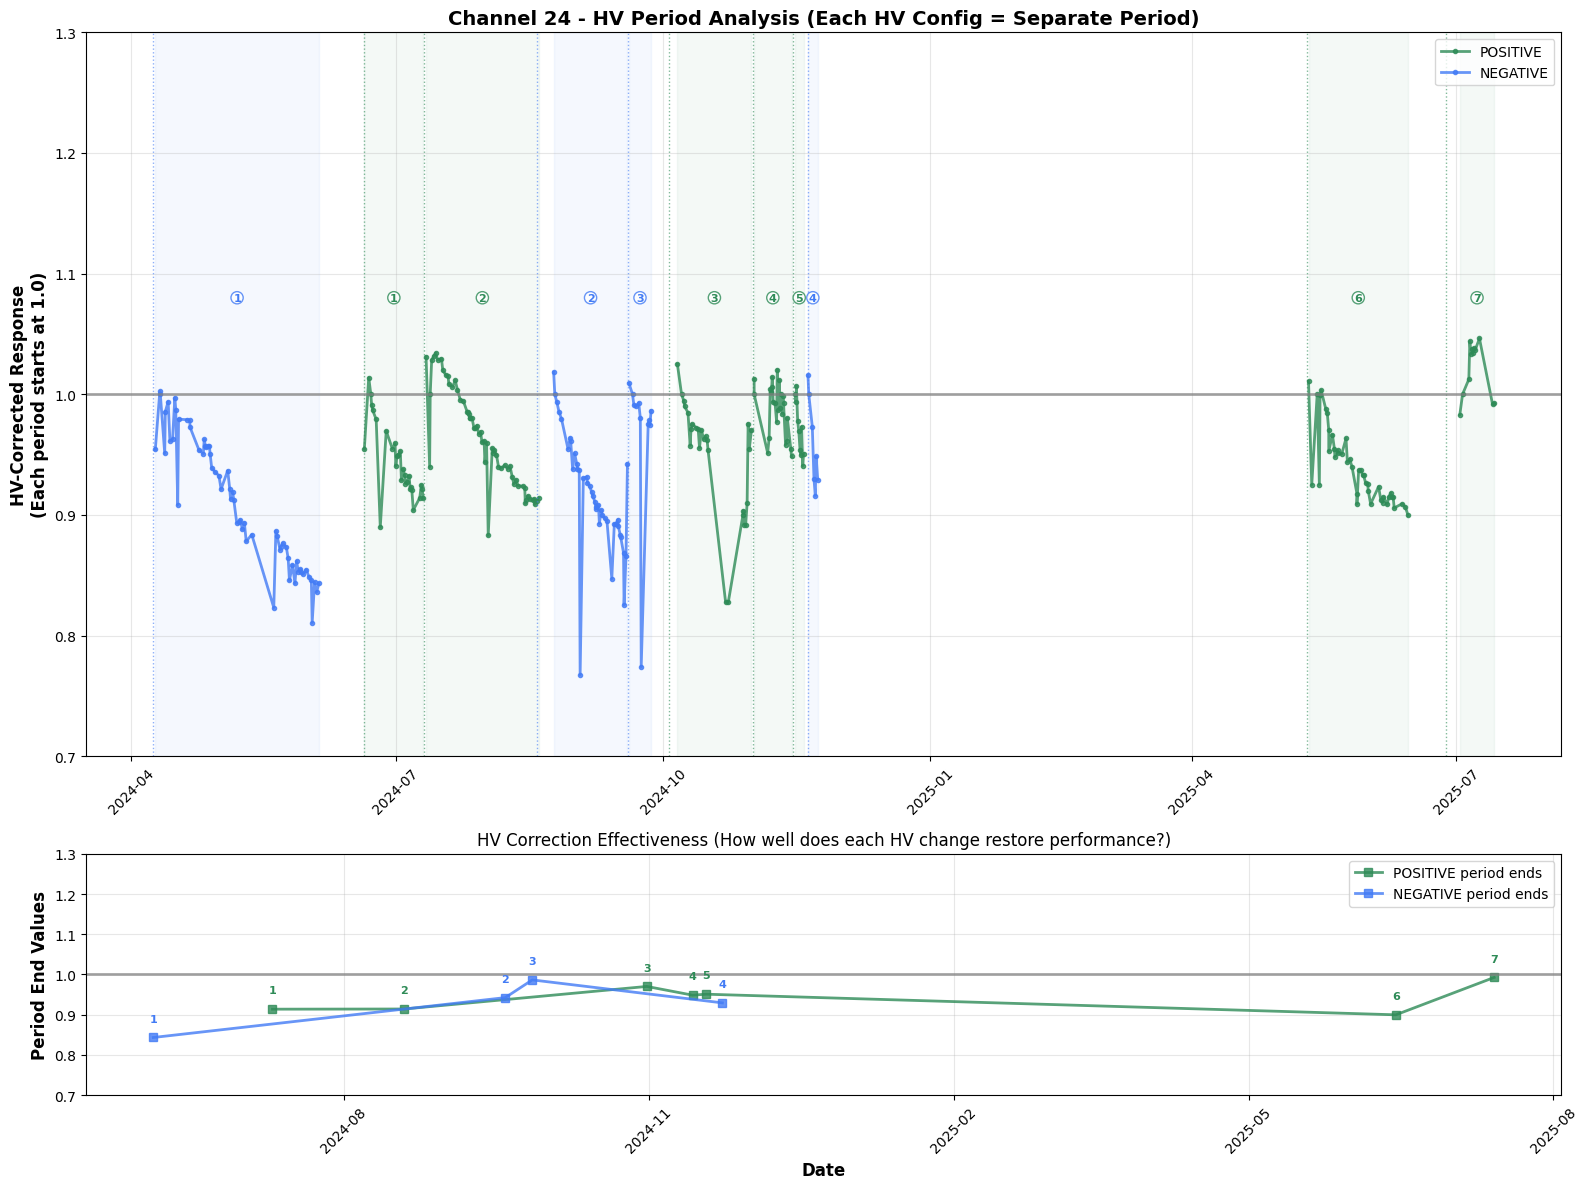

In [66]:
# FINAL VERSION - No merging, clean separation
evolution_data = analyze_channel_with_hv_corrections_final(
    all_normalized_results, metadata, hv_df, target_channel=24,
    min_runs_per_period=5,    # Require at least 5 runs
    min_period_days=7         # Require at least 7 days
)

### ROOT saving and summary

In [53]:
import uproot

def save_results_to_root(all_normalized_results, metadata, output_file="aging_analysis_results.root"):
    """
    Save analysis results to ROOT file for further analysis
    """
    
    # Prepare data for ROOT file
    root_data = {}
    
    for polarity in all_normalized_results.keys():
        polarity_key = polarity.lower().replace(' ', '_')
        
        # Collect all data for this polarity
        runs = []
        timestamps = []
        channel_ids = []
        normalized_means = []
        normalized_errs = []
        raw_means = []
        r_squared_vals = []
        entries = []
        
        for run_number in sorted(all_normalized_results[polarity].keys()):
            run_meta = metadata[metadata['run'] == run_number].iloc[0]
            
            for channel_id in sorted(all_normalized_results[polarity][run_number].keys()):
                data = all_normalized_results[polarity][run_number][channel_id]
                
                runs.append(run_number)
                timestamps.append(run_meta['start_ms'])
                channel_ids.append(channel_id)
                normalized_means.append(data['normalized_mean'])
                normalized_errs.append(data['normalized_err'])
                raw_means.append(data['raw_mean'])
                r_squared_vals.append(data['r_squared'])
                entries.append(data['entries'])
        
        # Create arrays for ROOT file
        root_data[f"{polarity_key}_run"] = np.array(runs, dtype=np.int32)
        root_data[f"{polarity_key}_timestamp"] = np.array(timestamps, dtype=np.int64)
        root_data[f"{polarity_key}_channel"] = np.array(channel_ids, dtype=np.int32)
        root_data[f"{polarity_key}_normalized_mean"] = np.array(normalized_means, dtype=np.float64)
        root_data[f"{polarity_key}_normalized_err"] = np.array(normalized_errs, dtype=np.float64)
        root_data[f"{polarity_key}_raw_mean"] = np.array(raw_means, dtype=np.float64)
        root_data[f"{polarity_key}_r_squared"] = np.array(r_squared_vals, dtype=np.float64)
        root_data[f"{polarity_key}_entries"] = np.array(entries, dtype=np.int32)
        
        print(f"{polarity}: {len(runs)} entries saved")
    
    # Write to ROOT file
    with uproot.recreate(output_file) as f:
        f.mktree("aging_data", root_data)
    
    print(f"Results saved to {output_file}")
    
    # Also save as CSV for easy inspection
    for polarity in all_normalized_results.keys():
        polarity_key = polarity.lower().replace(' ', '_')
        
        df = pd.DataFrame({
            'run': root_data[f"{polarity_key}_run"],
            'timestamp': root_data[f"{polarity_key}_timestamp"],
            'channel': root_data[f"{polarity_key}_channel"],
            'normalized_mean': root_data[f"{polarity_key}_normalized_mean"],
            'normalized_err': root_data[f"{polarity_key}_normalized_err"],
            'raw_mean': root_data[f"{polarity_key}_raw_mean"],
            'r_squared': root_data[f"{polarity_key}_r_squared"],
            'entries': root_data[f"{polarity_key}_entries"]
        })
        
        csv_file = f"aging_results_{polarity_key}.csv"
        df.to_csv(csv_file, index=False)
        print(f"CSV saved: {csv_file}")

# Save results
save_results_to_root(all_normalized_results, metadata)

NEGATIVE: 14283 entries saved
POSITIVE: 23003 entries saved


TypeError: not a NumPy dtype or an Awkward datashape: array([549661, 549661, 549661, ..., 560403, 560403, 560403],
      shape=(14283,), dtype=int32)

In [54]:
def generate_analysis_summary(all_normalized_results, metadata, valid_files, invalid_files):
    """
    Generate comprehensive summary of the analysis including file validation
    """
    print("=== ANALYSIS SUMMARY ===\n")
    
    # File validation summary
    total_files_found = len(valid_files) + len(invalid_files)
    print(f"FILE VALIDATION:")
    print(f"  Total files found: {total_files_found}")
    print(f"  Valid files: {len(valid_files)} ({len(valid_files)/total_files_found*100:.1f}%)")
    print(f"  Invalid/empty files: {len(invalid_files)} ({len(invalid_files)/total_files_found*100:.1f}%)")
    
    if invalid_files:
        print(f"  Most common file issues:")
        error_types = {}
        for _, _, error in invalid_files:
            error_type = error.split(':')[0] if ':' in error else error
            error_types[error_type] = error_types.get(error_type, 0) + 1
        
        for error_type, count in sorted(error_types.items(), key=lambda x: x[1], reverse=True)[:3]:
            print(f"    {error_type}: {count} files")
    
    print(f"\nPROCESSING RESULTS:")
    
    total_runs = 0
    total_measurements = 0
    
    for polarity in all_normalized_results.keys():
        polarity_runs = len(all_normalized_results[polarity])
        total_runs += polarity_runs
        
        # Count total measurements
        polarity_measurements = sum(
            len(run_data) for run_data in all_normalized_results[polarity].values()
        )
        total_measurements += polarity_measurements
        
        print(f"\n{polarity} Polarity:")
        print(f"  Processed runs: {polarity_runs}")
        print(f"  Total measurements: {polarity_measurements}")
        
        if polarity_runs > 0:
            # Time span
            run_numbers = list(all_normalized_results[polarity].keys())
            meta_subset = metadata[metadata['run'].isin(run_numbers)]
            time_span = (meta_subset['timestamp'].max() - meta_subset['timestamp'].min()).total_seconds() / (24 * 3600)
            
            print(f"  Time span: {time_span:.1f} days")
            print(f"  Run range: {min(run_numbers)} - {max(run_numbers)}")
            
            # Quality metrics
            all_r_squared = []
            all_entries = []
            
            for run_data in all_normalized_results[polarity].values():
                for ch_data in run_data.values():
                    all_r_squared.append(ch_data['r_squared'])
                    all_entries.append(ch_data['entries'])
            
            print(f"  Average R²: {np.mean(all_r_squared):.3f} ± {np.std(all_r_squared):.3f}")
            print(f"  Average entries per channel: {np.mean(all_entries):.0f}")
            
            # Channel coverage
            channel_counts = {}
            for run_data in all_normalized_results[polarity].values():
                for ch_id in run_data.keys():
                    channel_counts[ch_id] = channel_counts.get(ch_id, 0) + 1
            
            print(f"  Channels with data: {len(channel_counts)}")
            if channel_counts:
                best_channel, best_count = max(channel_counts.items(), key=lambda x: x[1])
                print(f"  Best coverage: Channel {best_channel} ({best_count}/{polarity_runs} runs)")
    
    print(f"\nOVERALL TOTALS:")
    print(f"  Runs successfully processed: {total_runs}")
    print(f"  Total channel measurements: {total_measurements}")
    print(f"  Target channels analyzed: {len(TARGET_CHANNELS)}")
    print(f"  Reference channels used: {REFERENCE_CHANNELS}")
    print(f"  Data quality threshold: R² > 0.5, entries > 100")

# Generate summary
generate_analysis_summary(all_normalized_results, metadata, valid_files, invalid_files)

# Final sanity check - verify we can recreate a plot
print("\n=== FINAL SANITY CHECK ===")

# Check if we have any valid results
if len(all_normalized_results) == 0:
    print("❌ ERROR: No analysis results available")
    print("Possible issues:")
    print("  - All ROOT files were invalid/empty")
    print("  - No files met the quality thresholds")
    print("  - Branch structure incompatible")
elif len(evolution_data) == 0:
    print("⚠️  WARNING: No time evolution data for target channel")
    print("Possible issues:")
    print(f"  - Channel {target_channel} not available in enough runs")
    print("  - Insufficient data points for evolution analysis")
else:
    print("✅ SUCCESS: Analysis pipeline completed successfully")
    for polarity, data in evolution_data.items():
        print(f"  {polarity}: Channel {target_channel} evolution data has {len(data)} points")
        if len(data) > 0:
            first_val = data['normalized_value'].iloc[0]
            last_val = data['normalized_value'].iloc[-1]
            change_percent = ((last_val / first_val) - 1) * 100
            print(f"    First value: {first_val:.4f}")
            print(f"    Last value: {last_val:.4f}")
            print(f"    Total change: {change_percent:.2f}%")

# Summary of file handling
total_files_found = len(valid_files) + len(invalid_files)
if invalid_files:
    print(f"\n📁 FILE HANDLING SUMMARY:")
    print(f"  Total files found: {total_files_found}")
    print(f"  Successfully processed: {len(valid_files)}")
    print(f"  Skipped (empty/invalid): {len(invalid_files)}")
    print(f"  Success rate: {len(valid_files)/total_files_found*100:.1f}%")

print(f"\n🎉 Analysis complete!")
print(f"   Empty/corrupt files were automatically handled")
print(f"   Results saved for further analysis in ROOT format")

=== ANALYSIS SUMMARY ===

FILE VALIDATION:
  Total files found: 189
  Valid files: 189 (100.0%)
  Invalid/empty files: 0 (0.0%)

PROCESSING RESULTS:

NEGATIVE Polarity:
  Processed runs: 71
  Total measurements: 14283
  Time span: 229.5 days
  Run range: 549661 - 560403
  Average R²: 0.956 ± 0.049
  Average entries per channel: 119033
  Channels with data: 207
  Best coverage: Channel 0 (71/71 runs)

POSITIVE Polarity:
  Processed runs: 115
  Total measurements: 23003
  Time span: 422.1 days
  Run range: 551689 - 564587
  Average R²: 0.959 ± 0.048
  Average entries per channel: 119087
  Channels with data: 207
  Best coverage: Channel 0 (115/115 runs)

OVERALL TOTALS:
  Runs successfully processed: 186
  Total channel measurements: 37286
  Target channels analyzed: 208
  Reference channels used: [208, 210, 211]
  Data quality threshold: R² > 0.5, entries > 100

=== FINAL SANITY CHECK ===
✅ SUCCESS: Analysis pipeline completed successfully
  NEGATIVE: Channel 24 evolution data has 71 po